This notebook shows the computation of the probability transforms and the related PIT plots. 

In [1]:
from tensorflow.keras.layers import Input, Dense, Concatenate
from cbrain.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler

import torch as to

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import xarray as xr

import tensorflow.keras as ke


from cbrain.imports import *

from cbrain.utils import *

from cbrain.cam_constants import *

from cbrain.data_generator import DataGenerator
import pandas as ps
import seaborn as sns

2024-09-09 15:23:11.493462: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/b/b309162/.conda/envs/lightning_gpu_V_pytorch/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#load ANNs and ANN dropout 

ANN_1_lin=to.jit.load('real_geography/ANNs/ANN_1/ANN_1_CRM_lin_jit.pt')
ANN_2_lin=to.jit.load('real_geography/ANNs/ANN_2/ANN_2_CRM_lin_jit.pt')
ANN_3_lin=to.jit.load('real_geography/ANNs/ANN_3/ANN_3_CRM_lin_jit.pt')
ANN_4_lin=to.jit.load('real_geography/ANNs/ANN_4/ANN_4_CRM_lin_jit.pt')
ANN_5_lin=to.jit.load('real_geography/ANNs/ANN_5/ANN_5_CRM_lin_jit.pt')
ANN_6_lin=to.jit.load('real_geography/ANNs/ANN_6/ANN_6_CRM_lin_jit.pt')
ANN_7_lin=to.jit.load('real_geography/ANNs/ANN_7/ANN_7_CRM_lin_jit.pt')


ANN_1_lin_dr_0_01=to.jit.load('real_geography/ANNs/ANN_1/ANN_1_lin_dr_out_0_01_torch_jit.pt')


In [3]:
#load Encoders and Decoders of VEDs 

VEnc_1=to.jit.load('real_geography/VEDs/VED_1/VEncoder_1_torch_jit.pt')
VDec_1=to.jit.load('real_geography/VEDs/VED_1/VDecoder_1_torch_jit.pt')

VEnc_2=to.jit.load('real_geography/VEDs/VED_2/VEncoder_2_torch_jit.pt')
VDec_2=to.jit.load('real_geography/VEDs/VED_2/VDecoder_2_torch_jit.pt')

VEnc_3=to.jit.load('real_geography/VEDs/VED_3/VEncoder_3_torch_jit.pt')
VDec_3=to.jit.load('real_geography/VEDs/VED_3/VDecoder_3_torch_jit.pt')

VEnc_4=to.jit.load('real_geography/VEDs/VED_4/VEncoder_4_torch_jit.pt')
VDec_4=to.jit.load('real_geography/VEDs/VED_4/VDecoder_4_torch_jit.pt')

VEnc_5=to.jit.load('real_geography/VEDs/VED_5/VEncoder_5_torch_jit.pt')
VDec_5=to.jit.load('real_geography/VEDs/VED_5/VDecoder_5_torch_jit.pt')

VEnc_7=to.jit.load('real_geography/VEDs/VED_7/VEncoder_7_torch_jit.pt')
VDec_7=to.jit.load('real_geography/VEDs/VED_7/VDecoder_7_torch_jit.pt')


In [4]:
batch_size = 3551

in_vars = ['QBP', 'TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX','PRECTt-dt','CLDLIQBP','CLDICEBP']
out_vars = ['QBCTEND','TBCTEND','CLDLIQBCTEND','CLDICEBCTEND','PREC_CRM_SNOW','PREC_CRM',
            'NN2L_FLWDS','NN2L_DOWN_SW','NN2L_SOLL','NN2L_SOLLD','NN2L_SOLS','NN2L_SOLSD']

#loading the output normalization scalars for SP variables ( stds over 2 months of SP simulation)

scale_array=ps.read_csv('nn_config/scale_dicts/real_geography_SP_vars_updt.csv')


QBC_std_surf=scale_array.QBCTEND_std.values[-1]

TBC_std=scale_array.TBCTEND_std.values[-1]
CLDLIQBCTEND_std=scale_array.CLDLIQBCTEND_std.values[-1]
CLDICEBCTEND_std=scale_array.CLDICEBCTEND_std.values[-1]


PRECT_std=scale_array.PRECT_std.values
PREC_CRM_SNOW_std=scale_array.PRECT_CRM_SNOW_std.values
PREC_CRM_std=scale_array.PRECT_CRM_std.values
NN2L_FLWDS_std=scale_array.NN2L_FLWDS_std.values
NN2L_DOWN_SW_std=scale_array.NN2L_DOWN_SW_std.values
NN2L_SOLL_std=scale_array.NN2L_SOLL_std.values
NN2L_SOLLD_std=scale_array.NN2L_SOLLD_std.values
NN2L_SOLS_std=scale_array.NN2L_SOLS_mean_std.values
NN2L_SOLSD_std=scale_array.NN2L_SOLSD_mean_std.values





# defining the scaling dict for the ANN training 

scale_dict_II = {
    'QBCTEND': 1/QBC_std_surf, 
    'TBCTEND': 1/TBC_std, 
    'CLDICEBCTEND': 1/CLDICEBCTEND_std, 
    'CLDLIQBCTEND': 1/CLDLIQBCTEND_std, 
    'NN2L_FLWDS':1/NN2L_FLWDS_std,
    'NN2L_DOWN_SW':1/NN2L_DOWN_SW_std,
    'NN2L_SOLL':1/NN2L_SOLL_std,
    'NN2L_SOLLD':1/NN2L_SOLLD_std,
    'NN2L_SOLS':1/NN2L_SOLS_std,
    'NN2L_SOLSD':1/NN2L_SOLSD_std,    
    'PRECT': 1/PRECT_std,
    'PREC_CRM': 1/PREC_CRM_std,
    'PREC_CRM_SNOW': 1/PREC_CRM_SNOW_std
}







from cbrain.data_generator import DataGenerator

test_xr=xr.open_dataset('/work/bd1179/from_Mistral/bd1179/b381624/CESM2_NN2_pelayout01_ens_07.cam.h1.2013-01-01-00000.nc')
hybi=test_xr.hybi
hyai=test_xr.hyai


PS = 1e5; P0 = 1e5;
P = P0*hyai+PS*hybi; # Total pressure [Pa]
dP = P[1:]-P[:-1];

In [5]:
#load test data 

val_gen_II = DataGenerator(
    data_fn = '../SPCESM_data/2015_test_7_consec_days_mem.nc',
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = '../SPCESM_data/2013_norm_7_consec_days_mem.nc',
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict_II,
    batch_size=int(96*144),
    shuffle=True
)

In [6]:
out_vars_VED = ['QBCTEND','TBCTEND','CLDLIQBCTEND','CLDICEBCTEND', 'PRECT','PREC_CRM_SNOW','PREC_CRM',
            'NN2L_FLWDS','NN2L_DOWN_SW','NN2L_SOLL','NN2L_SOLLD','NN2L_SOLS','NN2L_SOLSD']
val_gen_III = DataGenerator(
    data_fn = '../SPCESM_data/2015_test_7_consec_days_mem.nc',
    input_vars = in_vars,
    output_vars = out_vars_VED,
    norm_fn = '../SPCESM_data/2013_norm_7_consec_days_mem.nc',
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict_II,
    batch_size=int(96*144),
    shuffle=True
)

# PIT computation from Haynes et al 2023

In [7]:
PIT_BIN_EDGES = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [8]:
def get_histogram(var, bins=10, density=False, weights=None):
    counts, bin_edges = np.histogram(
        var, bins=bins, density=density, weights=weights)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    return counts, bin_centers

In [9]:
def get_pit_evalue(nbins, tsamples):
    evalue = (1. - 1./nbins)/(tsamples * nbins)
    return np.sqrt(evalue)

In [10]:
def get_pit_dvalue(pit_counts):
    dvalue = 0.
    nbins = pit_counts.shape[0]
    nbinsI = 1./nbins

    pitTot = np.sum(pit_counts)
    pit_freq = np.divide(pit_counts, pitTot)
    for i in range(nbins):
        dvalue += (pit_freq[i] - nbinsI) * (pit_freq[i] - nbinsI)
    dvalue = np.sqrt(dvalue/nbins)
    return dvalue



In [11]:
def get_pit_points_ens(ytrue, ypred,
    pit_bins=PIT_BIN_EDGES):
    """
    author: Haynes and Lagerqvist
    
    source https://github.com/thunderhoser/cira_uq4ml/blob/main/regression_multi_model.ipynb
    
    
    Program to calculate Probability Integral Transform (PIT)
    points from ensemble predictions.

    Assumes a single target.

    Input:
    ytrue: An array containing the true samples with a single target.
    ypred: An array containing the predictions for a single target,
      with the ensemble members in the last dimension 
      i.e. shape = (..., nEns), nEns = # of ensemble members

    Output:
    Dictionary containing the PIT information.
    """

    nTr = ytrue.size
    nPr = ypred.size
    if nTr == nPr:
        print("Using ensemble version of get_pit_points, ")
        print("   but the predictions are not ensembles.")
        return {}

    nBins = len(pit_bins) - 1
    nEns = ypred.shape[-1]
    nSamples = ytrue.size
    pit_evalue = get_pit_evalue(nBins, nSamples)

    ytrueT = ytrue.reshape(-1)
    ypredT = ypred.reshape((nSamples, nEns))
    ypredTS = np.sort(ypredT, axis=1)

    ytrueTE = np.repeat(
      ytrueT[..., np.newaxis], nEns, axis=-1)
    pred_diff = np.abs(np.subtract(ytrueTE, ypredTS))
    pit_values = np.divide(np.argmin(pred_diff, axis=-1), nEns)
    weights = np.ones_like(pit_values) / nSamples
    pit_counts, bin_centers = get_histogram(\
        pit_values, bins=pit_bins, weights=weights)

    pDict = {
      'pit_centers': bin_centers,
      'pit_counts': pit_counts,
      'pit_dvalue': get_pit_dvalue(pit_counts),
      'pit_evalue': pit_evalue,
      'pit_values': pit_values,
      'pit_weights': weights}
      
    return pDict

#  $\dot{q}_{ci}$ between 200 and 300 hPa 

In [12]:
#select pressure levels between 200 hPa and 300 hPa 
above_300_hPa=np.where((P/100 >200) &(P/100 <300))[0]+78

lat=np.arange(-90,90,180/96)
lon=np.arange(-180,180,360/144)
latit_array=np.reshape((lat.T*np.ones((lat.size,lon.size)).T).T,int(lat.size*lon.size))


In [12]:
def cldice_sum_calc(Network_1,Network_2,Network_3,Network_4,Network_5,Network_6,Network_7,data_set,time_steps,below_certain_p_level,region):
    
    """
    compute sum of cloud ice tendencies over given pressure levels
    author: G.Behrens
    
    """
    rand_time_step=np.random.choice(data_set.n_batches,time_steps,replace=False)

    cloud_ice_true=np.nan*np.zeros((time_steps,region.size))
   
    cloud_ice_bc_pred_7=np.nan*np.zeros((time_steps,region.size,7))

    cloud_ice_bc_true=np.nan*np.zeros((time_steps,region.size))
    
    cloud_ice_bc_pred=np.nan*np.zeros((region.size,7))
    
    
    for i in tqdm(np.arange(time_steps)):
        cloud_ice_bc_true[i]=np.sum(to.from_numpy(data_set.output_transform.inverse_transform(data_set[rand_time_step[i]][1])[:,below_certain_p_level]).detach().numpy()[region],1)
        cloud_ice_bc_pred[:,0]=np.sum((data_set.output_transform.inverse_transform(Network_1(to.from_numpy(data_set[rand_time_step[i]][0])).detach().numpy())[:,below_certain_p_level])[region],1)
        cloud_ice_bc_pred[:,1]=np.sum((data_set.output_transform.inverse_transform(Network_2(to.from_numpy(data_set[rand_time_step[i]][0])).detach().numpy())[:,below_certain_p_level])[region],1)
        cloud_ice_bc_pred[:,2]=np.sum((data_set.output_transform.inverse_transform(Network_3(to.from_numpy(data_set[rand_time_step[i]][0])).detach().numpy())[:,below_certain_p_level])[region],1)
        cloud_ice_bc_pred[:,3]=np.sum((data_set.output_transform.inverse_transform(Network_4(to.from_numpy(data_set[rand_time_step[i]][0])).detach().numpy())[:,below_certain_p_level])[region],1)
        cloud_ice_bc_pred[:,4]=np.sum((data_set.output_transform.inverse_transform(Network_5(to.from_numpy(data_set[rand_time_step[i]][0])).detach().numpy())[:,below_certain_p_level])[region],1)
        cloud_ice_bc_pred[:,5]=np.sum((data_set.output_transform.inverse_transform(Network_6(to.from_numpy(data_set[rand_time_step[i]][0])).detach().numpy())[:,below_certain_p_level])[region],1)
        cloud_ice_bc_pred[:,6]=np.sum((data_set.output_transform.inverse_transform(Network_7(to.from_numpy(data_set[rand_time_step[i]][0])).detach().numpy())[:,below_certain_p_level])[region],1)




        
        cloud_ice_bc_pred_7[i]=cloud_ice_bc_pred
        
        
        
    
    cloud_ice_bc_pred_7=np.reshape(cloud_ice_bc_pred_7,(int(time_steps*region.size),7))
    cloud_ice_bc_true=np.reshape(cloud_ice_bc_true,(int(time_steps*region.size),1))


    
    return cloud_ice_bc_true,cloud_ice_bc_pred_7


            



In [57]:
def cldice_sum_calc_stoch(Network_1,Network_2,Network_3,Network_4,Network_5,Network_6,Network_7,data_set,time_steps,below_certain_p_level,region):
    
    """
    compute sum of cloud ice tendencies over given pressure levels
    author: G.Behrens
    
    """
    rand_time_step=np.random.choice(data_set.n_batches,time_steps,replace=False)

    cloud_ice_true=np.nan*np.zeros((time_steps,region.size))
   
    cloud_ice_bc_pred_5=np.nan*np.zeros((int(time_steps*region.size),5))

    cloud_ice_bc_true=np.nan*np.zeros((time_steps,region.size))
    
    cloud_ice_bc_pred=np.nan*np.zeros((region.size,7))
    cloud_ice_bc_pred_5_stoch=np.nan*np.zeros((time_steps,region.size,5))
    ens_2=np.nan*np.zeros((region.size,5))
    
    for i in tqdm(np.arange(time_steps)):
        cloud_ice_bc_true[i]=np.sum(to.from_numpy(data_set.output_transform.inverse_transform(data_set[rand_time_step[i]][1])[:,below_certain_p_level]).detach().numpy()[region],1)
        cloud_ice_bc_pred[:,0]=np.sum((data_set.output_transform.inverse_transform(Network_1(to.from_numpy(data_set[rand_time_step[i]][0])).detach().numpy())[:,below_certain_p_level])[region],1)
        cloud_ice_bc_pred[:,1]=np.sum((data_set.output_transform.inverse_transform(Network_2(to.from_numpy(data_set[rand_time_step[i]][0])).detach().numpy())[:,below_certain_p_level])[region],1)
        cloud_ice_bc_pred[:,2]=np.sum((data_set.output_transform.inverse_transform(Network_3(to.from_numpy(data_set[rand_time_step[i]][0])).detach().numpy())[:,below_certain_p_level])[region],1)
        cloud_ice_bc_pred[:,3]=np.sum((data_set.output_transform.inverse_transform(Network_4(to.from_numpy(data_set[rand_time_step[i]][0])).detach().numpy())[:,below_certain_p_level])[region],1)
        cloud_ice_bc_pred[:,4]=np.sum((data_set.output_transform.inverse_transform(Network_5(to.from_numpy(data_set[rand_time_step[i]][0])).detach().numpy())[:,below_certain_p_level])[region],1)
        cloud_ice_bc_pred[:,5]=np.sum((data_set.output_transform.inverse_transform(Network_6(to.from_numpy(data_set[rand_time_step[i]][0])).detach().numpy())[:,below_certain_p_level])[region],1)
        cloud_ice_bc_pred[:,6]=np.sum((data_set.output_transform.inverse_transform(Network_7(to.from_numpy(data_set[rand_time_step[i]][0])).detach().numpy())[:,below_certain_p_level])[region],1)
        
        
        
        for j in np.arange(region.size):
                stoch_ens=np.random.choice(7,5,replace=False)
                ens_2[j,:]=cloud_ice_bc_pred[j,stoch_ens]
        
        




        #print(ens_2[1385,:])
        cloud_ice_bc_pred_5_stoch[i]=ens_2
        
        
        
    
    cloud_ice_bc_pred_5=np.reshape(cloud_ice_bc_pred_5_stoch,(int(time_steps*region.size),5))
    cloud_ice_bc_true=np.reshape(cloud_ice_bc_true,(int(time_steps*region.size),1))


    
    return cloud_ice_bc_true,cloud_ice_bc_pred_5


            


In [58]:
# get cloud ice tendency predictions for the multi-ANN ensemble 
cloud_ice_tend_ANN_lin_1,mem_5_ANN_lin=cldice_sum_calc_stoch(ANN_1_lin,
                                                                   ANN_2_lin,
                                                                   ANN_3_lin,
                                                                   ANN_4_lin,
                                                                   ANN_5_lin,
                                                                   ANN_6_lin,
                                                                   ANN_7_lin,val_gen_II,
                                                                   400,above_300_hPa,np.arange(latit_array.size))

  0%|          | 0/400 [00:00<?, ?it/s]

In [26]:
# get cloud ice tendency predictions for the multi-ANN ensemble 
cloud_ice_tend_ANN_lin,mem_7_ANN_lin=cldice_sum_calc(ANN_1_lin,
                                                     ANN_2_lin,
                                                     ANN_3_lin,
                                                     ANN_4_lin,
                                                     ANN_5_lin,
                                                     ANN_6_lin,
                                                     ANN_7_lin,val_gen_II,
                                                                   400,above_300_hPa,np.arange(latit_array.size))

  0%|          | 0/400 [00:00<?, ?it/s]

In [17]:
def cldice_sum_calc_single_ANN_dr(Network_1,data_set,time_steps,below_certain_p_level,region):
    
    """
    compute cloud ice tendency from ANN dropout
    author: G.Behrens
    
    """
    
    rand_time_step=np.random.choice(data_set.n_batches,time_steps,replace=False)

    cloud_ice_true=np.nan*np.zeros((time_steps,region.size))
  
    cloud_ice_bc_pred_7=np.nan*np.zeros((time_steps,region.size,7))

    cloud_ice_bc_true=np.nan*np.zeros((time_steps,region.size))
    
    cloud_ice_bc_pred=np.nan*np.zeros((region.size,7))
    
    
    for i in tqdm(np.arange(time_steps)):
        cloud_ice_bc_true[i]=np.sum(to.from_numpy(data_set.output_transform.inverse_transform(data_set[rand_time_step[i]][1])[:,below_certain_p_level]).detach().numpy()[region],1)
        cloud_ice_bc_pred[:,0]=np.sum((data_set.output_transform.inverse_transform(Network_1(to.from_numpy(data_set[rand_time_step[i]][0])).detach().numpy())[:,below_certain_p_level])[region],1)
        cloud_ice_bc_pred[:,1]=np.sum((data_set.output_transform.inverse_transform(Network_1(to.from_numpy(data_set[rand_time_step[i]][0])).detach().numpy())[:,below_certain_p_level])[region],1)
        cloud_ice_bc_pred[:,2]=np.sum((data_set.output_transform.inverse_transform(Network_1(to.from_numpy(data_set[rand_time_step[i]][0])).detach().numpy())[:,below_certain_p_level])[region],1)
        cloud_ice_bc_pred[:,3]=np.sum((data_set.output_transform.inverse_transform(Network_1(to.from_numpy(data_set[rand_time_step[i]][0])).detach().numpy())[:,below_certain_p_level])[region],1)
        cloud_ice_bc_pred[:,4]=np.sum((data_set.output_transform.inverse_transform(Network_1(to.from_numpy(data_set[rand_time_step[i]][0])).detach().numpy())[:,below_certain_p_level])[region],1)
        cloud_ice_bc_pred[:,5]=np.sum((data_set.output_transform.inverse_transform(Network_1(to.from_numpy(data_set[rand_time_step[i]][0])).detach().numpy())[:,below_certain_p_level])[region],1)
        cloud_ice_bc_pred[:,6]=np.sum((data_set.output_transform.inverse_transform(Network_1(to.from_numpy(data_set[rand_time_step[i]][0])).detach().numpy())[:,below_certain_p_level])[region],1)

        cloud_ice_bc_pred_7[i]=cloud_ice_bc_pred
        
        
        
   
    cloud_ice_bc_pred_7=np.reshape(cloud_ice_bc_pred_7,(int(time_steps*region.size),7))
    cloud_ice_bc_true=np.reshape(cloud_ice_bc_true,(int(time_steps*region.size),1))


    
    return cloud_ice_bc_true,cloud_ice_bc_pred_7


In [18]:
# get cloud ice tendency predictions for ANN dropout 

cloud_ice_tend_ANN_1_lin_dr,mem_7_ANN_1_lin_dr=cldice_sum_calc_single_ANN_dr(ANN_1_lin_dr_0_01,
                                                                                                val_gen_II,400,above_300_hPa,np.arange(latit_array.size))

  0%|          | 0/400 [00:00<?, ?it/s]

In [20]:
def VED_cldice_sum_calc(Dec_1,Dec_2,Dec_3,Dec_4,Dec_5,Dec_6,Enc_1,Enc_2,Enc_3,Enc_4,Enc_5,Enc_6,data_set,time_steps,below_certain_p_level,region):
    
    """
    calculate cloud ice tendencies for multi-VED ensemble
    author: G.Behrens
    """
    rand_time_step=np.random.choice(data_set.n_batches,time_steps,replace=False)

    cloud_ice_true=np.nan*np.zeros((time_steps,region.size))
    cloud_ice_bc_pred_6=np.nan*np.zeros((time_steps,region.size,6))

    cloud_ice_bc_true=np.nan*np.zeros((time_steps,region.size))
    
    cloud_ice_bc_pred=np.nan*np.zeros((region.size,6))
    
    
    for i in tqdm(np.arange(time_steps)):
        cloud_ice_bc_true[i]=np.sum(to.from_numpy(data_set.output_transform.inverse_transform(data_set[rand_time_step[i]][1])[:,below_certain_p_level]).detach().numpy()[region],1)
        cloud_ice_bc_pred[:,0]=np.sum((data_set.output_transform.inverse_transform(Dec_1(Enc_1(to.from_numpy(data_set[rand_time_step[i]][0]))).detach().numpy())[:,below_certain_p_level])[region],1)
        cloud_ice_bc_pred[:,1]=np.sum((data_set.output_transform.inverse_transform(Dec_2(Enc_2(to.from_numpy(data_set[rand_time_step[i]][0]))).detach().numpy())[:,below_certain_p_level])[region],1)
        cloud_ice_bc_pred[:,2]=np.sum((data_set.output_transform.inverse_transform(Dec_3(Enc_3(to.from_numpy(data_set[rand_time_step[i]][0]))).detach().numpy())[:,below_certain_p_level])[region],1)
        cloud_ice_bc_pred[:,3]=np.sum((data_set.output_transform.inverse_transform(Dec_4(Enc_4(to.from_numpy(data_set[rand_time_step[i]][0]))).detach().numpy())[:,below_certain_p_level])[region],1)
        cloud_ice_bc_pred[:,4]=np.sum((data_set.output_transform.inverse_transform(Dec_5(Enc_5(to.from_numpy(data_set[rand_time_step[i]][0]))).detach().numpy())[:,below_certain_p_level])[region],1)
        cloud_ice_bc_pred[:,5]=np.sum((data_set.output_transform.inverse_transform(Dec_6(Enc_6(to.from_numpy(data_set[rand_time_step[i]][0]))).detach().numpy())[:,below_certain_p_level])[region],1)




        
        cloud_ice_bc_pred_6[i]=cloud_ice_bc_pred
        
        
        
  
    cloud_ice_bc_pred_6=np.reshape(cloud_ice_bc_pred_6,(int(time_steps*region.size),6))
    cloud_ice_bc_true=np.reshape(cloud_ice_bc_true,(int(time_steps*region.size),1))


    
    return cloud_ice_bc_true,cloud_ice_bc_pred_6


In [21]:
#get \dot{q}_ci for multi-VED ensembles 
cloud_ice_tend_VED,VED_mem_6_dr=VED_cldice_sum_calc(VDec_1,VDec_2,
                                                    VDec_3,VDec_4,
                                                    VDec_5,VDec_7,
                                                    VEnc_1,VEnc_2,
                                                    VEnc_3,VEnc_4,
                                                    VEnc_5,VEnc_7,
                                                    val_gen_III,400,above_300_hPa,np.arange(latit_array.size))

  0%|          | 0/400 [00:00<?, ?it/s]

In [22]:
def VED_cldice_sum_calc_internal_stoch(VDecoder,VEncoder,data_set,time_steps,below_certain_p_level,region,noise_level,network_number):
    
    """
    calculate cloud ice tendencies for VED with isotropic latent space manipulation
    author: G.Behrens
    """
    
    rand_time_step=np.random.choice(data_set.n_batches,time_steps,replace=False)

    cloud_ice_true=np.nan*np.zeros((time_steps,region.size))
    cloud_ice_bc_pred_7=np.nan*np.zeros((time_steps,region.size,7))

    cloud_ice_bc_true=np.nan*np.zeros((time_steps,region.size))
    
    cloud_ice_bc_pred=np.nan*np.zeros((region.size,7))
    st_norm_perturb=np.nan*np.zeros((network_number,region.size,VEncoder.z_log_var.weight.size()[0]))

    
    for i in tqdm(np.arange(time_steps)):
        st_norm_perturb=to.from_numpy(np.random.standard_normal((st_norm_perturb.shape)))

        cloud_ice_bc_true[i]=np.sum(to.from_numpy(data_set.output_transform.inverse_transform(data_set[rand_time_step[i]][1])[:,below_certain_p_level]).detach().numpy()[region],1)
        cloud_ice_bc_pred[:,0]=np.sum((data_set.output_transform.inverse_transform(VDecoder(to.add(VEncoder(to.from_numpy(data_set[rand_time_step[i]][0]).float()),st_norm_perturb[0],alpha=noise_level).float()).detach().numpy())[:,below_certain_p_level])[region],1)
        cloud_ice_bc_pred[:,1]=np.sum((data_set.output_transform.inverse_transform(VDecoder(to.add(VEncoder(to.from_numpy(data_set[rand_time_step[i]][0]).float()),st_norm_perturb[1],alpha=noise_level).float()).detach().numpy())[:,below_certain_p_level])[region],1)
        cloud_ice_bc_pred[:,2]=np.sum((data_set.output_transform.inverse_transform(VDecoder(to.add(VEncoder(to.from_numpy(data_set[rand_time_step[i]][0]).float()),st_norm_perturb[2],alpha=noise_level).float()).detach().numpy())[:,below_certain_p_level])[region],1)
        cloud_ice_bc_pred[:,3]=np.sum((data_set.output_transform.inverse_transform(VDecoder(to.add(VEncoder(to.from_numpy(data_set[rand_time_step[i]][0]).float()),st_norm_perturb[3],alpha=noise_level).float()).detach().numpy())[:,below_certain_p_level])[region],1)
        cloud_ice_bc_pred[:,4]=np.sum((data_set.output_transform.inverse_transform(VDecoder(to.add(VEncoder(to.from_numpy(data_set[rand_time_step[i]][0]).float()),st_norm_perturb[4],alpha=noise_level).float()).detach().numpy())[:,below_certain_p_level])[region],1)
        cloud_ice_bc_pred[:,5]=np.sum((data_set.output_transform.inverse_transform(VDecoder(to.add(VEncoder(to.from_numpy(data_set[rand_time_step[i]][0]).float()),st_norm_perturb[5],alpha=noise_level).float()).detach().numpy())[:,below_certain_p_level])[region],1)
        cloud_ice_bc_pred[:,6]=np.sum((data_set.output_transform.inverse_transform(VDecoder(to.add(VEncoder(to.from_numpy(data_set[rand_time_step[i]][0]).float()),st_norm_perturb[6],alpha=noise_level).float()).detach().numpy())[:,below_certain_p_level])[region],1)
        
        
        stoch_ens_6=np.random.choice(7,6,replace=False)




       
        cloud_ice_bc_pred_7[i]=cloud_ice_bc_pred
        
        
        
   
    cloud_ice_bc_pred_7=np.reshape(cloud_ice_bc_pred_7,(int(time_steps*region.size),7))
    cloud_ice_bc_true=np.reshape(cloud_ice_bc_true,(int(time_steps*region.size),1))


    
    return cloud_ice_bc_true,cloud_ice_bc_pred_7


In [23]:
# get prediction for VED-draws 
cloud_ice_tend_VED_1_7_0,VED_1_7_0_mem_7_dr=VED_cldice_sum_calc_internal_stoch(VDec_1,VEnc_1,
                                                    val_gen_III,400,above_300_hPa,np.arange(latit_array.size),0.0,7)

  0%|          | 0/400 [00:00<?, ?it/s]

In [24]:
#get prediction for VED-static
cloud_ice_tend_VED_1_7_0_5,VED_1_7_0_5_mem_7_dr=VED_cldice_sum_calc_internal_stoch(VDec_1,VEnc_1,
                                                    val_gen_III,400,above_300_hPa,np.arange(latit_array.size),0.5,7)

  0%|          | 0/400 [00:00<?, ?it/s]

In [25]:
def VED_cldice_sum_calc_internal_stoch_alpha_sens(VDecoder,VEncoder,data_set,time_steps,below_certain_p_level,region,noise_level,network_number):
    
    """
    calculate cloud ice tendencies for VED with anisotropic latent space manipulation
    author: G.Behrens
    """
    
    rand_time_step=np.random.choice(data_set.n_batches,time_steps,replace=False)

    cloud_ice_true=np.nan*np.zeros((time_steps,region.size))
   
    cloud_ice_bc_pred_7=np.nan*np.zeros((time_steps,region.size,7))

    cloud_ice_bc_true=np.nan*np.zeros((time_steps,region.size))
    
    cloud_ice_bc_pred=np.nan*np.zeros((region.size,7))
    st_norm_perturb=np.nan*np.zeros((network_number,region.size,VEncoder.z_log_var.weight.size()[0]))

    
    for i in tqdm(np.arange(time_steps)):
        st_norm_perturb=to.from_numpy(np.random.standard_normal((st_norm_perturb.shape)))

        cloud_ice_bc_true[i]=np.sum(to.from_numpy(data_set.output_transform.inverse_transform(data_set[rand_time_step[i]][1])[:,below_certain_p_level]).detach().numpy()[region],1)
        cloud_ice_bc_pred[:,0]=np.sum((data_set.output_transform.inverse_transform(VDecoder((VEncoder(to.from_numpy(data_set[rand_time_step[i]][0]).float())+to.from_numpy(noise_level)*st_norm_perturb[0]).float()).detach().numpy())[:,below_certain_p_level])[region],1)
        cloud_ice_bc_pred[:,1]=np.sum((data_set.output_transform.inverse_transform(VDecoder((VEncoder(to.from_numpy(data_set[rand_time_step[i]][0]).float())+to.from_numpy(noise_level)*st_norm_perturb[1]).float()).detach().numpy())[:,below_certain_p_level])[region],1)
        cloud_ice_bc_pred[:,2]=np.sum((data_set.output_transform.inverse_transform(VDecoder((VEncoder(to.from_numpy(data_set[rand_time_step[i]][0]).float())+to.from_numpy(noise_level)*st_norm_perturb[2]).float()).detach().numpy())[:,below_certain_p_level])[region],1)
        cloud_ice_bc_pred[:,3]=np.sum((data_set.output_transform.inverse_transform(VDecoder((VEncoder(to.from_numpy(data_set[rand_time_step[i]][0]).float())+to.from_numpy(noise_level)*st_norm_perturb[3]).float()).detach().numpy())[:,below_certain_p_level])[region],1)
        cloud_ice_bc_pred[:,4]=np.sum((data_set.output_transform.inverse_transform(VDecoder((VEncoder(to.from_numpy(data_set[rand_time_step[i]][0]).float())+to.from_numpy(noise_level)*st_norm_perturb[4]).float()).detach().numpy())[:,below_certain_p_level])[region],1)
        cloud_ice_bc_pred[:,5]=np.sum((data_set.output_transform.inverse_transform(VDecoder((VEncoder(to.from_numpy(data_set[rand_time_step[i]][0]).float())+to.from_numpy(noise_level)*st_norm_perturb[5]).float()).detach().numpy())[:,below_certain_p_level])[region],1)
        cloud_ice_bc_pred[:,6]=np.sum((data_set.output_transform.inverse_transform(VDecoder((VEncoder(to.from_numpy(data_set[rand_time_step[i]][0]).float())+to.from_numpy(noise_level)*st_norm_perturb[6]).float()).detach().numpy())[:,below_certain_p_level])[region],1)
        
        
        stoch_ens_6=np.random.choice(7,6,replace=False)




        
        cloud_ice_bc_pred_7[i]=cloud_ice_bc_pred
        
        
        
    
    cloud_ice_bc_pred_7=np.reshape(cloud_ice_bc_pred_7,(int(time_steps*region.size),7))
    cloud_ice_bc_true=np.reshape(cloud_ice_bc_true,(int(time_steps*region.size),1))


    
    return cloud_ice_bc_true,cloud_ice_bc_pred_7


In [26]:
#get prediction for VED-varying
cloud_ice_tend_VED_alpha_arr_1,VED_1_7_7_alpha_arr_1=VED_cldice_sum_calc_internal_stoch_alpha_sens(VDec_1,
                                                                                                   VEnc_1,
                                                                                                   val_gen_III,
                                                                                                   400,above_300_hPa,
                                                                                                   np.arange(latit_array.size),
                                                                                                   np.load('alpha_arrs/alpha_1.npy'),7)
                                                                                                   
                                                                                                                     
                                                                                                                     

                                                                                                   
                                                                                                                     


  0%|          | 0/400 [00:00<?, ?it/s]

In [ ]:
#compute PIT histograms for all ensembles 
a_lin=get_pit_points_ens(cloud_ice_tend_ANN_lin,mem_7_ANN_lin,pit_bins=np.arange(0,1.1,1/7))
b_lin=get_pit_points_ens(cloud_ice_tend_ANN_1_lin_dr,mem_7_ANN_1_lin_dr,pit_bins=np.arange(0,1.1,1/7))
c=get_pit_points_ens(cloud_ice_tend_VED,VED_mem_6_dr,pit_bins=np.arange(0,1.1,1/6))
d=get_pit_points_ens(cloud_ice_tend_VED_1_7_0,VED_1_7_0_mem_7_dr,pit_bins=np.arange(0,1.1,1/7))
e=get_pit_points_ens(cloud_ice_tend_VED_1_7_0_5,VED_1_7_0_5_mem_7_dr,pit_bins=np.arange(0,1.1,1/7))
f=get_pit_points_ens(cloud_ice_tend_VED_alpha_arr_1,VED_1_7_7_alpha_arr_1,pit_bins=np.arange(0,1.1,1/7))

#np.save('real_geo_PIT/CLDICEBC_up_trop/deter_7_ANNs_lin_CLDICEBCTEND',a_lin)
#np.save('real_geo_PIT/CLDICEBC_up_trop/ANN_lin_dr_0_01_7_CLDICEBCTEND',b_lin)
#np.save('real_geo_PIT/CLDICEBC_up_trop/deter_6_VEDs_CLDICEBCTEND',c)
#np.save('real_geo_PIT/CLDICEBC_up_trop/VEDs_1_7_0_0_CLDICEBCTEND',d)
#np.save('real_geo_PIT/CLDICEBC_up_trop/VEDs_1_7_0_5_CLDICEBCTEND',e)
#np.save('real_geo_PIT/CLDICEBC_up_trop/VEDs_1_7_alpha_1_CLDICEBCTEND',f)


In [59]:
a_lin_stoch_5=get_pit_points_ens(cloud_ice_tend_ANN_lin_1,mem_5_ANN_lin,pit_bins=np.arange(0,1.01,1/5))
#np.save('real_geo_PIT/CLDICEBC_up_trop/stoch_5_ANNs_lin_CLDICEBCTEND',a_lin_stoch_5)


In [60]:
a_lin_stoch_5

{'pit_centers': array([0.1, 0.3, 0.5, 0.7, 0.9]),
 'pit_counts': array([0.15967882, 0.09667517, 0.42781304, 0.        , 0.31583297]),
 'pit_dvalue': 0.15337397335490777,
 'pit_evalue': 0.00017010345435994293,
 'pit_values': array([0.8, 0.4, 0.4, ..., 0.8, 0.8, 0.8]),
 'pit_weights': array([1.80844907e-07, 1.80844907e-07, 1.80844907e-07, ...,
        1.80844907e-07, 1.80844907e-07, 1.80844907e-07])}

In [27]:
from mpl_toolkits.basemap import maskoceans
from mpl_toolkits.basemap import Basemap

map = Basemap(projection='sinu', 
              lat_0=0, lon_0=0)

In [28]:
lat=np.arange(-90,90,180/96)
lon=np.arange(0,360,360/144)

In [29]:
Lons,Lats = np.meshgrid(lon,lat)
lons_2, data_shift = map.shiftdata(Lons, datain = np.reshape(cloud_ice_tend_ANN_lin[0:int(lat.size*lon.size)],
                                                             (lat.size,lon.size)) 
                                                             , lon_0=0)

In [30]:
MaskedArray_2 = maskoceans(lons_2,Lats,np.reshape(cloud_ice_tend_ANN_lin[0:int(lat.size*lon.size)],
                                                             (lat.size,lon.size)),resolution='f',grid=1.25,inlands=False)


In [31]:
ocean=np.where(np.reshape(MaskedArray_2.mask,(lat.size*lon.size))==True)[0]
land=np.where(np.reshape(MaskedArray_2.mask,(lat.size*lon.size))==False)[0]

In [32]:
ocean_ext=np.nan*np.zeros((400,ocean.size))
land_ext=np.nan*np.zeros((400,land.size))
for i in np.arange(0,400):
    ocean_ext[i]=ocean+int(i*lat.size*lon.size)
    land_ext[i]=land+int(i*lat.size*lon.size)

ocean_ext_resh=np.reshape(ocean_ext,(400*ocean.size))
land_ext_resh=np.reshape(land_ext,(400*land.size))



In [33]:
print(ocean.size)

8944


In [36]:
#compute PIT histograms for all ensembles land points
a_lin_land=get_pit_points_ens(cloud_ice_tend_ANN_lin[land_ext_resh.astype('int')],
                              mem_7_ANN_lin[land_ext_resh.astype('int')],pit_bins=np.arange(0,1.1,1/7))
a_lin_stoch_5_land=get_pit_points_ens(cloud_ice_tend_ANN_lin_1[land_ext_resh.astype('int')],
                                      mem_5_ANN_lin[land_ext_resh.astype('int')],pit_bins=np.arange(0,1.1,1/5))
b_lin_land=get_pit_points_ens(cloud_ice_tend_ANN_1_lin_dr[land_ext_resh.astype('int')],
                              mem_7_ANN_1_lin_dr[land_ext_resh.astype('int')],pit_bins=np.arange(0,1.1,1/7))
c_land=get_pit_points_ens(cloud_ice_tend_VED[land_ext_resh.astype('int')],
                          VED_mem_6_dr[land_ext_resh.astype('int')],pit_bins=np.arange(0,1.1,1/6))
d_land=get_pit_points_ens(cloud_ice_tend_VED_1_7_0[land_ext_resh.astype('int')],
                          VED_1_7_0_mem_7_dr[land_ext_resh.astype('int')],pit_bins=np.arange(0,1.1,1/7))
e_land=get_pit_points_ens(cloud_ice_tend_VED_1_7_0_5[land_ext_resh.astype('int')],
                          VED_1_7_0_5_mem_7_dr[land_ext_resh.astype('int')],pit_bins=np.arange(0,1.1,1/7))
f_land=get_pit_points_ens(cloud_ice_tend_VED_alpha_arr_1[land_ext_resh.astype('int')],
                          VED_1_7_7_alpha_arr_1[land_ext_resh.astype('int')],pit_bins=np.arange(0,1.1,1/7))

#np.save('real_geo_PIT/CLDICEBC_up_trop/deter_7_ANNs_lin_CLDICEBCTEND_land',a_lin_land)
#np.save('real_geo_PIT/CLDICEBC_up_trop/stoch_5_ANNs_lin_CLDICEBCTEND_land',a_lin_stoch_5_land)
#np.save('real_geo_PIT/CLDICEBC_up_trop/ANN_lin_dr_0_01_7_CLDICEBCTEND_land',b_lin_land)
#np.save('real_geo_PIT/CLDICEBC_up_trop/deter_6_VEDs_CLDICEBCTEND_land',c_land)
#np.save('real_geo_PIT/CLDICEBC_up_trop/VEDs_1_7_0_0_CLDICEBCTEND_land',d_land)
#np.save('real_geo_PIT/CLDICEBC_up_trop/VEDs_1_7_0_5_CLDICEBCTEND_land',e_land)
#np.save('real_geo_PIT/CLDICEBC_up_trop/VEDs_1_7_alpha_1_CLDICEBCTEND_land',f_land)


In [37]:
#compute PIT histograms for all ensembles ocean points
a_lin_ocean=get_pit_points_ens(cloud_ice_tend_ANN_lin[ocean_ext_resh.astype('int')],
                              mem_7_ANN_lin[ocean_ext_resh.astype('int')],pit_bins=np.arange(0,1.1,1/7))
a_lin_stoch_5_ocean=get_pit_points_ens(cloud_ice_tend_ANN_lin_1[ocean_ext_resh.astype('int')],
                                      mem_5_ANN_lin[ocean_ext_resh.astype('int')],pit_bins=np.arange(0,1.1,1/5))
b_lin_ocean=get_pit_points_ens(cloud_ice_tend_ANN_1_lin_dr[ocean_ext_resh.astype('int')],
                              mem_7_ANN_1_lin_dr[ocean_ext_resh.astype('int')],pit_bins=np.arange(0,1.1,1/7))
c_ocean=get_pit_points_ens(cloud_ice_tend_VED[ocean_ext_resh.astype('int')],
                          VED_mem_6_dr[ocean_ext_resh.astype('int')],pit_bins=np.arange(0,1.1,1/6))
d_ocean=get_pit_points_ens(cloud_ice_tend_VED_1_7_0[ocean_ext_resh.astype('int')],
                          VED_1_7_0_mem_7_dr[ocean_ext_resh.astype('int')],pit_bins=np.arange(0,1.1,1/7))
e_ocean=get_pit_points_ens(cloud_ice_tend_VED_1_7_0_5[ocean_ext_resh.astype('int')],
                          VED_1_7_0_5_mem_7_dr[ocean_ext_resh.astype('int')],pit_bins=np.arange(0,1.1,1/7))
f_ocean=get_pit_points_ens(cloud_ice_tend_VED_alpha_arr_1[ocean_ext_resh.astype('int')],
                          VED_1_7_7_alpha_arr_1[ocean_ext_resh.astype('int')],pit_bins=np.arange(0,1.1,1/7))

#np.save('real_geo_PIT/CLDICEBC_up_trop/deter_7_ANNs_lin_CLDICEBCTEND_ocean',a_lin_ocean)
#np.save('real_geo_PIT/CLDICEBC_up_trop/stoch_5_ANNs_lin_CLDICEBCTEND_ocean',a_lin_stoch_5_ocean)
#np.save('real_geo_PIT/CLDICEBC_up_trop/ANN_lin_dr_0_01_7_CLDICEBCTEND_ocean',b_lin_ocean)
#np.save('real_geo_PIT/CLDICEBC_up_trop/deter_6_VEDs_CLDICEBCTEND_ocean',c_ocean)
#np.save('real_geo_PIT/CLDICEBC_up_trop/VEDs_1_7_0_0_CLDICEBCTEND_ocean',d_ocean)
#np.save('real_geo_PIT/CLDICEBC_up_trop/VEDs_1_7_0_5_CLDICEBCTEND_ocean',e_ocean)
#np.save('real_geo_PIT/CLDICEBC_up_trop/VEDs_1_7_alpha_1_CLDICEBCTEND_ocean',f_ocean)


In [ ]:
#load saved PIT histograms 

In [7]:

deter_7_lin_CLDICBCTEND=np.load('real_geo_PIT/CLDICEBC_up_trop/deter_7_ANNs_lin_CLDICEBCTEND.npy',
                                allow_pickle=True).tolist()
stoch_5_lin_CLDICBCTEND=np.load('real_geo_PIT/CLDICEBC_up_trop/stoch_5_ANNs_lin_CLDICEBCTEND.npy',
                                allow_pickle=True).tolist()
ANN_lin_dr_0_01CLDICBCTEND=np.load('real_geo_PIT/CLDICEBC_up_trop/ANN_lin_dr_0_01_7_CLDICEBCTEND.npy',
                                   allow_pickle=True).tolist()

deter_6_VED_CLDICBCTEND=np.load('real_geo_PIT/CLDICEBC_up_trop/deter_6_VEDs_CLDICEBCTEND.npy',
                                allow_pickle=True).tolist()
VED_1_7_0_0_CLDICBCTEND=np.load('real_geo_PIT/CLDICEBC_up_trop/VEDs_1_7_0_0_CLDICEBCTEND.npy',
                                allow_pickle=True).tolist()
VED_1_7_0_5_CLDICBCTEND=np.load('real_geo_PIT/CLDICEBC_up_trop/VEDs_1_7_0_5_CLDICEBCTEND.npy',
                                allow_pickle=True).tolist()
VED_1_7_alpha_CLDICBCTEND=np.load('real_geo_PIT/CLDICEBC_up_trop/VEDs_1_7_alpha_1_CLDICEBCTEND.npy',
                                  allow_pickle=True).tolist()


In [8]:

deter_7_lin_CLDICBCTEND_land=np.load('real_geo_PIT/CLDICEBC_up_trop/deter_7_ANNs_lin_CLDICEBCTEND_land.npy',
                                allow_pickle=True).tolist()
stoch_5_lin_CLDICBCTEND_land=np.load('real_geo_PIT/CLDICEBC_up_trop/stoch_5_ANNs_lin_CLDICEBCTEND_land.npy',
                                allow_pickle=True).tolist()
ANN_lin_dr_0_01CLDICBCTEND_land=np.load('real_geo_PIT/CLDICEBC_up_trop/ANN_lin_dr_0_01_7_CLDICEBCTEND_land.npy',
                                   allow_pickle=True).tolist()

deter_6_VED_CLDICBCTEND_land=np.load('real_geo_PIT/CLDICEBC_up_trop/deter_6_VEDs_CLDICEBCTEND_land.npy',
                                allow_pickle=True).tolist()
VED_1_7_0_0_CLDICBCTEND_land=np.load('real_geo_PIT/CLDICEBC_up_trop/VEDs_1_7_0_0_CLDICEBCTEND_land.npy',
                                allow_pickle=True).tolist()
VED_1_7_0_5_CLDICBCTEND_land=np.load('real_geo_PIT/CLDICEBC_up_trop/VEDs_1_7_0_5_CLDICEBCTEND_land.npy',
                                allow_pickle=True).tolist()
VED_1_7_alpha_CLDICBCTEND_land=np.load('real_geo_PIT/CLDICEBC_up_trop/VEDs_1_7_alpha_1_CLDICEBCTEND_land.npy',
                                  allow_pickle=True).tolist()


In [9]:

deter_7_lin_CLDICBCTEND_ocean=np.load('real_geo_PIT/CLDICEBC_up_trop/deter_7_ANNs_lin_CLDICEBCTEND_ocean.npy',
                                allow_pickle=True).tolist()
stoch_5_lin_CLDICBCTEND_ocean=np.load('real_geo_PIT/CLDICEBC_up_trop/stoch_5_ANNs_lin_CLDICEBCTEND_ocean.npy',
                                allow_pickle=True).tolist()
ANN_lin_dr_0_01CLDICBCTEND_ocean=np.load('real_geo_PIT/CLDICEBC_up_trop/ANN_lin_dr_0_01_7_CLDICEBCTEND_ocean.npy',
                                   allow_pickle=True).tolist()

deter_6_VED_CLDICBCTEND_ocean=np.load('real_geo_PIT/CLDICEBC_up_trop/deter_6_VEDs_CLDICEBCTEND_ocean.npy',
                                allow_pickle=True).tolist()
VED_1_7_0_0_CLDICBCTEND_ocean=np.load('real_geo_PIT/CLDICEBC_up_trop/VEDs_1_7_0_0_CLDICEBCTEND_ocean.npy',
                                allow_pickle=True).tolist()
VED_1_7_0_5_CLDICBCTEND_ocean=np.load('real_geo_PIT/CLDICEBC_up_trop/VEDs_1_7_0_5_CLDICEBCTEND_ocean.npy',
                                allow_pickle=True).tolist()
VED_1_7_alpha_CLDICBCTEND_ocean=np.load('real_geo_PIT/CLDICEBC_up_trop/VEDs_1_7_alpha_1_CLDICEBCTEND_ocean.npy',
                                  allow_pickle=True).tolist()


(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

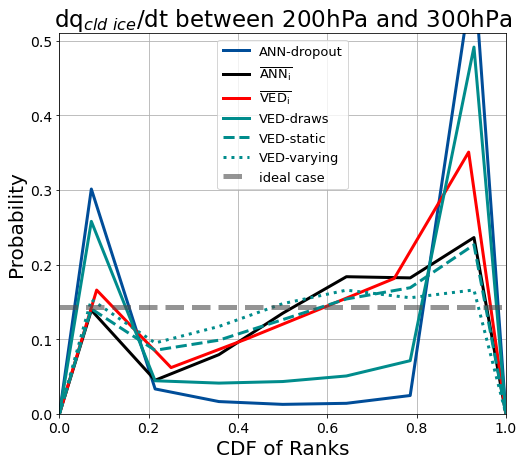

In [4]:
plt.figure(1,(8,7))
plt.title(r'dq$_{cld \ ice}$/dt between 200hPa and 300hPa',fontsize=23)

plt.plot(np.hstack((0,ANN_lin_dr_0_01CLDICBCTEND['pit_centers'],1)),np.hstack((0,ANN_lin_dr_0_01CLDICBCTEND['pit_counts'],0)),
         color=[0,0.3,0.6],linewidth=3,label='ANN-dropout')
plt.plot(np.hstack((0,deter_7_lin_CLDICBCTEND['pit_centers'],1)),np.hstack((0,deter_7_lin_CLDICBCTEND['pit_counts'],0))
         ,color='k',linewidth=3,label=r'$\mathrm{\overline{ANN_i}}$')
plt.plot(np.hstack((0,deter_6_VED_CLDICBCTEND['pit_centers'],1)),np.hstack((0,deter_6_VED_CLDICBCTEND['pit_counts'],0)),
         color='r',linewidth=3,label=r'$\mathrm{\overline{VED_i}}$')
plt.plot(np.hstack((0,VED_1_7_0_0_CLDICBCTEND['pit_centers'],1)),
         np.hstack((0,VED_1_7_0_0_CLDICBCTEND['pit_counts'],0)),color=[0,0.55,0.55],linewidth=3,label=r'VED-draws')

plt.plot(np.hstack((0,VED_1_7_0_5_CLDICBCTEND['pit_centers'],1)),
         np.hstack((0,VED_1_7_0_5_CLDICBCTEND['pit_counts'],0)),'--',color=[0,0.55,0.55],linewidth=3,label=r'VED-static')
plt.plot(np.hstack((0,VED_1_7_alpha_CLDICBCTEND['pit_centers'],1)),
         np.hstack((0,VED_1_7_alpha_CLDICBCTEND['pit_counts'],0)),linewidth=3,linestyle=':',color=[0,0.55,0.55],label=r'VED-varying')




plt.hlines(1/7,0,1,linestyle='--',linewidth=5,colors=[[0.3,0.3,0.3,0.6]],label='ideal case')



plt.grid(True)
plt.ylim(0,0.51)
plt.xlim(0,1)
plt.xlabel('CDF of Ranks',fontsize=20)
plt.legend(fontsize=13)
plt.ylabel('Probability',fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

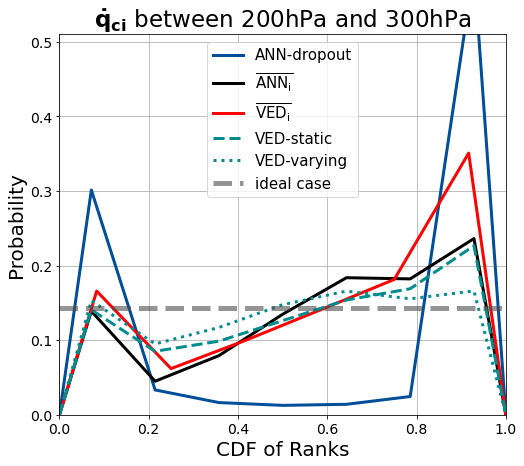

In [17]:
plt.figure(1,(8,7))
plt.title(r'$\mathbf{\dot{q}_{ci}}$ between 200hPa and 300hPa',fontsize=23)

plt.plot(np.hstack((0,ANN_lin_dr_0_01CLDICBCTEND['pit_centers'],1)),np.hstack((0,ANN_lin_dr_0_01CLDICBCTEND['pit_counts'],0)),
         color=[0,0.3,0.6],linewidth=3,label='ANN-dropout')
plt.plot(np.hstack((0,deter_7_lin_CLDICBCTEND['pit_centers'],1)),np.hstack((0,deter_7_lin_CLDICBCTEND['pit_counts'],0))
         ,color='k',linewidth=3,label=r'$\mathrm{\overline{ANN_i}}$')
plt.plot(np.hstack((0,deter_6_VED_CLDICBCTEND['pit_centers'],1)),np.hstack((0,deter_6_VED_CLDICBCTEND['pit_counts'],0)),
         color='r',linewidth=3,label=r'$\mathrm{\overline{VED_i}}$')
#plt.plot(np.hstack((0,VED_1_7_0_0_CLDICBCTEND['pit_centers'],1)),
#         np.hstack((0,VED_1_7_0_0_CLDICBCTEND['pit_counts'],0)),color=[0,0.55,0.55],linewidth=3,label=r'VED-draws')

plt.plot(np.hstack((0,VED_1_7_0_5_CLDICBCTEND['pit_centers'],1)),
         np.hstack((0,VED_1_7_0_5_CLDICBCTEND['pit_counts'],0)),'--',color=[0,0.55,0.55],linewidth=3,label=r'VED-static')
plt.plot(np.hstack((0,VED_1_7_alpha_CLDICBCTEND['pit_centers'],1)),
         np.hstack((0,VED_1_7_alpha_CLDICBCTEND['pit_counts'],0)),linewidth=3,linestyle=':',color=[0,0.55,0.55],label=r'VED-varying')




plt.hlines(1/7,0,1,linestyle='--',linewidth=5,colors=[[0.3,0.3,0.3,0.6]],label='ideal case')



plt.grid(True)
plt.ylim(0,0.51)
plt.xlim(0,1)
plt.xlabel('CDF of Ranks',fontsize=20)
plt.legend(fontsize=15)
plt.ylabel('Probability',fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

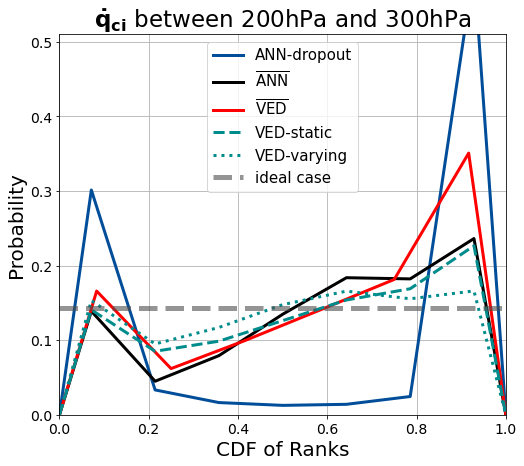

In [3]:
plt.figure(1,(8,7))
plt.title(r'$\mathbf{\dot{q}_{ci}}$ between 200hPa and 300hPa',fontsize=23)

plt.plot(np.hstack((0,ANN_lin_dr_0_01CLDICBCTEND['pit_centers'],1)),np.hstack((0,ANN_lin_dr_0_01CLDICBCTEND['pit_counts'],0)),
         color=[0,0.3,0.6],linewidth=3,label='ANN-dropout')
plt.plot(np.hstack((0,deter_7_lin_CLDICBCTEND['pit_centers'],1)),np.hstack((0,deter_7_lin_CLDICBCTEND['pit_counts'],0))
         ,color='k',linewidth=3,label=r'$\mathrm{\overline{ANN}}$')
plt.plot(np.hstack((0,deter_6_VED_CLDICBCTEND['pit_centers'],1)),np.hstack((0,deter_6_VED_CLDICBCTEND['pit_counts'],0)),
         color='r',linewidth=3,label=r'$\mathrm{\overline{VED}}$')
#plt.plot(np.hstack((0,VED_1_7_0_0_CLDICBCTEND['pit_centers'],1)),
#         np.hstack((0,VED_1_7_0_0_CLDICBCTEND['pit_counts'],0)),color=[0,0.55,0.55],linewidth=3,label=r'VED-draws')

plt.plot(np.hstack((0,VED_1_7_0_5_CLDICBCTEND['pit_centers'],1)),
         np.hstack((0,VED_1_7_0_5_CLDICBCTEND['pit_counts'],0)),'--',color=[0,0.55,0.55],linewidth=3,label=r'VED-static')
plt.plot(np.hstack((0,VED_1_7_alpha_CLDICBCTEND['pit_centers'],1)),
         np.hstack((0,VED_1_7_alpha_CLDICBCTEND['pit_counts'],0)),linewidth=3,linestyle=':',color=[0,0.55,0.55],label=r'VED-varying')




plt.hlines(1/7,0,1,linestyle='--',linewidth=5,colors=[[0.3,0.3,0.3,0.6]],label='ideal case')



plt.grid(True)
plt.ylim(0,0.51)
plt.xlim(0,1)
plt.xlabel('CDF of Ranks',fontsize=20)
plt.legend(fontsize=15)
plt.ylabel('Probability',fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

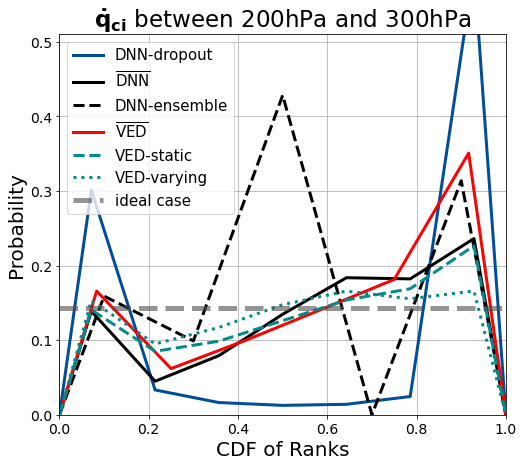

In [87]:
plt.figure(1,(8,7))
plt.title(r'$\mathbf{\dot{q}_{ci}}$ between 200hPa and 300hPa',fontsize=23)

plt.plot(np.hstack((0,ANN_lin_dr_0_01CLDICBCTEND['pit_centers'],1)),np.hstack((0,ANN_lin_dr_0_01CLDICBCTEND['pit_counts'],0)),
         color=[0,0.3,0.6],linewidth=3,label='DNN-dropout')
plt.plot(np.hstack((0,deter_7_lin_CLDICBCTEND['pit_centers'],1)),np.hstack((0,deter_7_lin_CLDICBCTEND['pit_counts'],0))
         ,color='k',linewidth=3,label=r'$\mathrm{\overline{DNN}}$')
plt.plot(np.hstack((0,stoch_5_lin_CLDICBCTEND['pit_centers'],1)),np.hstack((0,stoch_5_lin_CLDICBCTEND['pit_counts'],0))
         ,'--',color='k',linewidth=3,label=r'DNN-ensemble')

plt.plot(np.hstack((0,deter_6_VED_CLDICBCTEND['pit_centers'],1)),np.hstack((0,deter_6_VED_CLDICBCTEND['pit_counts'],0)),
         color='r',linewidth=3,label=r'$\mathrm{\overline{VED}}$')
#plt.plot(np.hstack((0,VED_1_7_0_0_CLDICBCTEND['pit_centers'],1)),
#         np.hstack((0,VED_1_7_0_0_CLDICBCTEND['pit_counts'],0)),color=[0,0.55,0.55],linewidth=3,label=r'VED-draws')

plt.plot(np.hstack((0,VED_1_7_0_5_CLDICBCTEND['pit_centers'],1)),
         np.hstack((0,VED_1_7_0_5_CLDICBCTEND['pit_counts'],0)),'--',color=[0,0.55,0.55],linewidth=3,label=r'VED-static')
plt.plot(np.hstack((0,VED_1_7_alpha_CLDICBCTEND['pit_centers'],1)),
         np.hstack((0,VED_1_7_alpha_CLDICBCTEND['pit_counts'],0)),linewidth=3,linestyle=':',color=[0,0.55,0.55],label=r'VED-varying')




plt.hlines(1/7,0,1,linestyle='--',linewidth=5,colors=[[0.3,0.3,0.3,0.6]],label='ideal case')



plt.grid(True)
plt.ylim(0,0.51)
plt.xlim(0,1)
plt.xlabel('CDF of Ranks',fontsize=20)
plt.legend(fontsize=15)
plt.ylabel('Probability',fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

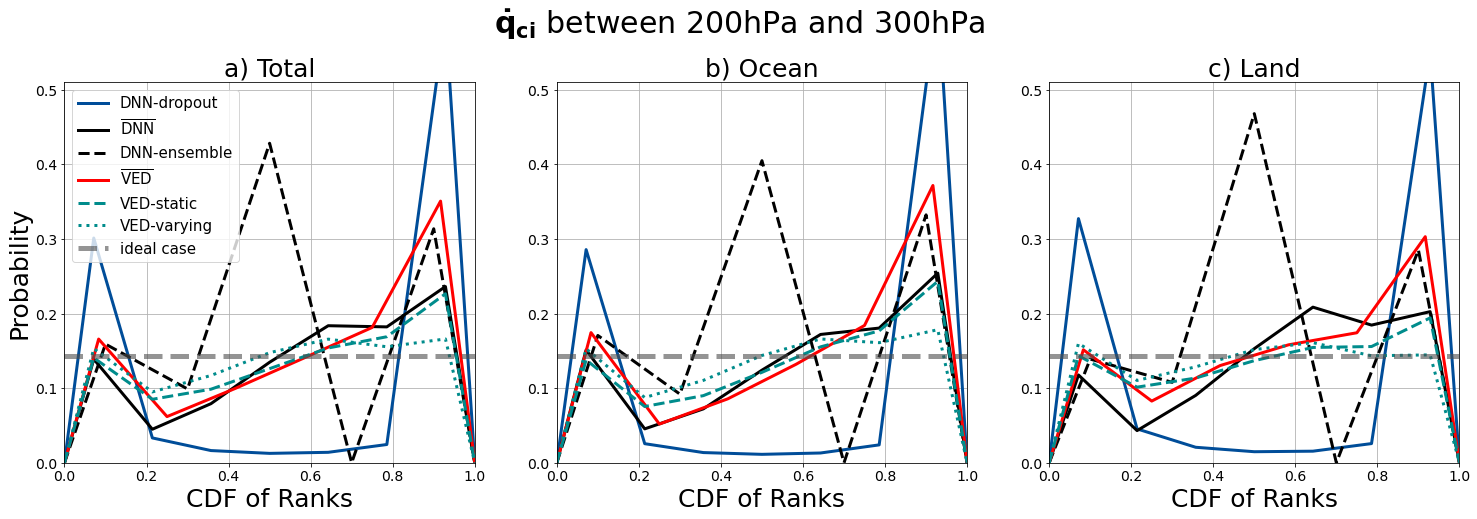

In [65]:
plt.figure(1,(25,7))
plt.suptitle(r'$\mathbf{\dot{q}_{ci}}$ between 200hPa and 300hPa',fontsize=30,y=1.03)

plt.subplot(1,3,1)
plt.title('a) Total', fontsize=25)
plt.plot(np.hstack((0,ANN_lin_dr_0_01CLDICBCTEND['pit_centers'],1)),np.hstack((0,ANN_lin_dr_0_01CLDICBCTEND['pit_counts'],0)),
         color=[0,0.3,0.6],linewidth=3,label='DNN-dropout')
plt.plot(np.hstack((0,deter_7_lin_CLDICBCTEND['pit_centers'],1)),np.hstack((0,deter_7_lin_CLDICBCTEND['pit_counts'],0))
         ,color='k',linewidth=3,label=r'$\mathrm{\overline{DNN}}$')
plt.plot(np.hstack((0,stoch_5_lin_CLDICBCTEND['pit_centers'],1)),np.hstack((0,stoch_5_lin_CLDICBCTEND['pit_counts'],0))
         ,'--',color='k',linewidth=3,label=r'DNN-ensemble')

plt.plot(np.hstack((0,deter_6_VED_CLDICBCTEND['pit_centers'],1)),np.hstack((0,deter_6_VED_CLDICBCTEND['pit_counts'],0)),
         color='r',linewidth=3,label=r'$\mathrm{\overline{VED}}$')
#plt.plot(np.hstack((0,VED_1_7_0_0_CLDICBCTEND['pit_centers'],1)),
#         np.hstack((0,VED_1_7_0_0_CLDICBCTEND['pit_counts'],0)),color=[0,0.55,0.55],linewidth=3,label=r'VED-draws')

plt.plot(np.hstack((0,VED_1_7_0_5_CLDICBCTEND['pit_centers'],1)),
         np.hstack((0,VED_1_7_0_5_CLDICBCTEND['pit_counts'],0)),'--',color=[0,0.55,0.55],linewidth=3,label=r'VED-static')
plt.plot(np.hstack((0,VED_1_7_alpha_CLDICBCTEND['pit_centers'],1)),
         np.hstack((0,VED_1_7_alpha_CLDICBCTEND['pit_counts'],0)),linewidth=3,linestyle=':',color=[0,0.55,0.55],label=r'VED-varying')




plt.hlines(1/7,0,1,linestyle='--',linewidth=5,colors=[[0.3,0.3,0.3,0.6]],label='ideal case')



plt.grid(True)
plt.ylim(0,0.51)
plt.xlim(0,1)
plt.xlabel('CDF of Ranks',fontsize=25)
plt.legend(fontsize=15,loc=2)
plt.ylabel('Probability',fontsize=25)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(1,3,2)
plt.title('b) Ocean', fontsize=25)
plt.plot(np.hstack((0,ANN_lin_dr_0_01CLDICBCTEND_ocean['pit_centers'],1)),np.hstack((0,ANN_lin_dr_0_01CLDICBCTEND_ocean['pit_counts'],0)),
         color=[0,0.3,0.6],linewidth=3,label='DNN-dropout')
plt.plot(np.hstack((0,deter_7_lin_CLDICBCTEND_ocean['pit_centers'],1)),np.hstack((0,deter_7_lin_CLDICBCTEND_ocean['pit_counts'],0))
         ,color='k',linewidth=3,label=r'$\mathrm{\overline{DNN}}$')
plt.plot(np.hstack((0,stoch_5_lin_CLDICBCTEND_ocean['pit_centers'],1)),np.hstack((0,stoch_5_lin_CLDICBCTEND_ocean['pit_counts'],0))
         ,'--',color='k',linewidth=3,label=r'DNN-ensemble')

plt.plot(np.hstack((0,deter_6_VED_CLDICBCTEND_ocean['pit_centers'],1)),np.hstack((0,deter_6_VED_CLDICBCTEND_ocean['pit_counts'],0)),
         color='r',linewidth=3,label=r'$\mathrm{\overline{VED}}$')
#plt.plot(np.hstack((0,VED_1_7_0_0_CLDICBCTEND['pit_centers'],1)),
#         np.hstack((0,VED_1_7_0_0_CLDICBCTEND['pit_counts'],0)),color=[0,0.55,0.55],linewidth=3,label=r'VED-draws')

plt.plot(np.hstack((0,VED_1_7_0_5_CLDICBCTEND_ocean['pit_centers'],1)),
         np.hstack((0,VED_1_7_0_5_CLDICBCTEND_ocean['pit_counts'],0)),'--',color=[0,0.55,0.55],linewidth=3,label=r'VED-static')
plt.plot(np.hstack((0,VED_1_7_alpha_CLDICBCTEND_ocean['pit_centers'],1)),
         np.hstack((0,VED_1_7_alpha_CLDICBCTEND_ocean['pit_counts'],0)),linewidth=3,linestyle=':',color=[0,0.55,0.55],label=r'VED-varying')




plt.hlines(1/7,0,1,linestyle='--',linewidth=5,colors=[[0.3,0.3,0.3,0.6]],label='ideal case')



plt.grid(True)
plt.ylim(0,0.51)
plt.xlim(0,1)
plt.xlabel('CDF of Ranks',fontsize=25)
#plt.legend(fontsize=15)
#plt.ylabel('Probability',fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(1,3,3)
plt.title('c) Land', fontsize=25)
plt.plot(np.hstack((0,ANN_lin_dr_0_01CLDICBCTEND_land['pit_centers'],1)),np.hstack((0,ANN_lin_dr_0_01CLDICBCTEND_land['pit_counts'],0)),
         color=[0,0.3,0.6],linewidth=3,label='DNN-dropout')
plt.plot(np.hstack((0,deter_7_lin_CLDICBCTEND_land['pit_centers'],1)),np.hstack((0,deter_7_lin_CLDICBCTEND_land['pit_counts'],0))
         ,color='k',linewidth=3,label=r'$\mathrm{\overline{DNN}}$')
plt.plot(np.hstack((0,stoch_5_lin_CLDICBCTEND_land['pit_centers'],1)),np.hstack((0,stoch_5_lin_CLDICBCTEND_land['pit_counts'],0))
         ,'--',color='k',linewidth=3,label=r'DNN-ensemble')

plt.plot(np.hstack((0,deter_6_VED_CLDICBCTEND_land['pit_centers'],1)),np.hstack((0,deter_6_VED_CLDICBCTEND_land['pit_counts'],0)),
         color='r',linewidth=3,label=r'$\mathrm{\overline{VED}}$')
#plt.plot(np.hstack((0,VED_1_7_0_0_CLDICBCTEND['pit_centers'],1)),
#         np.hstack((0,VED_1_7_0_0_CLDICBCTEND['pit_counts'],0)),color=[0,0.55,0.55],linewidth=3,label=r'VED-draws')

plt.plot(np.hstack((0,VED_1_7_0_5_CLDICBCTEND_land['pit_centers'],1)),
         np.hstack((0,VED_1_7_0_5_CLDICBCTEND_land['pit_counts'],0)),'--',color=[0,0.55,0.55],linewidth=3,label=r'VED-static')
plt.plot(np.hstack((0,VED_1_7_alpha_CLDICBCTEND_land['pit_centers'],1)),
         np.hstack((0,VED_1_7_alpha_CLDICBCTEND_land['pit_counts'],0)),linewidth=3,linestyle=':',color=[0,0.55,0.55],label=r'VED-varying')




plt.hlines(1/7,0,1,linestyle='--',linewidth=5,colors=[[0.3,0.3,0.3,0.6]],label='ideal case')



plt.grid(True)
plt.ylim(0,0.51)
plt.xlim(0,1)
plt.xlabel('CDF of Ranks',fontsize=25)
#plt.legend(fontsize=15)
#plt.ylabel('Probability',fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)




# $\dot{q}_{cl}$ in the planetary boundary layer


In [38]:
hPa_831=np.array([22,23])# pressure levels 831 hPa to 903 hPa
P[hPa_831]

<xarray.DataArray (ilev: 2)>
array([83102.123, 90330.029])
Coordinates:
  * ilev     (ilev) float64 831.0 903.3

In [46]:
def cldliq_sum_calc(Network_1,Network_2,Network_3,Network_4,Network_5,Network_6,Network_7,data_set,time_steps,below_certain_p_level,region):
    """
    compute sum of \dot{q}_cl in the planetary boundary layer for the multi-ANN ensemble  
    """
    if (below_certain_p_level[:-1]+52>77 or below_certain_p_level[0]+52<52):
        print("Outside of range!!!!")
    
    rand_time_step=np.random.choice(data_set.n_batches,time_steps,replace=False)

    cloud_liq_true=np.nan*np.zeros((time_steps,region.size))
   
    cloud_liq_bc_pred_7=np.nan*np.zeros((time_steps,region.size,7))

    cloud_liq_bc_true=np.nan*np.zeros((time_steps,region.size))
    
    cloud_liq_bc_pred=np.nan*np.zeros((region.size,7))
    
    
    for i in tqdm(np.arange(time_steps)):
        cloud_liq_bc_true[i]=np.sum(to.from_numpy(data_set.output_transform.inverse_transform(data_set[rand_time_step[i]][1])[:,below_certain_p_level+78]).detach().numpy()[region],1)
        cloud_liq_bc_pred[:,0]=np.sum((data_set.output_transform.inverse_transform(Network_1(to.from_numpy(data_set[rand_time_step[i]][0])).detach().numpy())[:,below_certain_p_level+52])[region],1)
        cloud_liq_bc_pred[:,1]=np.sum((data_set.output_transform.inverse_transform(Network_2(to.from_numpy(data_set[rand_time_step[i]][0])).detach().numpy())[:,below_certain_p_level+52])[region],1)
        cloud_liq_bc_pred[:,2]=np.sum((data_set.output_transform.inverse_transform(Network_3(to.from_numpy(data_set[rand_time_step[i]][0])).detach().numpy())[:,below_certain_p_level+52])[region],1)
        cloud_liq_bc_pred[:,3]=np.sum((data_set.output_transform.inverse_transform(Network_4(to.from_numpy(data_set[rand_time_step[i]][0])).detach().numpy())[:,below_certain_p_level+52])[region],1)
        cloud_liq_bc_pred[:,4]=np.sum((data_set.output_transform.inverse_transform(Network_5(to.from_numpy(data_set[rand_time_step[i]][0])).detach().numpy())[:,below_certain_p_level+52])[region],1)
        cloud_liq_bc_pred[:,5]=np.sum((data_set.output_transform.inverse_transform(Network_6(to.from_numpy(data_set[rand_time_step[i]][0])).detach().numpy())[:,below_certain_p_level+52])[region],1)
        cloud_liq_bc_pred[:,6]=np.sum((data_set.output_transform.inverse_transform(Network_7(to.from_numpy(data_set[rand_time_step[i]][0])).detach().numpy())[:,below_certain_p_level+52])[region],1)

        




        
        cloud_liq_bc_pred_7[i]=cloud_liq_bc_pred
        
        
        
   
    cloud_liq_bc_pred_7=np.reshape(cloud_liq_bc_pred_7,(int(time_steps*region.size),7))
    cloud_liq_bc_true=np.reshape(cloud_liq_bc_true,(int(time_steps*region.size),1))


    
    return cloud_liq_bc_true,cloud_liq_bc_pred_7



In [44]:
def cldliq_sum_calc_stoch(Network_1,Network_2,Network_3,Network_4,Network_5,Network_6,Network_7,data_set,time_steps,below_certain_p_level,region):
    """
    compute sum of \dot{q}_cl in the planetary boundary layer for the multi-ANN ensemble  
    """
    if (below_certain_p_level[:-1]+52>77 or below_certain_p_level[0]+52<52):
        print("Outside of range!!!!")
    
    rand_time_step=np.random.choice(data_set.n_batches,time_steps,replace=False)

    cloud_liq_true=np.nan*np.zeros((time_steps,region.size))
   
    cloud_liq_bc_pred_5=np.nan*np.zeros((time_steps,region.size,7))

    cloud_liq_bc_true=np.nan*np.zeros((time_steps,region.size))
    
    cloud_liq_bc_pred=np.nan*np.zeros((region.size,7))
    cloud_liq_bc_pred_5_stoch=np.nan*np.zeros((time_steps,region.size,5))
    ens_2=np.nan*np.zeros((region.size,5))
    
    for i in tqdm(np.arange(time_steps)):
        cloud_liq_bc_true[i]=np.sum(to.from_numpy(data_set.output_transform.inverse_transform(data_set[rand_time_step[i]][1])[:,below_certain_p_level+78]).detach().numpy()[region],1)
        cloud_liq_bc_pred[:,0]=np.sum((data_set.output_transform.inverse_transform(Network_1(to.from_numpy(data_set[rand_time_step[i]][0])).detach().numpy())[:,below_certain_p_level+52])[region],1)
        cloud_liq_bc_pred[:,1]=np.sum((data_set.output_transform.inverse_transform(Network_2(to.from_numpy(data_set[rand_time_step[i]][0])).detach().numpy())[:,below_certain_p_level+52])[region],1)
        cloud_liq_bc_pred[:,2]=np.sum((data_set.output_transform.inverse_transform(Network_3(to.from_numpy(data_set[rand_time_step[i]][0])).detach().numpy())[:,below_certain_p_level+52])[region],1)
        cloud_liq_bc_pred[:,3]=np.sum((data_set.output_transform.inverse_transform(Network_4(to.from_numpy(data_set[rand_time_step[i]][0])).detach().numpy())[:,below_certain_p_level+52])[region],1)
        cloud_liq_bc_pred[:,4]=np.sum((data_set.output_transform.inverse_transform(Network_5(to.from_numpy(data_set[rand_time_step[i]][0])).detach().numpy())[:,below_certain_p_level+52])[region],1)
        cloud_liq_bc_pred[:,5]=np.sum((data_set.output_transform.inverse_transform(Network_6(to.from_numpy(data_set[rand_time_step[i]][0])).detach().numpy())[:,below_certain_p_level+52])[region],1)
        cloud_liq_bc_pred[:,6]=np.sum((data_set.output_transform.inverse_transform(Network_7(to.from_numpy(data_set[rand_time_step[i]][0])).detach().numpy())[:,below_certain_p_level+52])[region],1)

        




        for j in np.arange(region.size):
                stoch_ens=np.random.choice(7,5,replace=False)
                #print(stoch_ens)
                ens_2[j,:]=cloud_liq_bc_pred[j,stoch_ens]
        
        
        
        
        cloud_liq_bc_pred_5_stoch[i]=ens_2
        
        
        
    
    cloud_liq_bc_pred_5=np.reshape(cloud_liq_bc_pred_5_stoch,(int(time_steps*region.size),5))
    cloud_liq_bc_true=np.reshape(cloud_liq_bc_true,(int(time_steps*region.size),1))


    
    return cloud_liq_bc_true,cloud_liq_bc_pred_5


In [47]:
# compute cloud liquid tendency sum for \overline{ANN}

cloud_liq_tend_ANN_lin,mem_7_liq_ANN_lin=cldliq_sum_calc(ANN_1_lin,ANN_2_lin,
                                                         ANN_3_lin,ANN_4_lin,
                                                         ANN_5_lin,ANN_6_lin,ANN_7_lin,
                                                         val_gen_II,400,hPa_831,np.arange(latit_array.size))

                                                                           
                                                                                             

                                                                           

  0%|          | 0/400 [00:00<?, ?it/s]

In [48]:
# compute cloud liquid tendency sum for \overline{ANN}

cloud_liq_tend_ANN_lin_1,mem_5_liq_ANN_lin=cldliq_sum_calc_stoch(ANN_1_lin,ANN_2_lin,
                                                         ANN_3_lin,ANN_4_lin,
                                                         ANN_5_lin,ANN_6_lin,ANN_7_lin,
                                                         val_gen_II,400,hPa_831,np.arange(latit_array.size))

                                                                           
                                                                                             

                                                                           

  0%|          | 0/400 [00:00<?, ?it/s]

In [49]:
def cldliq_sum_calc_ANN_single_dr(Network_1,data_set,time_steps,below_certain_p_level,region):
    
    if (below_certain_p_level[:-1]+52>77 or below_certain_p_level[0]+52<52):
        print("Outside of range!!!!")
    
    rand_time_step=np.random.choice(data_set.n_batches,time_steps,replace=False)

    cloud_liq_true=np.nan*np.zeros((time_steps,region.size))
   
    cloud_liq_bc_pred_7=np.nan*np.zeros((time_steps,region.size,7))

    cloud_liq_bc_true=np.nan*np.zeros((time_steps,region.size))
    
    cloud_liq_bc_pred=np.nan*np.zeros((region.size,7))
    
    
    for i in tqdm(np.arange(time_steps)):
        cloud_liq_bc_true[i]=np.sum(to.from_numpy(data_set.output_transform.inverse_transform(data_set[rand_time_step[i]][1])[:,below_certain_p_level+78]).detach().numpy()[region],1)
        cloud_liq_bc_pred[:,0]=np.sum((data_set.output_transform.inverse_transform(Network_1(to.from_numpy(data_set[rand_time_step[i]][0])).detach().numpy())[:,below_certain_p_level+52])[region],1)
        cloud_liq_bc_pred[:,1]=np.sum((data_set.output_transform.inverse_transform(Network_1(to.from_numpy(data_set[rand_time_step[i]][0])).detach().numpy())[:,below_certain_p_level+52])[region],1)
        cloud_liq_bc_pred[:,2]=np.sum((data_set.output_transform.inverse_transform(Network_1(to.from_numpy(data_set[rand_time_step[i]][0])).detach().numpy())[:,below_certain_p_level+52])[region],1)
        cloud_liq_bc_pred[:,3]=np.sum((data_set.output_transform.inverse_transform(Network_1(to.from_numpy(data_set[rand_time_step[i]][0])).detach().numpy())[:,below_certain_p_level+52])[region],1)
        cloud_liq_bc_pred[:,4]=np.sum((data_set.output_transform.inverse_transform(Network_1(to.from_numpy(data_set[rand_time_step[i]][0])).detach().numpy())[:,below_certain_p_level+52])[region],1)
        cloud_liq_bc_pred[:,5]=np.sum((data_set.output_transform.inverse_transform(Network_1(to.from_numpy(data_set[rand_time_step[i]][0])).detach().numpy())[:,below_certain_p_level+52])[region],1)
        cloud_liq_bc_pred[:,6]=np.sum((data_set.output_transform.inverse_transform(Network_1(to.from_numpy(data_set[rand_time_step[i]][0])).detach().numpy())[:,below_certain_p_level+52])[region],1)

       
        cloud_liq_bc_pred_7[i]=cloud_liq_bc_pred
        
        
        
    
    cloud_liq_bc_pred_7=np.reshape(cloud_liq_bc_pred_7,(int(time_steps*region.size),7))
    cloud_liq_bc_true=np.reshape(cloud_liq_bc_true,(int(time_steps*region.size),1))


    
    return cloud_liq_bc_true,cloud_liq_bc_pred_7



In [50]:
# the same for ANN-dropout 
cloud_liq_tend_dr_ANN_1_lin_7,mem_7_liq_dr_ANN_1_lin_7=cldliq_sum_calc_ANN_single_dr(ANN_1_lin_dr_0_01,
                                                            val_gen_II,400,hPa_831,np.arange(latit_array.size))


  0%|          | 0/400 [00:00<?, ?it/s]

In [51]:
def VED_cldliq_sum_calc(Dec_1,Dec_2,Dec_3,Dec_4,Dec_5,Dec_6,Enc_1,Enc_2,Enc_3,Enc_4,Enc_5,Enc_6,data_set,time_steps,below_certain_p_level,region):
    """
    compute cloud liq tend sum in planetary boundary layer for \overline{VED}
    """
    
    rand_time_step=np.random.choice(data_set.n_batches,time_steps,replace=False)

    cloud_ice_true=np.nan*np.zeros((time_steps,region.size))
    
    cloud_ice_bc_pred_6=np.nan*np.zeros((time_steps,region.size,6))

    cloud_ice_bc_true=np.nan*np.zeros((time_steps,region.size))
    
    cloud_ice_bc_pred=np.nan*np.zeros((region.size,6))
    
    
    for i in tqdm(np.arange(time_steps)):
        cloud_ice_bc_true[i]=np.sum(to.from_numpy(data_set.output_transform.inverse_transform(data_set[rand_time_step[i]][1])[:,below_certain_p_level+52]).detach().numpy()[region],1)
        cloud_ice_bc_pred[:,0]=np.sum((data_set.output_transform.inverse_transform(Dec_1(Enc_1(to.from_numpy(data_set[rand_time_step[i]][0]))).detach().numpy())[:,below_certain_p_level+52])[region],1)
        cloud_ice_bc_pred[:,1]=np.sum((data_set.output_transform.inverse_transform(Dec_2(Enc_2(to.from_numpy(data_set[rand_time_step[i]][0]))).detach().numpy())[:,below_certain_p_level+52])[region],1)
        cloud_ice_bc_pred[:,2]=np.sum((data_set.output_transform.inverse_transform(Dec_3(Enc_3(to.from_numpy(data_set[rand_time_step[i]][0]))).detach().numpy())[:,below_certain_p_level+52])[region],1)
        cloud_ice_bc_pred[:,3]=np.sum((data_set.output_transform.inverse_transform(Dec_4(Enc_4(to.from_numpy(data_set[rand_time_step[i]][0]))).detach().numpy())[:,below_certain_p_level+52])[region],1)
        cloud_ice_bc_pred[:,4]=np.sum((data_set.output_transform.inverse_transform(Dec_5(Enc_5(to.from_numpy(data_set[rand_time_step[i]][0]))).detach().numpy())[:,below_certain_p_level+52])[region],1)
        cloud_ice_bc_pred[:,5]=np.sum((data_set.output_transform.inverse_transform(Dec_6(Enc_6(to.from_numpy(data_set[rand_time_step[i]][0]))).detach().numpy())[:,below_certain_p_level+52])[region],1)

        



       
        cloud_ice_bc_pred_6[i]=cloud_ice_bc_pred
        
        
        
    
    cloud_ice_bc_pred_6=np.reshape(cloud_ice_bc_pred_6,(int(time_steps*region.size),6))
    cloud_ice_bc_true=np.reshape(cloud_ice_bc_true,(int(time_steps*region.size),1))


    
    return cloud_ice_bc_true,cloud_ice_bc_pred_6


In [52]:
cloud_liq_tend_VED,VED_mem_6_liq=VED_cldliq_sum_calc(VDec_1,VDec_2,
                                                    VDec_3,VDec_4,
                                                    VDec_5,VDec_7,
                                                    VEnc_1,VEnc_2,
                                                    VEnc_3,VEnc_4,
                                                    VEnc_5,VEnc_7,
                                                    val_gen_III,400,hPa_831,np.arange(latit_array.size))

  0%|          | 0/400 [00:00<?, ?it/s]

In [53]:
def VED_cldliq_sum_calc_internal_stoch(VDecoder,VEncoder,data_set,time_steps,below_certain_p_level,region,noise_level,network_number):
    
    """
    compute cloud liq tend sum in planetary boundary layer for ensemble with isotropic laten space manipulation
    """
    
    rand_time_step=np.random.choice(data_set.n_batches,time_steps,replace=False)

    cloud_ice_true=np.nan*np.zeros((time_steps,region.size))
    
    cloud_ice_bc_pred_7=np.nan*np.zeros((time_steps,region.size,7))

    cloud_ice_bc_true=np.nan*np.zeros((time_steps,region.size))
    
    cloud_ice_bc_pred=np.nan*np.zeros((region.size,7))
    st_norm_perturb=np.nan*np.zeros((network_number,region.size,VEncoder.z_log_var.weight.size()[0]))

    
    for i in tqdm(np.arange(time_steps)):
        st_norm_perturb=to.from_numpy(np.random.standard_normal((st_norm_perturb.shape)))

        cloud_ice_bc_true[i]=np.sum(to.from_numpy(data_set.output_transform.inverse_transform(data_set[rand_time_step[i]][1])[:,below_certain_p_level+52]).detach().numpy()[region],1)
        cloud_ice_bc_pred[:,0]=np.sum((data_set.output_transform.inverse_transform(VDecoder(to.add(VEncoder(to.from_numpy(data_set[rand_time_step[i]][0]).float()),st_norm_perturb[0],alpha=noise_level).float()).detach().numpy())[:,below_certain_p_level+52])[region],1)
        cloud_ice_bc_pred[:,1]=np.sum((data_set.output_transform.inverse_transform(VDecoder(to.add(VEncoder(to.from_numpy(data_set[rand_time_step[i]][0]).float()),st_norm_perturb[1],alpha=noise_level).float()).detach().numpy())[:,below_certain_p_level+52])[region],1)
        cloud_ice_bc_pred[:,2]=np.sum((data_set.output_transform.inverse_transform(VDecoder(to.add(VEncoder(to.from_numpy(data_set[rand_time_step[i]][0]).float()),st_norm_perturb[2],alpha=noise_level).float()).detach().numpy())[:,below_certain_p_level+52])[region],1)
        cloud_ice_bc_pred[:,3]=np.sum((data_set.output_transform.inverse_transform(VDecoder(to.add(VEncoder(to.from_numpy(data_set[rand_time_step[i]][0]).float()),st_norm_perturb[3],alpha=noise_level).float()).detach().numpy())[:,below_certain_p_level+52])[region],1)
        cloud_ice_bc_pred[:,4]=np.sum((data_set.output_transform.inverse_transform(VDecoder(to.add(VEncoder(to.from_numpy(data_set[rand_time_step[i]][0]).float()),st_norm_perturb[4],alpha=noise_level).float()).detach().numpy())[:,below_certain_p_level+52])[region],1)
        cloud_ice_bc_pred[:,5]=np.sum((data_set.output_transform.inverse_transform(VDecoder(to.add(VEncoder(to.from_numpy(data_set[rand_time_step[i]][0]).float()),st_norm_perturb[5],alpha=noise_level).float()).detach().numpy())[:,below_certain_p_level+52])[region],1)
        cloud_ice_bc_pred[:,6]=np.sum((data_set.output_transform.inverse_transform(VDecoder(to.add(VEncoder(to.from_numpy(data_set[rand_time_step[i]][0]).float()),st_norm_perturb[6],alpha=noise_level).float()).detach().numpy())[:,below_certain_p_level+52])[region],1)
        
       
        stoch_ens_6=np.random.choice(7,6,replace=False)




        
        cloud_ice_bc_pred_7[i]=cloud_ice_bc_pred
        
        
        
    
    cloud_ice_bc_pred_7=np.reshape(cloud_ice_bc_pred_7,(int(time_steps*region.size),7))
    cloud_ice_bc_true=np.reshape(cloud_ice_bc_true,(int(time_steps*region.size),1))


    
    return cloud_ice_bc_true,cloud_ice_bc_pred_7


In [54]:
#\dot{q}_cl for VED-draws
cloud_liq_tend_VED_1_7_0,VED_1_7_0_mem_7_liq=VED_cldliq_sum_calc_internal_stoch(VDec_1,VEnc_1,
                                                    val_gen_III,400,hPa_831,np.arange(latit_array.size),0.0,7)

  0%|          | 0/400 [00:00<?, ?it/s]

In [55]:
#\dot{q}_cl for VED-static

cloud_liq_tend_VED_1_7_0_5,VED_1_7_0_5_mem_7_liq=VED_cldliq_sum_calc_internal_stoch(VDec_1,VEnc_1,
                                                    val_gen_III,400,hPa_831,np.arange(latit_array.size),0.5,7)

  0%|          | 0/400 [00:00<?, ?it/s]

In [56]:
#\dot{q}_cl for VED-varying

cloud_liq_tend_VED_alpha_arr_1,VED_liq_1_7_7_alpha_arr_1=VED_cldice_sum_calc_internal_stoch_alpha_sens(VDec_1,VEnc_1,
                                                                                                       val_gen_III,400,
                                                                                                       hPa_831+52,
                                                                                                       np.arange(latit_array.size),
                                                                                                       np.load('alpha_arrs/alpha_1.npy'),
                                                                                                                     7)              
                                                                                                                        
                                                                                                                               




  0%|          | 0/400 [00:00<?, ?it/s]

In [ ]:
#compute PIT histograms for all ensembles 

a_lin=get_pit_points_ens(cloud_liq_tend_ANN_lin,mem_7_liq_ANN_lin,pit_bins=np.arange(0,1.1,1/7))
b_lin=get_pit_points_ens(cloud_liq_tend_dr_ANN_1_lin_7,mem_7_liq_dr_ANN_1_lin_7,pit_bins=np.arange(0,1.1,1/7))
c=get_pit_points_ens(cloud_liq_tend_VED,VED_mem_6_liq,pit_bins=np.arange(0,1.1,1/6))
d=get_pit_points_ens(cloud_liq_tend_VED_1_7_0,VED_1_7_0_mem_7_liq,pit_bins=np.arange(0,1.1,1/7))
e=get_pit_points_ens(cloud_liq_tend_VED_1_7_0_5,VED_1_7_0_5_mem_7_liq,pit_bins=np.arange(0,1.1,1/7))
f=get_pit_points_ens(cloud_liq_tend_VED_alpha_arr_1,VED_liq_1_7_7_alpha_arr_1,pit_bins=np.arange(0,1.1,1/7))


In [ ]:
#np.save('real_geo_PIT/CLDLIQBC_up_PBL/deter_7_ANN_lin_CLDLIQBCTEND_831',a_lin)
#np.save('real_geo_PIT/CLDLIQBC_up_PBL/ANN_lin_dr_0_01_7_CLDLIQBCTEND_831',b_lin)
#np.save('real_geo_PIT/CLDLIQBC_up_PBL/deter_6_VEDs_CLDLIQBCTEND_831',c)
#np.save('real_geo_PIT/CLDLIQBC_up_PBL/VEDs_1_7_0_0_CLDLIQBCTEND_831',d)
#np.save('real_geo_PIT/CLDLIQBC_up_PBL/VEDs_1_7_0_5_CLDLIQBCTEND_831',e)
#np.save('real_geo_PIT/CLDLIQBC_up_PBL/VEDs_1_7_alpha_1_CLDLIQBCTEND_831_updt',f)


In [98]:
a_lin_stoch=get_pit_points_ens(cloud_liq_tend_ANN_lin_1,mem_5_liq_ANN_lin,pit_bins=np.arange(0,1.1,1/5))
np.save('real_geo_PIT/CLDLIQBC_up_PBL/stoch_5_ANN_lin_CLDLIQBCTEND_831',a_lin_stoch)


In [97]:
print(a_lin_stoch)

{'pit_centers': array([0.1, 0.3, 0.5, 0.7, 0.9]), 'pit_counts': array([0.39237612, 0.14941732, 0.23097674, 0.        , 0.22722982]), 'pit_dvalue': 0.1274897653706183, 'pit_evalue': 0.00017010345435994293, 'pit_values': array([0.2, 0. , 0. , ..., 0.2, 0. , 0. ]), 'pit_weights': array([1.80844907e-07, 1.80844907e-07, 1.80844907e-07, ...,
       1.80844907e-07, 1.80844907e-07, 1.80844907e-07])}


In [57]:
#compute PIT histograms for all ensembles land points 

a_lin_land=get_pit_points_ens(cloud_liq_tend_ANN_lin[land_ext_resh.astype('int')],
                              mem_7_liq_ANN_lin[land_ext_resh.astype('int')],pit_bins=np.arange(0,1.1,1/7))
a_lin_stoch_land=get_pit_points_ens(cloud_liq_tend_ANN_lin_1[land_ext_resh.astype('int')],
                                    mem_5_liq_ANN_lin[land_ext_resh.astype('int')],pit_bins=np.arange(0,1.1,1/5))
b_lin_land=get_pit_points_ens(cloud_liq_tend_dr_ANN_1_lin_7[land_ext_resh.astype('int')],
                              mem_7_liq_dr_ANN_1_lin_7[land_ext_resh.astype('int')],pit_bins=np.arange(0,1.1,1/7))
c_land=get_pit_points_ens(cloud_liq_tend_VED[land_ext_resh.astype('int')],
                          VED_mem_6_liq[land_ext_resh.astype('int')],pit_bins=np.arange(0,1.1,1/6))
d_land=get_pit_points_ens(cloud_liq_tend_VED_1_7_0[land_ext_resh.astype('int')],
                          VED_1_7_0_mem_7_liq[land_ext_resh.astype('int')],pit_bins=np.arange(0,1.1,1/7))
e_land=get_pit_points_ens(cloud_liq_tend_VED_1_7_0_5[land_ext_resh.astype('int')],
                          VED_1_7_0_5_mem_7_liq[land_ext_resh.astype('int')],pit_bins=np.arange(0,1.1,1/7))
f_land=get_pit_points_ens(cloud_liq_tend_VED_alpha_arr_1[land_ext_resh.astype('int')],
                          VED_liq_1_7_7_alpha_arr_1[land_ext_resh.astype('int')],pit_bins=np.arange(0,1.1,1/7))

np.save('real_geo_PIT/CLDLIQBC_up_PBL/deter_7_ANN_lin_CLDLIQBCTEND_831_land',a_lin_land)
np.save('real_geo_PIT/CLDLIQBC_up_PBL/ANN_lin_dr_0_01_7_CLDLIQBCTEND_831_land',b_lin_land)
np.save('real_geo_PIT/CLDLIQBC_up_PBL/deter_6_VEDs_CLDLIQBCTEND_831_land',c_land)
np.save('real_geo_PIT/CLDLIQBC_up_PBL/VEDs_1_7_0_0_CLDLIQBCTEND_831_land',d_land)
np.save('real_geo_PIT/CLDLIQBC_up_PBL/VEDs_1_7_0_5_CLDLIQBCTEND_831_land',e_land)
np.save('real_geo_PIT/CLDLIQBC_up_PBL/VEDs_1_7_alpha_1_CLDLIQBCTEND_831_updt_land',f_land)
np.save('real_geo_PIT/CLDLIQBC_up_PBL/stoch_5_ANN_lin_CLDLIQBCTEND_831_land',a_lin_stoch_land)


In [58]:
#compute PIT histograms for all ensembles ocean points 

a_lin_ocean=get_pit_points_ens(cloud_liq_tend_ANN_lin[ocean_ext_resh.astype('int')],mem_7_liq_ANN_lin[ocean_ext_resh.astype('int')],pit_bins=np.arange(0,1.1,1/7))
a_lin_stoch_ocean=get_pit_points_ens(cloud_liq_tend_ANN_lin[ocean_ext_resh.astype('int')],mem_5_liq_ANN_lin[ocean_ext_resh.astype('int')],pit_bins=np.arange(0,1.1,1/5))
b_lin_ocean=get_pit_points_ens(cloud_liq_tend_dr_ANN_1_lin_7[ocean_ext_resh.astype('int')],mem_7_liq_dr_ANN_1_lin_7[ocean_ext_resh.astype('int')],pit_bins=np.arange(0,1.1,1/7))
c_ocean=get_pit_points_ens(cloud_liq_tend_VED[ocean_ext_resh.astype('int')],VED_mem_6_liq[ocean_ext_resh.astype('int')],pit_bins=np.arange(0,1.1,1/6))
d_ocean=get_pit_points_ens(cloud_liq_tend_VED_1_7_0[ocean_ext_resh.astype('int')],VED_1_7_0_mem_7_liq[ocean_ext_resh.astype('int')],pit_bins=np.arange(0,1.1,1/7))
e_ocean=get_pit_points_ens(cloud_liq_tend_VED_1_7_0_5[ocean_ext_resh.astype('int')],VED_1_7_0_5_mem_7_liq[ocean_ext_resh.astype('int')],pit_bins=np.arange(0,1.1,1/7))
f_ocean=get_pit_points_ens(cloud_liq_tend_VED_alpha_arr_1[ocean_ext_resh.astype('int')],VED_liq_1_7_7_alpha_arr_1[ocean_ext_resh.astype('int')],pit_bins=np.arange(0,1.1,1/7))

np.save('real_geo_PIT/CLDLIQBC_up_PBL/deter_7_ANN_lin_CLDLIQBCTEND_831_ocean',a_lin_ocean)
np.save('real_geo_PIT/CLDLIQBC_up_PBL/ANN_lin_dr_0_01_7_CLDLIQBCTEND_831_ocean',b_lin_ocean)
np.save('real_geo_PIT/CLDLIQBC_up_PBL/deter_6_VEDs_CLDLIQBCTEND_831_ocean',c_ocean)
np.save('real_geo_PIT/CLDLIQBC_up_PBL/VEDs_1_7_0_0_CLDLIQBCTEND_831_ocean',d_ocean)
np.save('real_geo_PIT/CLDLIQBC_up_PBL/VEDs_1_7_0_5_CLDLIQBCTEND_831_ocean',e_ocean)
np.save('real_geo_PIT/CLDLIQBC_up_PBL/VEDs_1_7_alpha_1_CLDLIQBCTEND_831_updt_ocean',f_ocean)
np.save('real_geo_PIT/CLDLIQBC_up_PBL/stoch_5_ANN_lin_CLDLIQBCTEND_831_ocean',a_lin_stoch_ocean)


In [10]:

deter_7_lin_CLDLIQBCTEND=np.load('real_geo_PIT/CLDLIQBC_up_PBL/deter_7_ANN_lin_CLDLIQBCTEND_831.npy',allow_pickle=True).tolist()
stoch_5_lin_CLDLIQBCTEND=np.load('real_geo_PIT/CLDLIQBC_up_PBL/stoch_5_ANN_lin_CLDLIQBCTEND_831.npy',allow_pickle=True).tolist()

ANN_lin_dr_0_01CLDLIQBCTEND=np.load('real_geo_PIT/CLDLIQBC_up_PBL/ANN_lin_dr_0_01_7_CLDLIQBCTEND_831.npy',allow_pickle=True).tolist()


deter_6_VED_CLDLIQBCTEND=np.load('real_geo_PIT/CLDLIQBC_up_PBL/deter_6_VEDs_CLDLIQBCTEND_831.npy',allow_pickle=True).tolist()
VED_1_7_0_0_CLDLIQBCTEND=np.load('real_geo_PIT/CLDLIQBC_up_PBL/VEDs_1_7_0_0_CLDLIQBCTEND_831.npy',allow_pickle=True).tolist()
VED_1_7_0_5_CLDLIQBCTEND=np.load('real_geo_PIT/CLDLIQBC_up_PBL/VEDs_1_7_0_5_CLDLIQBCTEND_831.npy',allow_pickle=True).tolist()
VED_1_7_alpha_CLDLIQBCTEND=np.load('real_geo_PIT/CLDLIQBC_up_PBL/VEDs_1_7_alpha_1_CLDLIQBCTEND_831_updt.npy',allow_pickle=True).tolist()


In [11]:

deter_7_lin_CLDLIQBCTEND_land=np.load('real_geo_PIT/CLDLIQBC_up_PBL/deter_7_ANN_lin_CLDLIQBCTEND_831_land.npy',allow_pickle=True).tolist()
stoch_5_lin_CLDLIQBCTEND_land=np.load('real_geo_PIT/CLDLIQBC_up_PBL/stoch_5_ANN_lin_CLDLIQBCTEND_831_land.npy',allow_pickle=True).tolist()

ANN_lin_dr_0_01CLDLIQBCTEND_land=np.load('real_geo_PIT/CLDLIQBC_up_PBL/ANN_lin_dr_0_01_7_CLDLIQBCTEND_831_land.npy',allow_pickle=True).tolist()


deter_6_VED_CLDLIQBCTEND_land=np.load('real_geo_PIT/CLDLIQBC_up_PBL/deter_6_VEDs_CLDLIQBCTEND_831_land.npy',allow_pickle=True).tolist()
VED_1_7_0_0_CLDLIQBCTEND_land=np.load('real_geo_PIT/CLDLIQBC_up_PBL/VEDs_1_7_0_0_CLDLIQBCTEND_831_land.npy',allow_pickle=True).tolist()
VED_1_7_0_5_CLDLIQBCTEND_land=np.load('real_geo_PIT/CLDLIQBC_up_PBL/VEDs_1_7_0_5_CLDLIQBCTEND_831_land.npy',allow_pickle=True).tolist()
VED_1_7_alpha_CLDLIQBCTEND_land=np.load('real_geo_PIT/CLDLIQBC_up_PBL/VEDs_1_7_alpha_1_CLDLIQBCTEND_831_updt_land.npy',allow_pickle=True).tolist()


In [12]:

deter_7_lin_CLDLIQBCTEND_ocean=np.load('real_geo_PIT/CLDLIQBC_up_PBL/deter_7_ANN_lin_CLDLIQBCTEND_831_ocean.npy',allow_pickle=True).tolist()
stoch_5_lin_CLDLIQBCTEND_ocean=np.load('real_geo_PIT/CLDLIQBC_up_PBL/stoch_5_ANN_lin_CLDLIQBCTEND_831_ocean.npy',allow_pickle=True).tolist()

ANN_lin_dr_0_01CLDLIQBCTEND_ocean=np.load('real_geo_PIT/CLDLIQBC_up_PBL/ANN_lin_dr_0_01_7_CLDLIQBCTEND_831_ocean.npy',allow_pickle=True).tolist()


deter_6_VED_CLDLIQBCTEND_ocean=np.load('real_geo_PIT/CLDLIQBC_up_PBL/deter_6_VEDs_CLDLIQBCTEND_831_ocean.npy',allow_pickle=True).tolist()
VED_1_7_0_0_CLDLIQBCTEND_ocean=np.load('real_geo_PIT/CLDLIQBC_up_PBL/VEDs_1_7_0_0_CLDLIQBCTEND_831_ocean.npy',allow_pickle=True).tolist()
VED_1_7_0_5_CLDLIQBCTEND_ocean=np.load('real_geo_PIT/CLDLIQBC_up_PBL/VEDs_1_7_0_5_CLDLIQBCTEND_831_ocean.npy',allow_pickle=True).tolist()
VED_1_7_alpha_CLDLIQBCTEND_ocean=np.load('real_geo_PIT/CLDLIQBC_up_PBL/VEDs_1_7_alpha_1_CLDLIQBCTEND_831_updt_ocean.npy',allow_pickle=True).tolist()


(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

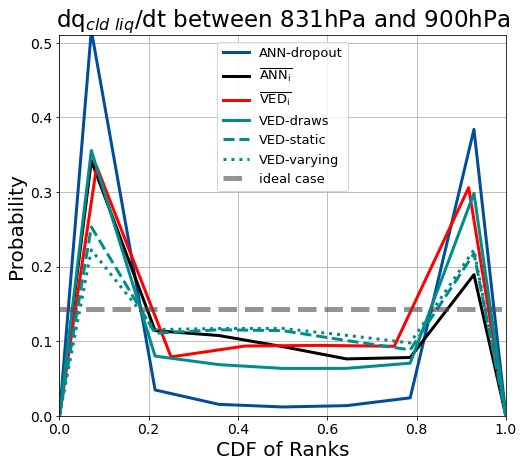

In [3]:
plt.figure(1,(8,7))
plt.title(r'dq$_{cld \ liq}$/dt between 831hPa and 900hPa',fontsize=23)

plt.plot(np.hstack((0,ANN_lin_dr_0_01CLDLIQBCTEND['pit_centers'],1)),np.hstack((0,ANN_lin_dr_0_01CLDLIQBCTEND['pit_counts'],0)),
         color=[0,0.3,0.6],linewidth=3,label='ANN-dropout')
plt.plot(np.hstack((0,deter_7_lin_CLDLIQBCTEND['pit_centers'],1)),np.hstack((0,deter_7_lin_CLDLIQBCTEND['pit_counts'],0))
         ,color='k',linewidth=3,label=r'$\mathrm{\overline{ANN_i}}$')
plt.plot(np.hstack((0,deter_6_VED_CLDLIQBCTEND['pit_centers'],1)),np.hstack((0,deter_6_VED_CLDLIQBCTEND['pit_counts'],0)),
         color='r',linewidth=3,label=r'$\mathrm{\overline{VED_i}}$')
plt.plot(np.hstack((0,VED_1_7_0_0_CLDLIQBCTEND['pit_centers'],1)),
         np.hstack((0,VED_1_7_0_0_CLDLIQBCTEND['pit_counts'],0)),color=[0,0.55,0.55],linewidth=3,label=r'VED-draws')

plt.plot(np.hstack((0,VED_1_7_0_5_CLDLIQBCTEND['pit_centers'],1)),
         np.hstack((0,VED_1_7_0_5_CLDLIQBCTEND['pit_counts'],0)),'--',color=[0,0.55,0.55],linewidth=3,label=r'VED-static')
plt.plot(np.hstack((0,VED_1_7_alpha_CLDLIQBCTEND['pit_centers'],1)),
         np.hstack((0,VED_1_7_alpha_CLDLIQBCTEND['pit_counts'],0)),linewidth=3,linestyle=':',color=[0,0.55,0.55],label=r'VED-varying')




plt.hlines(1/7,0,1,linestyle='--',linewidth=5,colors=[[0.3,0.3,0.3,0.6]],label='ideal case')



plt.grid(True)
plt.ylim(0,0.51)
plt.xlim(0,1)
plt.xlabel('CDF of Ranks',fontsize=20)
plt.legend(fontsize=13)
plt.ylabel('Probability',fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

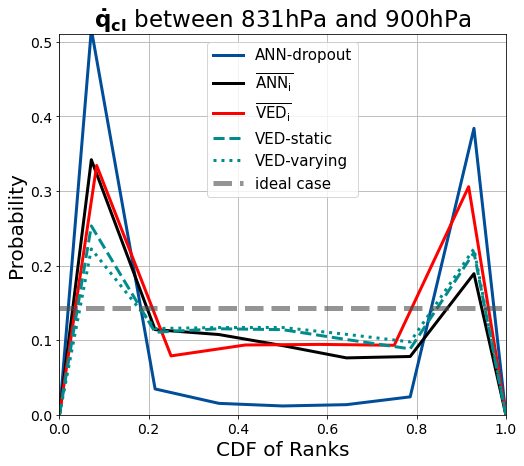

In [4]:
plt.figure(1,(8,7))
plt.title(r'$\mathbf{\dot{q}_{cl}}$ between 831hPa and 900hPa',fontsize=23)

plt.plot(np.hstack((0,ANN_lin_dr_0_01CLDLIQBCTEND['pit_centers'],1)),np.hstack((0,ANN_lin_dr_0_01CLDLIQBCTEND['pit_counts'],0)),
         color=[0,0.3,0.6],linewidth=3,label='ANN-dropout')
plt.plot(np.hstack((0,deter_7_lin_CLDLIQBCTEND['pit_centers'],1)),np.hstack((0,deter_7_lin_CLDLIQBCTEND['pit_counts'],0))
         ,color='k',linewidth=3,label=r'$\mathrm{\overline{ANN_i}}$')
plt.plot(np.hstack((0,deter_6_VED_CLDLIQBCTEND['pit_centers'],1)),np.hstack((0,deter_6_VED_CLDLIQBCTEND['pit_counts'],0)),
         color='r',linewidth=3,label=r'$\mathrm{\overline{VED_i}}$')
#plt.plot(np.hstack((0,VED_1_7_0_0_CLDLIQBCTEND['pit_centers'],1)),
#         np.hstack((0,VED_1_7_0_0_CLDLIQBCTEND['pit_counts'],0)),color=[0,0.55,0.55],linewidth=3,label=r'VED-draws')

plt.plot(np.hstack((0,VED_1_7_0_5_CLDLIQBCTEND['pit_centers'],1)),
         np.hstack((0,VED_1_7_0_5_CLDLIQBCTEND['pit_counts'],0)),'--',color=[0,0.55,0.55],linewidth=3,label=r'VED-static')
plt.plot(np.hstack((0,VED_1_7_alpha_CLDLIQBCTEND['pit_centers'],1)),
         np.hstack((0,VED_1_7_alpha_CLDLIQBCTEND['pit_counts'],0)),linewidth=3,linestyle=':',color=[0,0.55,0.55],label=r'VED-varying')




plt.hlines(1/7,0,1,linestyle='--',linewidth=5,colors=[[0.3,0.3,0.3,0.6]],label='ideal case')



plt.grid(True)
plt.ylim(0,0.51)
plt.xlim(0,1)
plt.xlabel('CDF of Ranks',fontsize=20)
plt.legend(fontsize=15)
plt.ylabel('Probability',fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

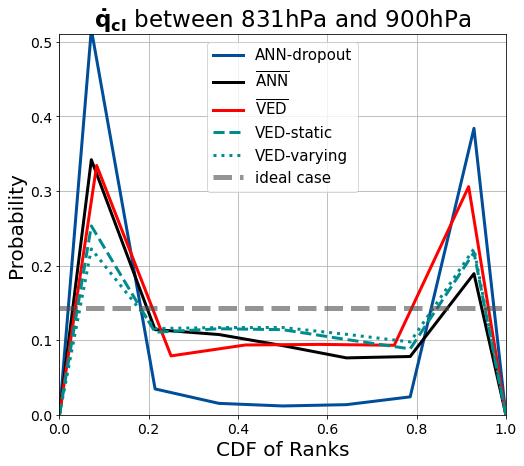

In [5]:
plt.figure(1,(8,7))
plt.title(r'$\mathbf{\dot{q}_{cl}}$ between 831hPa and 900hPa',fontsize=23)

plt.plot(np.hstack((0,ANN_lin_dr_0_01CLDLIQBCTEND['pit_centers'],1)),np.hstack((0,ANN_lin_dr_0_01CLDLIQBCTEND['pit_counts'],0)),
         color=[0,0.3,0.6],linewidth=3,label='ANN-dropout')
plt.plot(np.hstack((0,deter_7_lin_CLDLIQBCTEND['pit_centers'],1)),np.hstack((0,deter_7_lin_CLDLIQBCTEND['pit_counts'],0))
         ,color='k',linewidth=3,label=r'$\mathrm{\overline{ANN}}$')
plt.plot(np.hstack((0,deter_6_VED_CLDLIQBCTEND['pit_centers'],1)),np.hstack((0,deter_6_VED_CLDLIQBCTEND['pit_counts'],0)),
         color='r',linewidth=3,label=r'$\mathrm{\overline{VED}}$')
#plt.plot(np.hstack((0,VED_1_7_0_0_CLDLIQBCTEND['pit_centers'],1)),
#         np.hstack((0,VED_1_7_0_0_CLDLIQBCTEND['pit_counts'],0)),color=[0,0.55,0.55],linewidth=3,label=r'VED-draws')

plt.plot(np.hstack((0,VED_1_7_0_5_CLDLIQBCTEND['pit_centers'],1)),
         np.hstack((0,VED_1_7_0_5_CLDLIQBCTEND['pit_counts'],0)),'--',color=[0,0.55,0.55],linewidth=3,label=r'VED-static')
plt.plot(np.hstack((0,VED_1_7_alpha_CLDLIQBCTEND['pit_centers'],1)),
         np.hstack((0,VED_1_7_alpha_CLDLIQBCTEND['pit_counts'],0)),linewidth=3,linestyle=':',color=[0,0.55,0.55],label=r'VED-varying')




plt.hlines(1/7,0,1,linestyle='--',linewidth=5,colors=[[0.3,0.3,0.3,0.6]],label='ideal case')



plt.grid(True)
plt.ylim(0,0.51)
plt.xlim(0,1)
plt.xlabel('CDF of Ranks',fontsize=20)
plt.legend(fontsize=15)
plt.ylabel('Probability',fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

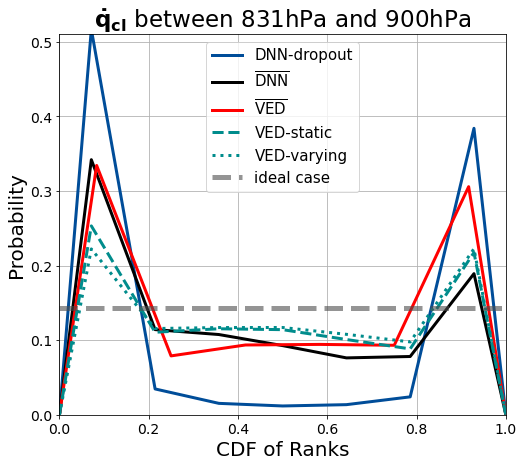

In [8]:
plt.figure(1,(8,7))
plt.title(r'$\mathbf{\dot{q}_{cl}}$ between 831hPa and 900hPa',fontsize=23)

plt.plot(np.hstack((0,ANN_lin_dr_0_01CLDLIQBCTEND['pit_centers'],1)),np.hstack((0,ANN_lin_dr_0_01CLDLIQBCTEND['pit_counts'],0)),
         color=[0,0.3,0.6],linewidth=3,label='DNN-dropout')
plt.plot(np.hstack((0,deter_7_lin_CLDLIQBCTEND['pit_centers'],1)),np.hstack((0,deter_7_lin_CLDLIQBCTEND['pit_counts'],0))
         ,color='k',linewidth=3,label=r'$\mathrm{\overline{DNN}}$')
plt.plot(np.hstack((0,deter_6_VED_CLDLIQBCTEND['pit_centers'],1)),np.hstack((0,deter_6_VED_CLDLIQBCTEND['pit_counts'],0)),
         color='r',linewidth=3,label=r'$\mathrm{\overline{VED}}$')
#plt.plot(np.hstack((0,VED_1_7_0_0_CLDLIQBCTEND['pit_centers'],1)),
#         np.hstack((0,VED_1_7_0_0_CLDLIQBCTEND['pit_counts'],0)),color=[0,0.55,0.55],linewidth=3,label=r'VED-draws')

plt.plot(np.hstack((0,VED_1_7_0_5_CLDLIQBCTEND['pit_centers'],1)),
         np.hstack((0,VED_1_7_0_5_CLDLIQBCTEND['pit_counts'],0)),'--',color=[0,0.55,0.55],linewidth=3,label=r'VED-static')
plt.plot(np.hstack((0,VED_1_7_alpha_CLDLIQBCTEND['pit_centers'],1)),
         np.hstack((0,VED_1_7_alpha_CLDLIQBCTEND['pit_counts'],0)),linewidth=3,linestyle=':',color=[0,0.55,0.55],label=r'VED-varying')




plt.hlines(1/7,0,1,linestyle='--',linewidth=5,colors=[[0.3,0.3,0.3,0.6]],label='ideal case')



plt.grid(True)
plt.ylim(0,0.51)
plt.xlim(0,1)
plt.xlabel('CDF of Ranks',fontsize=20)
plt.legend(fontsize=15)
plt.ylabel('Probability',fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

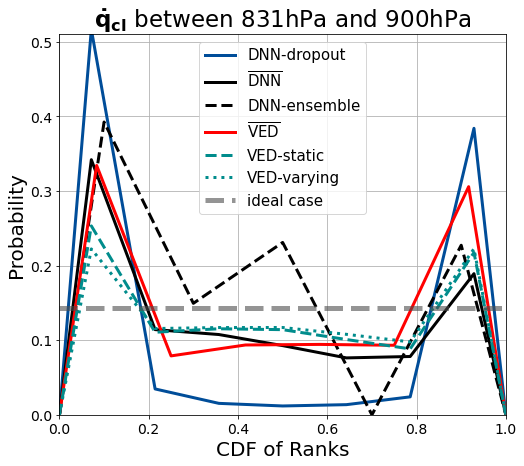

In [104]:
plt.figure(1,(8,7))
plt.title(r'$\mathbf{\dot{q}_{cl}}$ between 831hPa and 900hPa',fontsize=23)

plt.plot(np.hstack((0,ANN_lin_dr_0_01CLDLIQBCTEND['pit_centers'],1)),np.hstack((0,ANN_lin_dr_0_01CLDLIQBCTEND['pit_counts'],0)),
         color=[0,0.3,0.6],linewidth=3,label='DNN-dropout')
plt.plot(np.hstack((0,deter_7_lin_CLDLIQBCTEND['pit_centers'],1)),np.hstack((0,deter_7_lin_CLDLIQBCTEND['pit_counts'],0))
         ,color='k',linewidth=3,label=r'$\mathrm{\overline{DNN}}$')

plt.plot(np.hstack((0,stoch_5_lin_CLDLIQBCTEND['pit_centers'],1)),np.hstack((0,stoch_5_lin_CLDLIQBCTEND['pit_counts'],0))
         ,'--',color='k',linewidth=3,label=r'DNN-ensemble')

plt.plot(np.hstack((0,deter_6_VED_CLDLIQBCTEND['pit_centers'],1)),np.hstack((0,deter_6_VED_CLDLIQBCTEND['pit_counts'],0)),
         color='r',linewidth=3,label=r'$\mathrm{\overline{VED}}$')
#plt.plot(np.hstack((0,VED_1_7_0_0_CLDLIQBCTEND['pit_centers'],1)),
#         np.hstack((0,VED_1_7_0_0_CLDLIQBCTEND['pit_counts'],0)),color=[0,0.55,0.55],linewidth=3,label=r'VED-draws')

plt.plot(np.hstack((0,VED_1_7_0_5_CLDLIQBCTEND['pit_centers'],1)),
         np.hstack((0,VED_1_7_0_5_CLDLIQBCTEND['pit_counts'],0)),'--',color=[0,0.55,0.55],linewidth=3,label=r'VED-static')
plt.plot(np.hstack((0,VED_1_7_alpha_CLDLIQBCTEND['pit_centers'],1)),
         np.hstack((0,VED_1_7_alpha_CLDLIQBCTEND['pit_counts'],0)),linewidth=3,linestyle=':',color=[0,0.55,0.55],label=r'VED-varying')




plt.hlines(1/7,0,1,linestyle='--',linewidth=5,colors=[[0.3,0.3,0.3,0.6]],label='ideal case')



plt.grid(True)
plt.ylim(0,0.51)
plt.xlim(0,1)
plt.xlabel('CDF of Ranks',fontsize=20)
plt.legend(fontsize=15)
plt.ylabel('Probability',fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

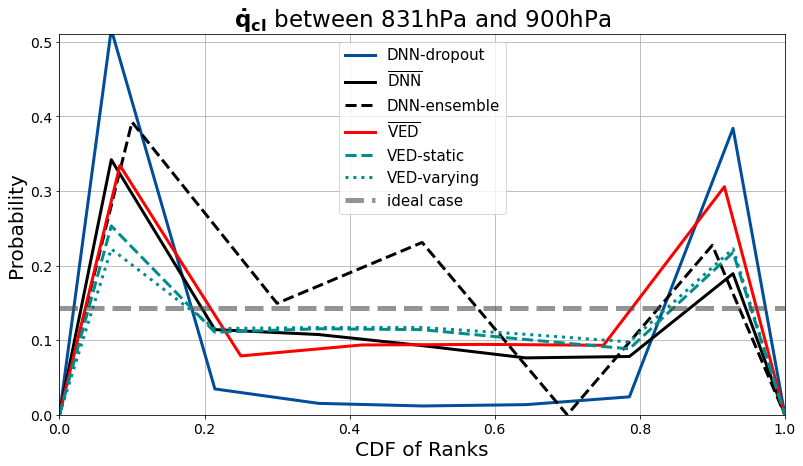

In [14]:
# with a different aspect ratio

plt.figure(1,(13,7))
plt.title(r'$\mathbf{\dot{q}_{cl}}$ between 831hPa and 900hPa',fontsize=23)

plt.plot(np.hstack((0,ANN_lin_dr_0_01CLDLIQBCTEND['pit_centers'],1)),np.hstack((0,ANN_lin_dr_0_01CLDLIQBCTEND['pit_counts'],0)),
         color=[0,0.3,0.6],linewidth=3,label='DNN-dropout')
plt.plot(np.hstack((0,deter_7_lin_CLDLIQBCTEND['pit_centers'],1)),np.hstack((0,deter_7_lin_CLDLIQBCTEND['pit_counts'],0))
         ,color='k',linewidth=3,label=r'$\mathrm{\overline{DNN}}$')

plt.plot(np.hstack((0,stoch_5_lin_CLDLIQBCTEND['pit_centers'],1)),np.hstack((0,stoch_5_lin_CLDLIQBCTEND['pit_counts'],0))
         ,'--',color='k',linewidth=3,label=r'DNN-ensemble')

plt.plot(np.hstack((0,deter_6_VED_CLDLIQBCTEND['pit_centers'],1)),np.hstack((0,deter_6_VED_CLDLIQBCTEND['pit_counts'],0)),
         color='r',linewidth=3,label=r'$\mathrm{\overline{VED}}$')
#plt.plot(np.hstack((0,VED_1_7_0_0_CLDLIQBCTEND['pit_centers'],1)),
#         np.hstack((0,VED_1_7_0_0_CLDLIQBCTEND['pit_counts'],0)),color=[0,0.55,0.55],linewidth=3,label=r'VED-draws')

plt.plot(np.hstack((0,VED_1_7_0_5_CLDLIQBCTEND['pit_centers'],1)),
         np.hstack((0,VED_1_7_0_5_CLDLIQBCTEND['pit_counts'],0)),'--',color=[0,0.55,0.55],linewidth=3,label=r'VED-static')
plt.plot(np.hstack((0,VED_1_7_alpha_CLDLIQBCTEND['pit_centers'],1)),
         np.hstack((0,VED_1_7_alpha_CLDLIQBCTEND['pit_counts'],0)),linewidth=3,linestyle=':',color=[0,0.55,0.55],label=r'VED-varying')




plt.hlines(1/7,0,1,linestyle='--',linewidth=5,colors=[[0.3,0.3,0.3,0.6]],label='ideal case')



plt.grid(True)
plt.ylim(0,0.51)
plt.xlim(0,1)
plt.xlabel('CDF of Ranks',fontsize=20)
plt.legend(fontsize=15)
plt.ylabel('Probability',fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

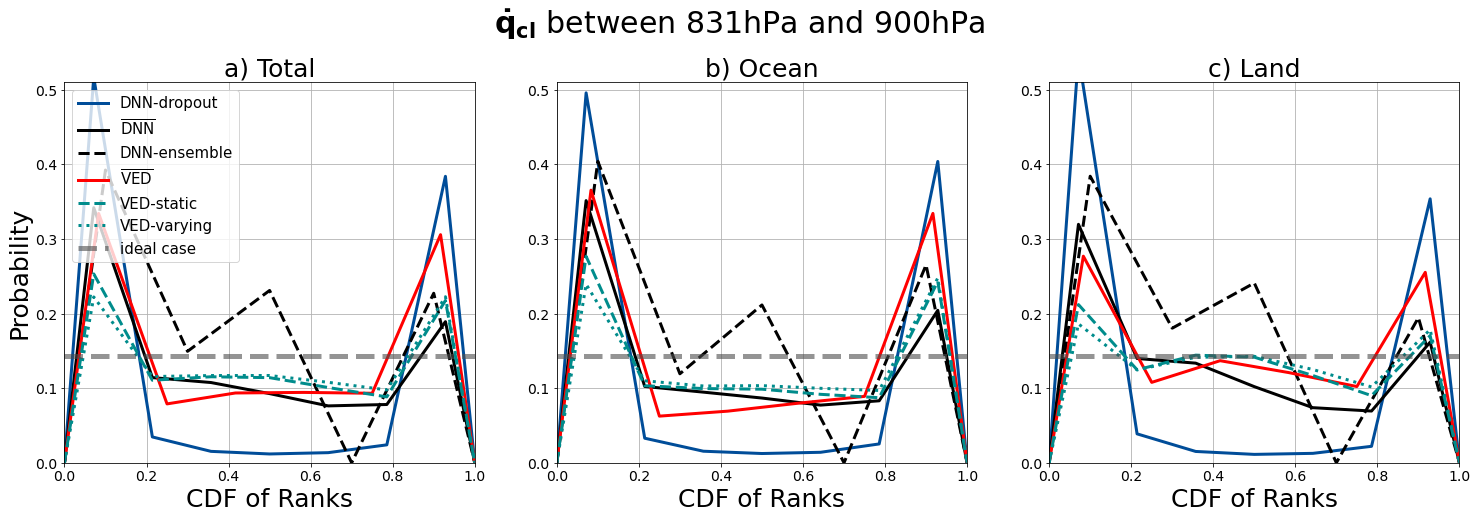

In [56]:
plt.figure(1,(25,7))
plt.suptitle(r'$\mathbf{\dot{q}_{cl}}$ between 831hPa and 900hPa',fontsize=30,y=1.03)

plt.subplot(1,3,1)
plt.title('a) Total', fontsize=25)
plt.plot(np.hstack((0,ANN_lin_dr_0_01CLDLIQBCTEND['pit_centers'],1)),np.hstack((0,ANN_lin_dr_0_01CLDLIQBCTEND['pit_counts'],0)),
         color=[0,0.3,0.6],linewidth=3,label='DNN-dropout')
plt.plot(np.hstack((0,deter_7_lin_CLDLIQBCTEND['pit_centers'],1)),np.hstack((0,deter_7_lin_CLDLIQBCTEND['pit_counts'],0))
         ,color='k',linewidth=3,label=r'$\mathrm{\overline{DNN}}$')
plt.plot(np.hstack((0,stoch_5_lin_CLDLIQBCTEND['pit_centers'],1)),np.hstack((0,stoch_5_lin_CLDLIQBCTEND['pit_counts'],0))
         ,'--',color='k',linewidth=3,label=r'DNN-ensemble')

plt.plot(np.hstack((0,deter_6_VED_CLDLIQBCTEND['pit_centers'],1)),np.hstack((0,deter_6_VED_CLDLIQBCTEND['pit_counts'],0)),
         color='r',linewidth=3,label=r'$\mathrm{\overline{VED}}$')
#plt.plot(np.hstack((0,VED_1_7_0_0_CLDLIQBCTEND['pit_centers'],1)),
#         np.hstack((0,VED_1_7_0_0_CLDLIQBCTEND['pit_counts'],0)),color=[0,0.55,0.55],linewidth=3,label=r'VED-draws')

plt.plot(np.hstack((0,VED_1_7_0_5_CLDLIQBCTEND['pit_centers'],1)),
         np.hstack((0,VED_1_7_0_5_CLDLIQBCTEND['pit_counts'],0)),'--',color=[0,0.55,0.55],linewidth=3,label=r'VED-static')
plt.plot(np.hstack((0,VED_1_7_alpha_CLDLIQBCTEND['pit_centers'],1)),
         np.hstack((0,VED_1_7_alpha_CLDLIQBCTEND['pit_counts'],0)),linewidth=3,linestyle=':',color=[0,0.55,0.55],label=r'VED-varying')




plt.hlines(1/7,0,1,linestyle='--',linewidth=5,colors=[[0.3,0.3,0.3,0.6]],label='ideal case')



plt.grid(True)
plt.ylim(0,0.51)
plt.xlim(0,1)
plt.xlabel('CDF of Ranks',fontsize=25)
plt.legend(fontsize=15,loc=2)
plt.ylabel('Probability',fontsize=25)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(1,3,2)
plt.title('b) Ocean', fontsize=25)
plt.plot(np.hstack((0,ANN_lin_dr_0_01CLDLIQBCTEND_ocean['pit_centers'],1)),np.hstack((0,ANN_lin_dr_0_01CLDLIQBCTEND_ocean['pit_counts'],0)),
         color=[0,0.3,0.6],linewidth=3,label='DNN-dropout')
plt.plot(np.hstack((0,deter_7_lin_CLDLIQBCTEND_ocean['pit_centers'],1)),np.hstack((0,deter_7_lin_CLDLIQBCTEND_ocean['pit_counts'],0))
         ,color='k',linewidth=3,label=r'$\mathrm{\overline{DNN}}$')
plt.plot(np.hstack((0,stoch_5_lin_CLDLIQBCTEND_ocean['pit_centers'],1)),np.hstack((0,stoch_5_lin_CLDLIQBCTEND_ocean['pit_counts'],0))
         ,'--',color='k',linewidth=3,label=r'DNN-ensemble')

plt.plot(np.hstack((0,deter_6_VED_CLDLIQBCTEND_ocean['pit_centers'],1)),np.hstack((0,deter_6_VED_CLDLIQBCTEND_ocean['pit_counts'],0)),
         color='r',linewidth=3,label=r'$\mathrm{\overline{VED}}$')
#plt.plot(np.hstack((0,VED_1_7_0_0_CLDLIQBCTEND['pit_centers'],1)),
#         np.hstack((0,VED_1_7_0_0_CLDLIQBCTEND['pit_counts'],0)),color=[0,0.55,0.55],linewidth=3,label=r'VED-draws')

plt.plot(np.hstack((0,VED_1_7_0_5_CLDLIQBCTEND_ocean['pit_centers'],1)),
         np.hstack((0,VED_1_7_0_5_CLDLIQBCTEND_ocean['pit_counts'],0)),'--',color=[0,0.55,0.55],linewidth=3,label=r'VED-static')
plt.plot(np.hstack((0,VED_1_7_alpha_CLDLIQBCTEND_ocean['pit_centers'],1)),
         np.hstack((0,VED_1_7_alpha_CLDLIQBCTEND_ocean['pit_counts'],0)),linewidth=3,linestyle=':',color=[0,0.55,0.55],label=r'VED-varying')




plt.hlines(1/7,0,1,linestyle='--',linewidth=5,colors=[[0.3,0.3,0.3,0.6]],label='ideal case')



plt.grid(True)
plt.ylim(0,0.51)
plt.xlim(0,1)
plt.xlabel('CDF of Ranks',fontsize=25)
#plt.legend(fontsize=15)
#plt.ylabel('Probability',fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(1,3,3)
plt.title('c) Land', fontsize=25)
plt.plot(np.hstack((0,ANN_lin_dr_0_01CLDLIQBCTEND_land['pit_centers'],1)),np.hstack((0,ANN_lin_dr_0_01CLDLIQBCTEND_land['pit_counts'],0)),
         color=[0,0.3,0.6],linewidth=3,label='DNN-dropout')
plt.plot(np.hstack((0,deter_7_lin_CLDLIQBCTEND_land['pit_centers'],1)),np.hstack((0,deter_7_lin_CLDLIQBCTEND_land['pit_counts'],0))
         ,color='k',linewidth=3,label=r'$\mathrm{\overline{DNN}}$')
plt.plot(np.hstack((0,stoch_5_lin_CLDLIQBCTEND_land['pit_centers'],1)),np.hstack((0,stoch_5_lin_CLDLIQBCTEND_land['pit_counts'],0))
         ,'--',color='k',linewidth=3,label=r'DNN-ensemble')

plt.plot(np.hstack((0,deter_6_VED_CLDLIQBCTEND_land['pit_centers'],1)),np.hstack((0,deter_6_VED_CLDLIQBCTEND_land['pit_counts'],0)),
         color='r',linewidth=3,label=r'$\mathrm{\overline{VED}}$')
#plt.plot(np.hstack((0,VED_1_7_0_0_CLDLIQBCTEND['pit_centers'],1)),
#         np.hstack((0,VED_1_7_0_0_CLDLIQBCTEND['pit_counts'],0)),color=[0,0.55,0.55],linewidth=3,label=r'VED-draws')

plt.plot(np.hstack((0,VED_1_7_0_5_CLDLIQBCTEND_land['pit_centers'],1)),
         np.hstack((0,VED_1_7_0_5_CLDLIQBCTEND_land['pit_counts'],0)),'--',color=[0,0.55,0.55],linewidth=3,label=r'VED-static')
plt.plot(np.hstack((0,VED_1_7_alpha_CLDLIQBCTEND_land['pit_centers'],1)),
         np.hstack((0,VED_1_7_alpha_CLDLIQBCTEND_land['pit_counts'],0)),linewidth=3,linestyle=':',color=[0,0.55,0.55],label=r'VED-varying')




plt.hlines(1/7,0,1,linestyle='--',linewidth=5,colors=[[0.3,0.3,0.3,0.6]],label='ideal case')



plt.grid(True)
plt.ylim(0,0.51)
plt.xlim(0,1)
plt.xlabel('CDF of Ranks',fontsize=25)
#plt.legend(fontsize=15)
#plt.ylabel('Probability',fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)




# $\dot{q}$ surface

In [67]:
dQ_surf=[25]

In [76]:
#\dot{q} at surface for \overline{ANN}
Q_tend_surf_ANN_lin,Q_tend_mem_7_ANN_lin=cldice_sum_calc(ANN_1_lin,
                                                      ANN_2_lin,
                                                      ANN_3_lin,
                                                      ANN_4_lin,
                                                      ANN_5_lin,
                                                      ANN_6_lin,
                                                      ANN_7_lin,val_gen_II,400,dQ_surf,np.arange(latit_array.size))

  0%|          | 0/400 [00:00<?, ?it/s]

In [77]:
#\dot{q} at surface for ANN-ensemble
Q_tend_surf_ANN_lin_1,Q_tend_mem_5_ANN_lin=cldice_sum_calc_stoch(ANN_1_lin,
                                                      ANN_2_lin,
                                                      ANN_3_lin,
                                                      ANN_4_lin,
                                                      ANN_5_lin,
                                                      ANN_6_lin,
                                                      ANN_7_lin,val_gen_II,400,dQ_surf,np.arange(latit_array.size))

  0%|          | 0/400 [00:00<?, ?it/s]

In [63]:
#\dot{q} at surface for ANN-dropout

Q_tend_surf_ANN_1_lin_dr,Q_tend_mem_7_dr_ANN_1_lin_dr=cldice_sum_calc_single_ANN_dr(ANN_1_lin_dr_0_01,
                                                      val_gen_II,400,dQ_surf,np.arange(latit_array.size))

  0%|          | 0/400 [00:00<?, ?it/s]

In [64]:
#\dot{q} at surface for \overline{VED}

Q_tend_surf_VED,Q_tend_mem_6_VED=VED_cldice_sum_calc(VDec_1,VDec_2,
                                                    VDec_3,VDec_4,
                                                    VDec_5,VDec_7,
                                                    VEnc_1,VEnc_2,
                                                    VEnc_3,VEnc_4,
                                                    VEnc_5,VEnc_7,
                                                    val_gen_III,400,dQ_surf,np.arange(latit_array.size))

  0%|          | 0/400 [00:00<?, ?it/s]

In [65]:
#\dot{q} at surface for VED-draws

Q_tend_VED_1_7_0,Q_tend_VED_1_7_0_mem_7_dr=VED_cldice_sum_calc_internal_stoch(VDec_1,VEnc_1,
                                                    val_gen_III,400,dQ_surf,np.arange(latit_array.size),0.0,7)

  0%|          | 0/400 [00:00<?, ?it/s]

In [66]:
#\dot{q} at surface for VED-static

Q_tend_VED_1_7_0_5,Q_tend_VED_1_7_0_5_mem_7_dr=VED_cldice_sum_calc_internal_stoch(VDec_1,VEnc_1,
                                                    val_gen_III,400,dQ_surf,np.arange(latit_array.size),0.5,7)

  0%|          | 0/400 [00:00<?, ?it/s]

In [67]:
#\dot{q} at surface for VED-varying

Q_surf_tend_VED_alpha_arr_1,VED_Q_surf_1_7_7_alpha_arr_1=VED_cldice_sum_calc_internal_stoch_alpha_sens(VDec_1,VEnc_1,val_gen_III,
                                                                                                                     400,dQ_surf,
                                                                                                                     np.arange(latit_array.size),
                                                                                                                     np.load('alpha_arrs/alpha_1.npy'),
                                                                                                                     7)
                                                                                                                     

                                                                                                                     


  0%|          | 0/400 [00:00<?, ?it/s]

In [ ]:
#compute PIT histograms for all ensembles 

a_lin=get_pit_points_ens(Q_tend_surf_ANN_lin,Q_tend_mem_7_ANN_lin,pit_bins=np.arange(0,1.1,1/7))
b_lin=get_pit_points_ens(Q_tend_surf_ANN_1_lin_dr,Q_tend_mem_7_dr_ANN_1_lin_dr,pit_bins=np.arange(0,1.1,1/7))
c=get_pit_points_ens(Q_tend_surf_VED,Q_tend_mem_6_VED,pit_bins=np.arange(0,1.1,1/6))
d=get_pit_points_ens(Q_tend_VED_1_7_0,Q_tend_VED_1_7_0_mem_7_dr,pit_bins=np.arange(0,1.1,1/7))
e=get_pit_points_ens(Q_tend_VED_1_7_0_5,Q_tend_VED_1_7_0_5_mem_7_dr,pit_bins=np.arange(0,1.1,1/7))
f=get_pit_points_ens(Q_surf_tend_VED_alpha_arr_1,VED_Q_surf_1_7_7_alpha_arr_1,pit_bins=np.arange(0,1.1,1/7))


In [ ]:
#np.save('real_geo_PIT/QBCTEND_surf/deter_7_ANNs_lin_QBCTEND_surf',a_lin)
#np.save('real_geo_PIT/QBCTEND_surf/ANN_lin_dr_0_01_7_QBCTEND_surf',b_lin)
#np.save('real_geo_PIT/QBCTEND_surf/deter_6_VEDs_QBCTEND_surf',c)
#np.save('real_geo_PIT/QBCTEND_surf/VEDs_1_7_0_0_QBCTEND_surf',d)
#np.save('real_geo_PIT/QBCTEND_surf/VEDs_1_7_0_5_QBCTEND_surf',e)
#np.save('real_geo_PIT/QBCTEND_surf/VEDs_1_7_alpha_1_QBCTEND_surf',f)




In [117]:
a_lin_stoch=get_pit_points_ens(Q_tend_surf_ANN_lin,Q_tend_mem_5_ANN_lin,pit_bins=np.arange(0,1.1,1/5))
#np.save('real_geo_PIT/QBCTEND_surf/stoch_5_ANNs_lin_QBCTEND_surf',a_lin_stoch)


In [118]:
print(a_lin_stoch)

{'pit_centers': array([0.1, 0.3, 0.5, 0.7, 0.9]), 'pit_counts': array([0.21158402, 0.17572229, 0.32843081, 0.        , 0.28426288]), 'pit_dvalue': 0.11341807743469225, 'pit_evalue': 0.00017010345435994293, 'pit_values': array([0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.4]), 'pit_weights': array([1.80844907e-07, 1.80844907e-07, 1.80844907e-07, ...,
       1.80844907e-07, 1.80844907e-07, 1.80844907e-07])}


In [78]:
#compute PIT histograms for all ensembles land points 

a_lin_land=get_pit_points_ens(Q_tend_surf_ANN_lin[land_ext_resh.astype('int')],
                              Q_tend_mem_7_ANN_lin[land_ext_resh.astype('int')],pit_bins=np.arange(0,1.1,1/7))
a_lin_stoch_land=get_pit_points_ens(Q_tend_surf_ANN_lin_1[land_ext_resh.astype('int')],
                                    Q_tend_mem_5_ANN_lin[land_ext_resh.astype('int')],pit_bins=np.arange(0,1.1,1/5))
#b_lin_land=get_pit_points_ens(Q_tend_surf_ANN_1_lin_dr[land_ext_resh.astype('int')],
#                              Q_tend_mem_7_dr_ANN_1_lin_dr[land_ext_resh.astype('int')],pit_bins=np.arange(0,1.1,1/7))
#c_land=get_pit_points_ens(Q_tend_surf_VED[land_ext_resh.astype('int')],
#                          Q_tend_mem_6_VED[land_ext_resh.astype('int')],pit_bins=np.arange(0,1.1,1/6))
#d_land=get_pit_points_ens(Q_tend_VED_1_7_0[land_ext_resh.astype('int')],
#                          Q_tend_VED_1_7_0_mem_7_dr[land_ext_resh.astype('int')],pit_bins=np.arange(0,1.1,1/7))
#e_land=get_pit_points_ens(Q_tend_VED_1_7_0_5[land_ext_resh.astype('int')],
#                          Q_tend_VED_1_7_0_5_mem_7_dr[land_ext_resh.astype('int')],pit_bins=np.arange(0,1.1,1/7))
#f_land=get_pit_points_ens(Q_surf_tend_VED_alpha_arr_1[land_ext_resh.astype('int')],
#                          VED_Q_surf_1_7_7_alpha_arr_1[land_ext_resh.astype('int')],pit_bins=np.arange(0,1.1,1/7))

np.save('real_geo_PIT/QBCTEND_surf/deter_7_ANN_lin_QBCTEND_surf_land',a_lin_land)
#np.save('real_geo_PIT/QBCTEND_surf/ANN_lin_dr_0_01_7_QBCTEND_surf_land',b_lin_land)
#np.save('real_geo_PIT/QBCTEND_surf/deter_6_VEDs_QBCTEND_surf_land',c_land)
#np.save('real_geo_PIT/QBCTEND_surf/VEDs_1_7_0_0_QBCTEND_surf_land',d_land)
#np.save('real_geo_PIT/QBCTEND_surf/VEDs_1_7_0_5_QBCTEND_surf_land',e_land)
#np.save('real_geo_PIT/QBCTEND_surf/VEDs_1_7_alpha_1_QBCTEND_surf_updt_land',f_land)
np.save('real_geo_PIT/QBCTEND_surf/stoch_5_ANN_lin_QBCTEND_surf_land',a_lin_stoch_land)


In [79]:
#compute PIT histograms for all ensembles ocean points 

a_lin_ocean=get_pit_points_ens(Q_tend_surf_ANN_lin[ocean_ext_resh.astype('int')],
                              Q_tend_mem_7_ANN_lin[ocean_ext_resh.astype('int')],pit_bins=np.arange(0,1.1,1/7))
a_lin_stoch_ocean=get_pit_points_ens(Q_tend_surf_ANN_lin_1[ocean_ext_resh.astype('int')],
                                    Q_tend_mem_5_ANN_lin[ocean_ext_resh.astype('int')],pit_bins=np.arange(0,1.1,1/5))
#b_lin_ocean=get_pit_points_ens(Q_tend_surf_ANN_1_lin_dr[ocean_ext_resh.astype('int')],
#                              Q_tend_mem_7_dr_ANN_1_lin_dr[ocean_ext_resh.astype('int')],pit_bins=np.arange(0,1.1,1/7))
#c_ocean=get_pit_points_ens(Q_tend_surf_VED[ocean_ext_resh.astype('int')],
#                          Q_tend_mem_6_VED[ocean_ext_resh.astype('int')],pit_bins=np.arange(0,1.1,1/6))
#d_ocean=get_pit_points_ens(Q_tend_VED_1_7_0[ocean_ext_resh.astype('int')],
#                          Q_tend_VED_1_7_0_mem_7_dr[ocean_ext_resh.astype('int')],pit_bins=np.arange(0,1.1,1/7))
#e_ocean=get_pit_points_ens(Q_tend_VED_1_7_0_5[ocean_ext_resh.astype('int')],
#                          Q_tend_VED_1_7_0_5_mem_7_dr[ocean_ext_resh.astype('int')],pit_bins=np.arange(0,1.1,1/7))
#f_ocean=get_pit_points_ens(Q_surf_tend_VED_alpha_arr_1[ocean_ext_resh.astype('int')],
#                          VED_Q_surf_1_7_7_alpha_arr_1[ocean_ext_resh.astype('int')],pit_bins=np.arange(0,1.1,1/7))

np.save('real_geo_PIT/QBCTEND_surf/deter_7_ANN_lin_QBCTEND_surf_ocean',a_lin_ocean)
#np.save('real_geo_PIT/QBCTEND_surf/ANN_lin_dr_0_01_7_QBCTEND_surf_ocean',b_lin_ocean)
#np.save('real_geo_PIT/QBCTEND_surf/deter_6_VEDs_QBCTEND_surf_ocean',c_ocean)
#np.save('real_geo_PIT/QBCTEND_surf/VEDs_1_7_0_0_QBCTEND_surf_ocean',d_ocean)
#np.save('real_geo_PIT/QBCTEND_surf/VEDs_1_7_0_5_QBCTEND_surf_ocean',e_ocean)
#np.save('real_geo_PIT/QBCTEND_surf/VEDs_1_7_alpha_1_QBCTEND_surf_updt_ocean',f_ocean)
np.save('real_geo_PIT/QBCTEND_surf/stoch_5_ANN_lin_QBCTEND_surf_ocean',a_lin_stoch_ocean)


In [49]:

deter_7_lin_QBCTEND=np.load('real_geo_PIT/QBCTEND_surf/deter_7_ANNs_lin_QBCTEND_surf.npy',allow_pickle=True).tolist()

stoch_5_lin_QBCTEND=np.load('real_geo_PIT/QBCTEND_surf/stoch_5_ANNs_lin_QBCTEND_surf.npy',allow_pickle=True).tolist()


ANN_lin_dr_0_01QBCTEND=np.load('real_geo_PIT/QBCTEND_surf/ANN_lin_dr_0_01_7_QBCTEND_surf.npy',allow_pickle=True).tolist()


deter_6_VED_QBCTEND=np.load('real_geo_PIT/QBCTEND_surf/deter_6_VEDs_QBCTEND_surf.npy',allow_pickle=True).tolist()
VED_1_7_0_0_QBCTEND=np.load('real_geo_PIT/QBCTEND_surf/VEDs_1_7_0_0_QBCTEND_surf.npy',allow_pickle=True).tolist()
VED_1_7_0_5_QBCTEND=np.load('real_geo_PIT/QBCTEND_surf/VEDs_1_7_0_5_QBCTEND_surf.npy',allow_pickle=True).tolist()
VED_1_7_alpha_QBCTEND=np.load('real_geo_PIT/QBCTEND_surf/VEDs_1_7_alpha_1_QBCTEND_surf.npy',allow_pickle=True).tolist()


In [50]:

deter_7_lin_QBCTEND_land=np.load('real_geo_PIT/QBCTEND_surf/deter_7_ANN_lin_QBCTEND_surf_land.npy',allow_pickle=True).tolist()

stoch_5_lin_QBCTEND_land=np.load('real_geo_PIT/QBCTEND_surf/stoch_5_ANN_lin_QBCTEND_surf_land.npy',allow_pickle=True).tolist()


ANN_lin_dr_0_01QBCTEND_land=np.load('real_geo_PIT/QBCTEND_surf/ANN_lin_dr_0_01_7_QBCTEND_surf_land.npy',allow_pickle=True).tolist()


deter_6_VED_QBCTEND_land=np.load('real_geo_PIT/QBCTEND_surf/deter_6_VEDs_QBCTEND_surf_land.npy',allow_pickle=True).tolist()
VED_1_7_0_0_QBCTEND_land=np.load('real_geo_PIT/QBCTEND_surf/VEDs_1_7_0_0_QBCTEND_surf_land.npy',allow_pickle=True).tolist()
VED_1_7_0_5_QBCTEND_land=np.load('real_geo_PIT/QBCTEND_surf/VEDs_1_7_0_5_QBCTEND_surf_land.npy',allow_pickle=True).tolist()
VED_1_7_alpha_QBCTEND_land=np.load('real_geo_PIT/QBCTEND_surf/VEDs_1_7_alpha_1_QBCTEND_surf_updt_land.npy',allow_pickle=True).tolist()


In [51]:

deter_7_lin_QBCTEND_ocean=np.load('real_geo_PIT/QBCTEND_surf/deter_7_ANN_lin_QBCTEND_surf_ocean.npy',allow_pickle=True).tolist()

stoch_5_lin_QBCTEND_ocean=np.load('real_geo_PIT/QBCTEND_surf/stoch_5_ANN_lin_QBCTEND_surf_ocean.npy',allow_pickle=True).tolist()


ANN_lin_dr_0_01QBCTEND_ocean=np.load('real_geo_PIT/QBCTEND_surf/ANN_lin_dr_0_01_7_QBCTEND_surf_ocean.npy',allow_pickle=True).tolist()


deter_6_VED_QBCTEND_ocean=np.load('real_geo_PIT/QBCTEND_surf/deter_6_VEDs_QBCTEND_surf_ocean.npy',allow_pickle=True).tolist()
VED_1_7_0_0_QBCTEND_ocean=np.load('real_geo_PIT/QBCTEND_surf/VEDs_1_7_0_0_QBCTEND_surf_ocean.npy',allow_pickle=True).tolist()
VED_1_7_0_5_QBCTEND_ocean=np.load('real_geo_PIT/QBCTEND_surf/VEDs_1_7_0_5_QBCTEND_surf_ocean.npy',allow_pickle=True).tolist()
VED_1_7_alpha_QBCTEND_ocean=np.load('real_geo_PIT/QBCTEND_surf/VEDs_1_7_alpha_1_QBCTEND_surf_updt_ocean.npy',allow_pickle=True).tolist()


(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

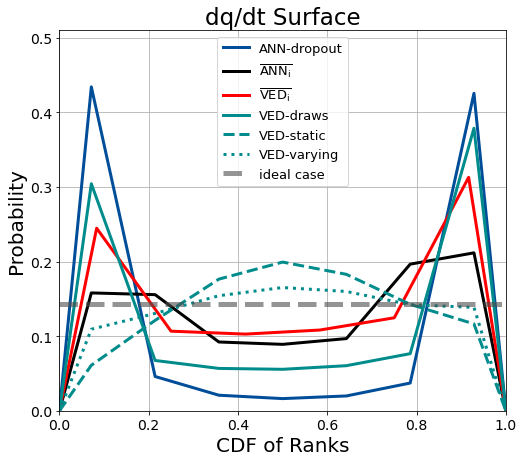

In [8]:
plt.figure(1,(8,7))
plt.title(r'dq/dt Surface',fontsize=23)

plt.plot(np.hstack((0,ANN_lin_dr_0_01QBCTEND['pit_centers'],1)),np.hstack((0,ANN_lin_dr_0_01QBCTEND['pit_counts'],0)),
         color=[0,0.3,0.6],linewidth=3,label='ANN-dropout')
plt.plot(np.hstack((0,deter_7_lin_QBCTEND['pit_centers'],1)),np.hstack((0,deter_7_lin_QBCTEND['pit_counts'],0))
         ,color='k',linewidth=3,label=r'$\mathrm{\overline{ANN_i}}$')
plt.plot(np.hstack((0,deter_6_VED_QBCTEND['pit_centers'],1)),np.hstack((0,deter_6_VED_QBCTEND['pit_counts'],0)),
         color='r',linewidth=3,label=r'$\mathrm{\overline{VED_i}}$')
plt.plot(np.hstack((0,VED_1_7_0_0_QBCTEND['pit_centers'],1)),
         np.hstack((0,VED_1_7_0_0_QBCTEND['pit_counts'],0)),color=[0,0.55,0.55],linewidth=3,label=r'VED-draws')

plt.plot(np.hstack((0,VED_1_7_0_5_QBCTEND['pit_centers'],1)),
         np.hstack((0,VED_1_7_0_5_QBCTEND['pit_counts'],0)),'--',color=[0,0.55,0.55],linewidth=3,label=r'VED-static')
plt.plot(np.hstack((0,VED_1_7_alpha_QBCTEND['pit_centers'],1)),
         np.hstack((0,VED_1_7_alpha_QBCTEND['pit_counts'],0)),linewidth=3,linestyle=':',color=[0,0.55,0.55],label=r'VED-varying')




plt.hlines(1/7,0,1,linestyle='--',linewidth=5,colors=[[0.3,0.3,0.3,0.6]],label='ideal case')



plt.grid(True)
plt.ylim(0,0.51)
plt.xlim(0,1)
plt.xlabel('CDF of Ranks',fontsize=20)
plt.legend(fontsize=13)
plt.ylabel('Probability',fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

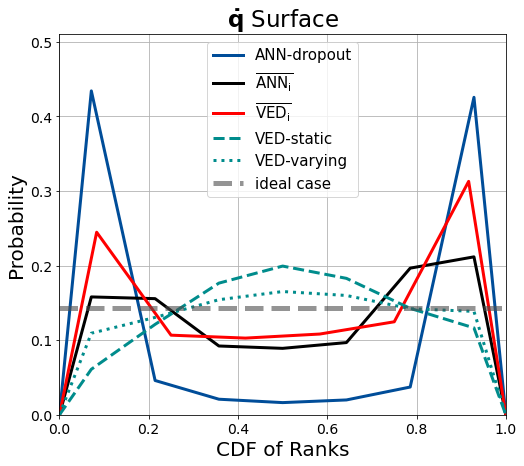

In [15]:
plt.figure(1,(8,7))
plt.title(r'$\mathbf{\dot{q}}$ Surface',fontsize=23)

plt.plot(np.hstack((0,ANN_lin_dr_0_01QBCTEND['pit_centers'],1)),np.hstack((0,ANN_lin_dr_0_01QBCTEND['pit_counts'],0)),
         color=[0,0.3,0.6],linewidth=3,label='ANN-dropout')
plt.plot(np.hstack((0,deter_7_lin_QBCTEND['pit_centers'],1)),np.hstack((0,deter_7_lin_QBCTEND['pit_counts'],0))
         ,color='k',linewidth=3,label=r'$\mathrm{\overline{ANN_i}}$')
plt.plot(np.hstack((0,deter_6_VED_QBCTEND['pit_centers'],1)),np.hstack((0,deter_6_VED_QBCTEND['pit_counts'],0)),
         color='r',linewidth=3,label=r'$\mathrm{\overline{VED_i}}$')
#plt.plot(np.hstack((0,VED_1_7_0_0_QBCTEND['pit_centers'],1)),
#         np.hstack((0,VED_1_7_0_0_QBCTEND['pit_counts'],0)),color=[0,0.55,0.55],linewidth=3,label=r'VED-draws')

plt.plot(np.hstack((0,VED_1_7_0_5_QBCTEND['pit_centers'],1)),
         np.hstack((0,VED_1_7_0_5_QBCTEND['pit_counts'],0)),'--',color=[0,0.55,0.55],linewidth=3,label=r'VED-static')
plt.plot(np.hstack((0,VED_1_7_alpha_QBCTEND['pit_centers'],1)),
         np.hstack((0,VED_1_7_alpha_QBCTEND['pit_counts'],0)),linewidth=3,linestyle=':',color=[0,0.55,0.55],label=r'VED-varying')




plt.hlines(1/7,0,1,linestyle='--',linewidth=5,colors=[[0.3,0.3,0.3,0.6]],label='ideal case')



plt.grid(True)
plt.ylim(0,0.51)
plt.xlim(0,1)
plt.xlabel('CDF of Ranks',fontsize=20)
plt.legend(fontsize=15)
plt.ylabel('Probability',fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

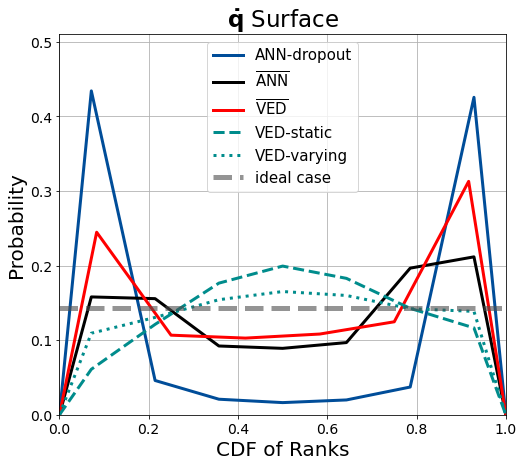

In [7]:
plt.figure(1,(8,7))
plt.title(r'$\mathbf{\dot{q}}$ Surface',fontsize=23)

plt.plot(np.hstack((0,ANN_lin_dr_0_01QBCTEND['pit_centers'],1)),np.hstack((0,ANN_lin_dr_0_01QBCTEND['pit_counts'],0)),
         color=[0,0.3,0.6],linewidth=3,label='ANN-dropout')
plt.plot(np.hstack((0,deter_7_lin_QBCTEND['pit_centers'],1)),np.hstack((0,deter_7_lin_QBCTEND['pit_counts'],0))
         ,color='k',linewidth=3,label=r'$\mathrm{\overline{ANN}}$')
plt.plot(np.hstack((0,deter_6_VED_QBCTEND['pit_centers'],1)),np.hstack((0,deter_6_VED_QBCTEND['pit_counts'],0)),
         color='r',linewidth=3,label=r'$\mathrm{\overline{VED}}$')
#plt.plot(np.hstack((0,VED_1_7_0_0_QBCTEND['pit_centers'],1)),
#         np.hstack((0,VED_1_7_0_0_QBCTEND['pit_counts'],0)),color=[0,0.55,0.55],linewidth=3,label=r'VED-draws')

plt.plot(np.hstack((0,VED_1_7_0_5_QBCTEND['pit_centers'],1)),
         np.hstack((0,VED_1_7_0_5_QBCTEND['pit_counts'],0)),'--',color=[0,0.55,0.55],linewidth=3,label=r'VED-static')
plt.plot(np.hstack((0,VED_1_7_alpha_QBCTEND['pit_centers'],1)),
         np.hstack((0,VED_1_7_alpha_QBCTEND['pit_counts'],0)),linewidth=3,linestyle=':',color=[0,0.55,0.55],label=r'VED-varying')




plt.hlines(1/7,0,1,linestyle='--',linewidth=5,colors=[[0.3,0.3,0.3,0.6]],label='ideal case')



plt.grid(True)
plt.ylim(0,0.51)
plt.xlim(0,1)
plt.xlabel('CDF of Ranks',fontsize=20)
plt.legend(fontsize=15)
plt.ylabel('Probability',fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

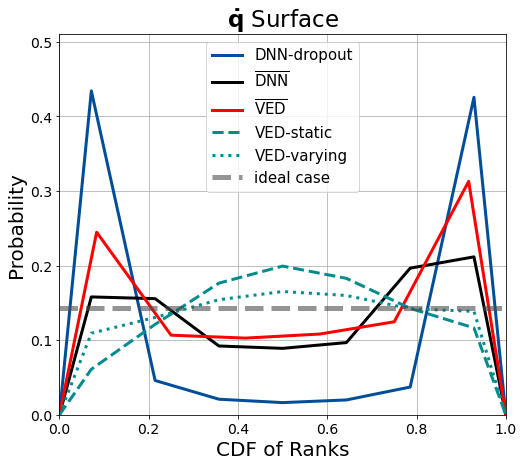

In [10]:
plt.figure(1,(8,7))
plt.title(r'$\mathbf{\dot{q}}$ Surface',fontsize=23)

plt.plot(np.hstack((0,ANN_lin_dr_0_01QBCTEND['pit_centers'],1)),np.hstack((0,ANN_lin_dr_0_01QBCTEND['pit_counts'],0)),
         color=[0,0.3,0.6],linewidth=3,label='DNN-dropout')
plt.plot(np.hstack((0,deter_7_lin_QBCTEND['pit_centers'],1)),np.hstack((0,deter_7_lin_QBCTEND['pit_counts'],0))
         ,color='k',linewidth=3,label=r'$\mathrm{\overline{DNN}}$')
plt.plot(np.hstack((0,deter_6_VED_QBCTEND['pit_centers'],1)),np.hstack((0,deter_6_VED_QBCTEND['pit_counts'],0)),
         color='r',linewidth=3,label=r'$\mathrm{\overline{VED}}$')
#plt.plot(np.hstack((0,VED_1_7_0_0_QBCTEND['pit_centers'],1)),
#         np.hstack((0,VED_1_7_0_0_QBCTEND['pit_counts'],0)),color=[0,0.55,0.55],linewidth=3,label=r'VED-draws')

plt.plot(np.hstack((0,VED_1_7_0_5_QBCTEND['pit_centers'],1)),
         np.hstack((0,VED_1_7_0_5_QBCTEND['pit_counts'],0)),'--',color=[0,0.55,0.55],linewidth=3,label=r'VED-static')
plt.plot(np.hstack((0,VED_1_7_alpha_QBCTEND['pit_centers'],1)),
         np.hstack((0,VED_1_7_alpha_QBCTEND['pit_counts'],0)),linewidth=3,linestyle=':',color=[0,0.55,0.55],label=r'VED-varying')




plt.hlines(1/7,0,1,linestyle='--',linewidth=5,colors=[[0.3,0.3,0.3,0.6]],label='ideal case')



plt.grid(True)
plt.ylim(0,0.51)
plt.xlim(0,1)
plt.xlabel('CDF of Ranks',fontsize=20)
plt.legend(fontsize=15)
plt.ylabel('Probability',fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

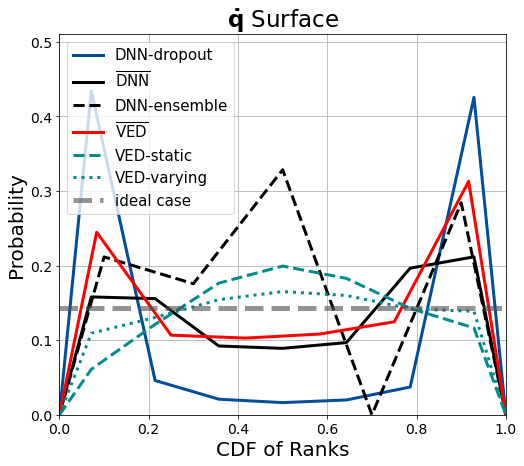

In [114]:
plt.figure(1,(8,7))
plt.title(r'$\mathbf{\dot{q}}$ Surface',fontsize=23)

plt.plot(np.hstack((0,ANN_lin_dr_0_01QBCTEND['pit_centers'],1)),np.hstack((0,ANN_lin_dr_0_01QBCTEND['pit_counts'],0)),
         color=[0,0.3,0.6],linewidth=3,label='DNN-dropout')
plt.plot(np.hstack((0,deter_7_lin_QBCTEND['pit_centers'],1)),np.hstack((0,deter_7_lin_QBCTEND['pit_counts'],0))
         ,color='k',linewidth=3,label=r'$\mathrm{\overline{DNN}}$')

plt.plot(np.hstack((0,stoch_5_lin_QBCTEND['pit_centers'],1)),np.hstack((0,stoch_5_lin_QBCTEND['pit_counts'],0))
         ,'--',color='k',linewidth=3,label='DNN-ensemble')

plt.plot(np.hstack((0,deter_6_VED_QBCTEND['pit_centers'],1)),np.hstack((0,deter_6_VED_QBCTEND['pit_counts'],0)),
         color='r',linewidth=3,label=r'$\mathrm{\overline{VED}}$')
#plt.plot(np.hstack((0,VED_1_7_0_0_QBCTEND['pit_centers'],1)),
#         np.hstack((0,VED_1_7_0_0_QBCTEND['pit_counts'],0)),color=[0,0.55,0.55],linewidth=3,label=r'VED-draws')

plt.plot(np.hstack((0,VED_1_7_0_5_QBCTEND['pit_centers'],1)),
         np.hstack((0,VED_1_7_0_5_QBCTEND['pit_counts'],0)),'--',color=[0,0.55,0.55],linewidth=3,label=r'VED-static')
plt.plot(np.hstack((0,VED_1_7_alpha_QBCTEND['pit_centers'],1)),
         np.hstack((0,VED_1_7_alpha_QBCTEND['pit_counts'],0)),linewidth=3,linestyle=':',color=[0,0.55,0.55],label=r'VED-varying')




plt.hlines(1/7,0,1,linestyle='--',linewidth=5,colors=[[0.3,0.3,0.3,0.6]],label='ideal case')



plt.grid(True)
plt.ylim(0,0.51)
plt.xlim(0,1)
plt.xlabel('CDF of Ranks',fontsize=20)
plt.legend(fontsize=15)
plt.ylabel('Probability',fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

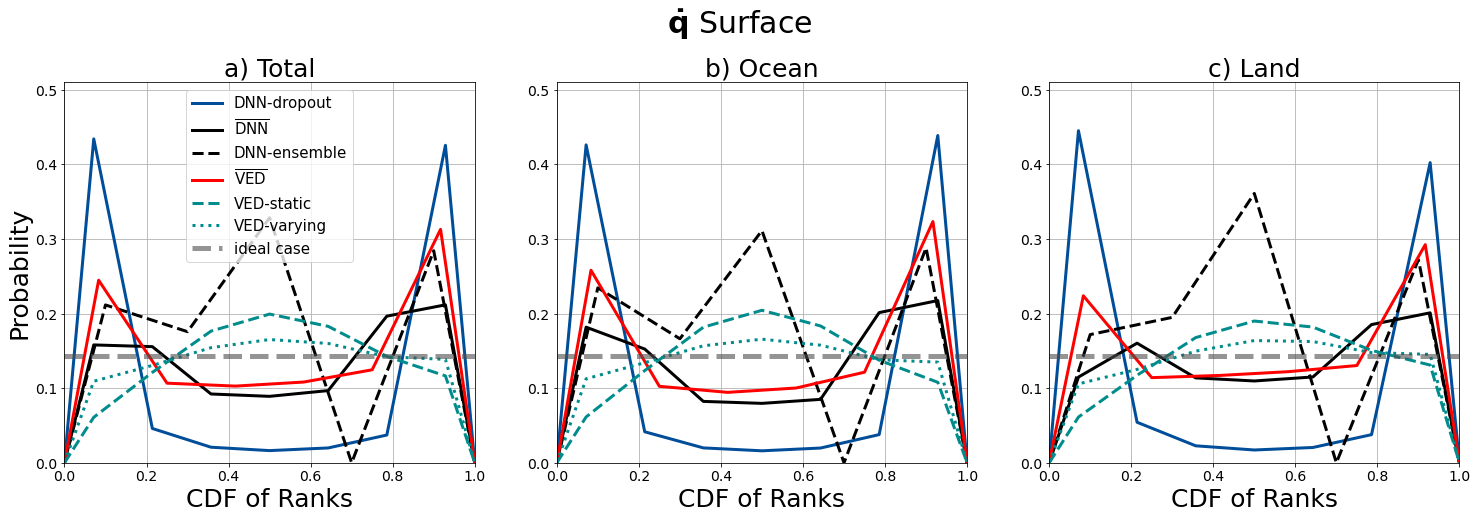

In [52]:
plt.figure(1,(25,7))
plt.suptitle(r'$\mathbf{\dot{q}}$ Surface',fontsize=30,y=1.03)

plt.subplot(1,3,1)
plt.title('a) Total', fontsize=25)

plt.plot(np.hstack((0,ANN_lin_dr_0_01QBCTEND['pit_centers'],1)),np.hstack((0,ANN_lin_dr_0_01QBCTEND['pit_counts'],0)),
         color=[0,0.3,0.6],linewidth=3,label='DNN-dropout')
plt.plot(np.hstack((0,deter_7_lin_QBCTEND['pit_centers'],1)),np.hstack((0,deter_7_lin_QBCTEND['pit_counts'],0))
         ,color='k',linewidth=3,label=r'$\mathrm{\overline{DNN}}$')

plt.plot(np.hstack((0,stoch_5_lin_QBCTEND['pit_centers'],1)),np.hstack((0,stoch_5_lin_QBCTEND['pit_counts'],0))
         ,'--',color='k',linewidth=3,label='DNN-ensemble')

plt.plot(np.hstack((0,deter_6_VED_QBCTEND['pit_centers'],1)),np.hstack((0,deter_6_VED_QBCTEND['pit_counts'],0)),
         color='r',linewidth=3,label=r'$\mathrm{\overline{VED}}$')
#plt.plot(np.hstack((0,VED_1_7_0_0_QBCTEND['pit_centers'],1)),
#         np.hstack((0,VED_1_7_0_0_QBCTEND['pit_counts'],0)),color=[0,0.55,0.55],linewidth=3,label=r'VED-draws')

plt.plot(np.hstack((0,VED_1_7_0_5_QBCTEND['pit_centers'],1)),
         np.hstack((0,VED_1_7_0_5_QBCTEND['pit_counts'],0)),'--',color=[0,0.55,0.55],linewidth=3,label=r'VED-static')
plt.plot(np.hstack((0,VED_1_7_alpha_QBCTEND['pit_centers'],1)),
         np.hstack((0,VED_1_7_alpha_QBCTEND['pit_counts'],0)),linewidth=3,linestyle=':',color=[0,0.55,0.55],label=r'VED-varying')


plt.hlines(1/7,0,1,linestyle='--',linewidth=5,colors=[[0.3,0.3,0.3,0.6]],label='ideal case')



plt.grid(True)
plt.ylim(0,0.51)
plt.xlim(0,1)
plt.xlabel('CDF of Ranks',fontsize=25)
plt.legend(fontsize=15)
plt.ylabel('Probability',fontsize=25)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


plt.subplot(1,3,2)
plt.title('b) Ocean', fontsize=25)
plt.plot(np.hstack((0,ANN_lin_dr_0_01QBCTEND_ocean['pit_centers'],1)),np.hstack((0,ANN_lin_dr_0_01QBCTEND_ocean['pit_counts'],0)),
         color=[0,0.3,0.6],linewidth=3,label='DNN-dropout')
plt.plot(np.hstack((0,deter_7_lin_QBCTEND_ocean['pit_centers'],1)),np.hstack((0,deter_7_lin_QBCTEND_ocean['pit_counts'],0))
         ,color='k',linewidth=3,label=r'$\mathrm{\overline{DNN}}$')
plt.plot(np.hstack((0,stoch_5_lin_QBCTEND_ocean['pit_centers'],1)),np.hstack((0,stoch_5_lin_QBCTEND_ocean['pit_counts'],0))
         ,'--',color='k',linewidth=3,label=r'DNN-ensemble')

plt.plot(np.hstack((0,deter_6_VED_QBCTEND_ocean['pit_centers'],1)),np.hstack((0,deter_6_VED_QBCTEND_ocean['pit_counts'],0)),
         color='r',linewidth=3,label=r'$\mathrm{\overline{VED}}$')
#plt.plot(np.hstack((0,VED_1_7_0_0_CLDLIQBCTEND['pit_centers'],1)),
#         np.hstack((0,VED_1_7_0_0_CLDLIQBCTEND['pit_counts'],0)),color=[0,0.55,0.55],linewidth=3,label=r'VED-draws')

plt.plot(np.hstack((0,VED_1_7_0_5_QBCTEND_ocean['pit_centers'],1)),
         np.hstack((0,VED_1_7_0_5_QBCTEND_ocean['pit_counts'],0)),'--',color=[0,0.55,0.55],linewidth=3,label=r'VED-static')
plt.plot(np.hstack((0,VED_1_7_alpha_QBCTEND_ocean['pit_centers'],1)),
         np.hstack((0,VED_1_7_alpha_QBCTEND_ocean['pit_counts'],0)),linewidth=3,linestyle=':',color=[0,0.55,0.55],label=r'VED-varying')




plt.hlines(1/7,0,1,linestyle='--',linewidth=5,colors=[[0.3,0.3,0.3,0.6]],label='ideal case')



plt.grid(True)
plt.ylim(0,0.51)
plt.xlim(0,1)
plt.xlabel('CDF of Ranks',fontsize=25)
#plt.legend(fontsize=15)
#plt.ylabel('Probability',fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(1,3,3)
plt.title('c) Land', fontsize=25)
plt.plot(np.hstack((0,ANN_lin_dr_0_01QBCTEND_land['pit_centers'],1)),np.hstack((0,ANN_lin_dr_0_01QBCTEND_land['pit_counts'],0)),
         color=[0,0.3,0.6],linewidth=3,label='DNN-dropout')
plt.plot(np.hstack((0,deter_7_lin_QBCTEND_land['pit_centers'],1)),np.hstack((0,deter_7_lin_QBCTEND_land['pit_counts'],0))
         ,color='k',linewidth=3,label=r'$\mathrm{\overline{DNN}}$')
plt.plot(np.hstack((0,stoch_5_lin_QBCTEND_land['pit_centers'],1)),np.hstack((0,stoch_5_lin_QBCTEND_land['pit_counts'],0))
         ,'--',color='k',linewidth=3,label=r'DNN-ensemble')

plt.plot(np.hstack((0,deter_6_VED_QBCTEND_land['pit_centers'],1)),np.hstack((0,deter_6_VED_QBCTEND_land['pit_counts'],0)),
         color='r',linewidth=3,label=r'$\mathrm{\overline{VED}}$')
#plt.plot(np.hstack((0,VED_1_7_0_0_CLDLIQBCTEND['pit_centers'],1)),
#         np.hstack((0,VED_1_7_0_0_CLDLIQBCTEND['pit_counts'],0)),color=[0,0.55,0.55],linewidth=3,label=r'VED-draws')

plt.plot(np.hstack((0,VED_1_7_0_5_QBCTEND_land['pit_centers'],1)),
         np.hstack((0,VED_1_7_0_5_QBCTEND_land['pit_counts'],0)),'--',color=[0,0.55,0.55],linewidth=3,label=r'VED-static')
plt.plot(np.hstack((0,VED_1_7_alpha_QBCTEND_land['pit_centers'],1)),
         np.hstack((0,VED_1_7_alpha_QBCTEND_land['pit_counts'],0)),linewidth=3,linestyle=':',color=[0,0.55,0.55],label=r'VED-varying')




plt.hlines(1/7,0,1,linestyle='--',linewidth=5,colors=[[0.3,0.3,0.3,0.6]],label='ideal case')



plt.grid(True)
plt.ylim(0,0.51)
plt.xlim(0,1)
plt.xlabel('CDF of Ranks',fontsize=25)
#plt.legend(fontsize=15)
#plt.ylabel('Probability',fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)




# $\dot{T}$ surface

In [15]:
# define surface level
dT_surf=[51]

In [93]:
#\dot{T} for overline{ANN}
T_tend_surf_ANN_lin,T_tend_mem_7_ANN_lin=cldice_sum_calc(ANN_1_lin,
                                                         ANN_2_lin,
                                                         ANN_3_lin,
                                                         ANN_4_lin,
                                                         ANN_5_lin,
                                                         ANN_6_lin,
                                                         ANN_7_lin,                                                                                                       
                                                         val_gen_II,400,dT_surf,np.arange(latit_array.size))
                                                                             

  0%|          | 0/400 [00:00<?, ?it/s]

In [94]:
#\dot{T} for overline{ANN}
T_tend_surf_ANN_lin_1,T_tend_mem_5_ANN_lin=cldice_sum_calc_stoch(ANN_1_lin,
                                                         ANN_2_lin,
                                                         ANN_3_lin,
                                                         ANN_4_lin,
                                                         ANN_5_lin,
                                                         ANN_6_lin,
                                                         ANN_7_lin,                                                                                                       
                                                         val_gen_II,400,dT_surf,np.arange(latit_array.size))
                                                                             

  0%|          | 0/400 [00:00<?, ?it/s]

In [73]:
#\dot{T} for ANN-dropout

T_tend_surf_ANN_1_lin_dr,T_tend_mem_7_dr_ANN_1_lin_dr=cldice_sum_calc_single_ANN_dr(ANN_1_lin_dr_0_01,
                                                      val_gen_II,400,dT_surf,np.arange(latit_array.size))

  0%|          | 0/400 [00:00<?, ?it/s]

In [74]:
#\dot{T} for overline{VED}

T_tend_surf_VED,T_tend_mem_6_VED=VED_cldice_sum_calc(VDec_1,VDec_2,
                                                    VDec_3,VDec_4,
                                                    VDec_5,VDec_7,
                                                    VEnc_1,VEnc_2,
                                                    VEnc_3,VEnc_4,
                                                    VEnc_5,VEnc_7,
                                                    val_gen_III,400,dT_surf,np.arange(latit_array.size))

  0%|          | 0/400 [00:00<?, ?it/s]

In [75]:
#\dot{T} for VED-draws

T_tend_VED_1_7_0,T_tend_VED_1_7_0_mem_7_dr=VED_cldice_sum_calc_internal_stoch(VDec_1,VEnc_1,
                                                    val_gen_III,400,dT_surf,np.arange(latit_array.size),0.0,7)

  0%|          | 0/400 [00:00<?, ?it/s]

In [76]:
#\dot{T} for VED-static

T_tend_VED_1_7_0_5,T_tend_VED_1_7_0_5_mem_7_dr=VED_cldice_sum_calc_internal_stoch(VDec_1,VEnc_1,
                                                    val_gen_III,400,dT_surf,np.arange(latit_array.size),0.5,7)

  0%|          | 0/400 [00:00<?, ?it/s]

In [77]:
#\dot{T} for VED-varying


T_surf_tend_VED_alpha_arr_1,VED_T_surf_1_7_7_alpha_arr_1=VED_cldice_sum_calc_internal_stoch_alpha_sens(VDec_1,
                                                                                                       VEnc_1,val_gen_III,
                                                                                                       400,dT_surf,
                                                                                                       np.arange(latit_array.size),
                                                                                                       np.load('alpha_arrs/alpha_1.npy'),  
                                                                                                       7)                                                           
                                                                                                                               



  0%|          | 0/400 [00:00<?, ?it/s]

In [ ]:
#compute PIT histograms for all ensembles 

a_lin=get_pit_points_ens(T_tend_surf_ANN_lin,T_tend_mem_7_ANN_lin,pit_bins=np.arange(0,1.1,1/7))
b_lin=get_pit_points_ens(T_tend_surf_ANN_1_lin_dr,T_tend_mem_7_dr_ANN_1_lin_dr,pit_bins=np.arange(0,1.1,1/7))
c=get_pit_points_ens(T_tend_surf_VED,T_tend_mem_6_VED,pit_bins=np.arange(0,1.1,1/6))
d=get_pit_points_ens(T_tend_VED_1_7_0,T_tend_VED_1_7_0_mem_7_dr,pit_bins=np.arange(0,1.1,1/7))
e=get_pit_points_ens(T_tend_VED_1_7_0_5,T_tend_VED_1_7_0_5_mem_7_dr,pit_bins=np.arange(0,1.1,1/7))
f=get_pit_points_ens(T_surf_tend_VED_alpha_arr_1,VED_T_surf_1_7_7_alpha_arr_1,pit_bins=np.arange(0,1.1,1/7))


In [ ]:
#np.save('real_geo_PIT/TBCTEND_surf/deter_7_ANNs_lin_TBCTEND_surf',a_lin)
#np.save('real_geo_PIT/TBCTEND_surf/ANN_lin_dr_0_01_7_TBCTEND_surf',b_lin)
#np.save('real_geo_PIT/TBCTEND_surf/deter_6_VEDs_TBCTEND_surf',c)
#np.save('real_geo_PIT/TBCTEND_surf/VEDs_1_7_0_0_TBCTEND_surf',d)
#np.save('real_geo_PIT/TBCTEND_surf/VEDs_1_7_0_5_TBCTEND_surf',e)
#np.save('real_geo_PIT/TBCTEND_surf/VEDs_1_7_alpha_1_TBCTEND_surf',f)




In [124]:
a_lin_stoch=get_pit_points_ens(T_tend_surf_ANN_lin,T_tend_mem_5_ANN_lin,pit_bins=np.arange(0,1.1,1/5))
print(a_lin_stoch)

{'pit_centers': array([0.1, 0.3, 0.5, 0.7, 0.9]), 'pit_counts': array([0.1871658 , 0.21208858, 0.27624476, 0.        , 0.32450087]), 'pit_dvalue': 0.11101763763181852, 'pit_evalue': 0.00017010345435994293, 'pit_values': array([0.8, 0.8, 0.6, ..., 0.2, 0.8, 0.8]), 'pit_weights': array([1.80844907e-07, 1.80844907e-07, 1.80844907e-07, ...,
       1.80844907e-07, 1.80844907e-07, 1.80844907e-07])}


In [125]:
#np.save('real_geo_PIT/TBCTEND_surf/stoch_5_ANNs_lin_TBCTEND_surf',a_lin_stoch)


In [95]:
#compute PIT histograms for all ensembles land points 

a_lin_land=get_pit_points_ens(T_tend_surf_ANN_lin[land_ext_resh.astype('int')],
                              T_tend_mem_7_ANN_lin[land_ext_resh.astype('int')],pit_bins=np.arange(0,1.1,1/7))
a_lin_stoch_land=get_pit_points_ens(T_tend_surf_ANN_lin_1[land_ext_resh.astype('int')],
                                 T_tend_mem_5_ANN_lin[land_ext_resh.astype('int')],pit_bins=np.arange(0,1.1,1/5))
#b_lin_land=get_pit_points_ens(T_tend_surf_ANN_1_lin_dr[land_ext_resh.astype('int')],
#                              T_tend_mem_7_dr_ANN_1_lin_dr[land_ext_resh.astype('int')],pit_bins=np.arange(0,1.1,1/7))
#c_land=get_pit_points_ens(T_tend_surf_VED[land_ext_resh.astype('int')],
#                          T_tend_mem_6_VED[land_ext_resh.astype('int')],pit_bins=np.arange(0,1.1,1/6))
#d_land=get_pit_points_ens(T_tend_VED_1_7_0[land_ext_resh.astype('int')],
#                          T_tend_VED_1_7_0_mem_7_dr[land_ext_resh.astype('int')],pit_bins=np.arange(0,1.1,1/7))
#e_land=get_pit_points_ens(T_tend_VED_1_7_0_5[land_ext_resh.astype('int')],
#                          T_tend_VED_1_7_0_5_mem_7_dr[land_ext_resh.astype('int')],pit_bins=np.arange(0,1.1,1/7))
#f_land=get_pit_points_ens(T_surf_tend_VED_alpha_arr_1[land_ext_resh.astype('int')],
#                          VED_T_surf_1_7_7_alpha_arr_1[land_ext_resh.astype('int')],pit_bins=np.arange(0,1.1,1/7))

np.save('real_geo_PIT/TBCTEND_surf/deter_7_ANN_lin_TBCTEND_surf_land',a_lin_land)
#np.save('real_geo_PIT/TBCTEND_surf/ANN_lin_dr_0_01_7_TBCTEND_surf_land',b_lin_land)
#np.save('real_geo_PIT/TBCTEND_surf/deter_6_VEDs_TBCTEND_surf_land',c_land)
#np.save('real_geo_PIT/TBCTEND_surf/VEDs_1_7_0_0_TBCTEND_surf_land',d_land)
#np.save('real_geo_PIT/TBCTEND_surf/VEDs_1_7_0_5_TBCTEND_surf_land',e_land)
#np.save('real_geo_PIT/TBCTEND_surf/VEDs_1_7_alpha_1_TBCTEND_surf_updt_land',f_land)
np.save('real_geo_PIT/TBCTEND_surf/stoch_5_ANN_lin_TBCTEND_surf_land',a_lin_stoch_land)


In [96]:
#compute PIT histograms for all ensembles ocean points 

a_lin_ocean=get_pit_points_ens(T_tend_surf_ANN_lin[ocean_ext_resh.astype('int')],
                              T_tend_mem_7_ANN_lin[ocean_ext_resh.astype('int')],pit_bins=np.arange(0,1.1,1/7))
a_lin_stoch_ocean=get_pit_points_ens(T_tend_surf_ANN_lin_1[ocean_ext_resh.astype('int')],
                                    T_tend_mem_5_ANN_lin[ocean_ext_resh.astype('int')],pit_bins=np.arange(0,1.1,1/5))
#b_lin_ocean=get_pit_points_ens(T_tend_surf_ANN_1_lin_dr[ocean_ext_resh.astype('int')],
#                              T_tend_mem_7_dr_ANN_1_lin_dr[ocean_ext_resh.astype('int')],pit_bins=np.arange(0,1.1,1/7))
#c_ocean=get_pit_points_ens(T_tend_surf_VED[ocean_ext_resh.astype('int')],
#                          T_tend_mem_6_VED[ocean_ext_resh.astype('int')],pit_bins=np.arange(0,1.1,1/6))
#d_ocean=get_pit_points_ens(T_tend_VED_1_7_0[ocean_ext_resh.astype('int')],
#                          T_tend_VED_1_7_0_mem_7_dr[ocean_ext_resh.astype('int')],pit_bins=np.arange(0,1.1,1/7))
#e_ocean=get_pit_points_ens(T_tend_VED_1_7_0_5[ocean_ext_resh.astype('int')],
#                          T_tend_VED_1_7_0_5_mem_7_dr[ocean_ext_resh.astype('int')],pit_bins=np.arange(0,1.1,1/7))
#f_ocean=get_pit_points_ens(T_surf_tend_VED_alpha_arr_1[ocean_ext_resh.astype('int')],
#                          VED_T_surf_1_7_7_alpha_arr_1[ocean_ext_resh.astype('int')],pit_bins=np.arange(0,1.1,1/7))

np.save('real_geo_PIT/TBCTEND_surf/deter_7_ANN_lin_TBCTEND_surf_ocean',a_lin_ocean)
#np.save('real_geo_PIT/TBCTEND_surf/ANN_lin_dr_0_01_7_TBCTEND_surf_ocean',b_lin_ocean)
#np.save('real_geo_PIT/TBCTEND_surf/deter_6_VEDs_TBCTEND_surf_ocean',c_ocean)
#np.save('real_geo_PIT/TBCTEND_surf/VEDs_1_7_0_0_TBCTEND_surf_ocean',d_ocean)
#np.save('real_geo_PIT/TBCTEND_surf/VEDs_1_7_0_5_TBCTEND_surf_ocean',e_ocean)
#np.save('real_geo_PIT/TBCTEND_surf/VEDs_1_7_alpha_1_TBCTEND_surf_updt_ocean',f_ocean)
np.save('real_geo_PIT/TBCTEND_surf/stoch_5_ANN_lin_TBCTEND_surf_ocean',a_lin_stoch_ocean)


In [43]:
deter_7_lin_TBCTEND=np.load('real_geo_PIT/TBCTEND_surf/deter_7_ANNs_lin_TBCTEND_surf.npy',allow_pickle=True).tolist()

stoch_5_lin_TBCTEND=np.load('real_geo_PIT/TBCTEND_surf/stoch_5_ANNs_lin_TBCTEND_surf.npy',allow_pickle=True).tolist()


ANN_lin_dr_0_01TBCTEND=np.load('real_geo_PIT/TBCTEND_surf/ANN_lin_dr_0_01_7_TBCTEND_surf.npy',allow_pickle=True).tolist()


deter_6_VED_TBCTEND=np.load('real_geo_PIT/TBCTEND_surf/deter_6_VEDs_TBCTEND_surf.npy',allow_pickle=True).tolist()
VED_1_7_0_0_TBCTEND=np.load('real_geo_PIT/TBCTEND_surf/VEDs_1_7_0_0_TBCTEND_surf.npy',allow_pickle=True).tolist()
VED_1_7_0_5_TBCTEND=np.load('real_geo_PIT/TBCTEND_surf/VEDs_1_7_0_5_TBCTEND_surf.npy',allow_pickle=True).tolist()
VED_1_7_alpha_TBCTEND=np.load('real_geo_PIT/TBCTEND_surf/VEDs_1_7_alpha_1_TBCTEND_surf.npy',allow_pickle=True).tolist()


In [44]:

deter_7_lin_TBCTEND_land=np.load('real_geo_PIT/TBCTEND_surf/deter_7_ANN_lin_TBCTEND_surf_land.npy',allow_pickle=True).tolist()

stoch_5_lin_TBCTEND_land=np.load('real_geo_PIT/TBCTEND_surf/stoch_5_ANN_lin_TBCTEND_surf_land.npy',allow_pickle=True).tolist()


ANN_lin_dr_0_01TBCTEND_land=np.load('real_geo_PIT/TBCTEND_surf/ANN_lin_dr_0_01_7_TBCTEND_surf_land.npy',allow_pickle=True).tolist()


deter_6_VED_TBCTEND_land=np.load('real_geo_PIT/TBCTEND_surf/deter_6_VEDs_TBCTEND_surf_land.npy',allow_pickle=True).tolist()
VED_1_7_0_0_TBCTEND_land=np.load('real_geo_PIT/TBCTEND_surf/VEDs_1_7_0_0_TBCTEND_surf_land.npy',allow_pickle=True).tolist()
VED_1_7_0_5_TBCTEND_land=np.load('real_geo_PIT/TBCTEND_surf/VEDs_1_7_0_5_TBCTEND_surf_land.npy',allow_pickle=True).tolist()
VED_1_7_alpha_TBCTEND_land=np.load('real_geo_PIT/TBCTEND_surf/VEDs_1_7_alpha_1_TBCTEND_surf_updt_land.npy',allow_pickle=True).tolist()


In [45]:

deter_7_lin_TBCTEND_ocean=np.load('real_geo_PIT/TBCTEND_surf/deter_7_ANN_lin_TBCTEND_surf_ocean.npy',allow_pickle=True).tolist()

stoch_5_lin_TBCTEND_ocean=np.load('real_geo_PIT/TBCTEND_surf/stoch_5_ANN_lin_TBCTEND_surf_ocean.npy',allow_pickle=True).tolist()


ANN_lin_dr_0_01TBCTEND_ocean=np.load('real_geo_PIT/TBCTEND_surf/ANN_lin_dr_0_01_7_TBCTEND_surf_ocean.npy',allow_pickle=True).tolist()


deter_6_VED_TBCTEND_ocean=np.load('real_geo_PIT/TBCTEND_surf/deter_6_VEDs_TBCTEND_surf_ocean.npy',allow_pickle=True).tolist()
VED_1_7_0_0_TBCTEND_ocean=np.load('real_geo_PIT/TBCTEND_surf/VEDs_1_7_0_0_TBCTEND_surf_ocean.npy',allow_pickle=True).tolist()
VED_1_7_0_5_TBCTEND_ocean=np.load('real_geo_PIT/TBCTEND_surf/VEDs_1_7_0_5_TBCTEND_surf_ocean.npy',allow_pickle=True).tolist()
VED_1_7_alpha_TBCTEND_ocean=np.load('real_geo_PIT/TBCTEND_surf/VEDs_1_7_alpha_1_TBCTEND_surf_updt_ocean.npy',allow_pickle=True).tolist()


(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

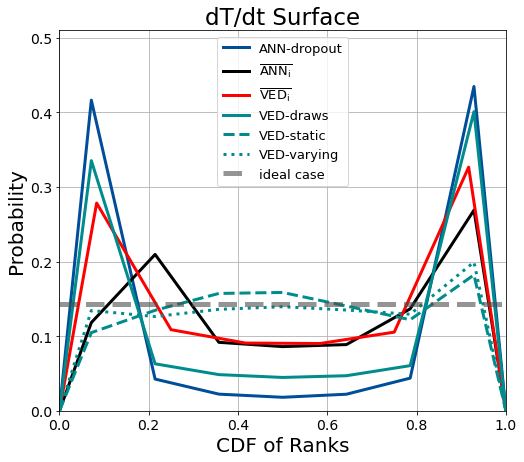

In [10]:
plt.figure(1,(8,7))
plt.title(r'dT/dt Surface',fontsize=23)

plt.plot(np.hstack((0,ANN_lin_dr_0_01TBCTEND['pit_centers'],1)),np.hstack((0,ANN_lin_dr_0_01TBCTEND['pit_counts'],0)),
         color=[0,0.3,0.6],linewidth=3,label='ANN-dropout')
plt.plot(np.hstack((0,deter_7_lin_TBCTEND['pit_centers'],1)),np.hstack((0,deter_7_lin_TBCTEND['pit_counts'],0))
         ,color='k',linewidth=3,label=r'$\mathrm{\overline{ANN_i}}$')
plt.plot(np.hstack((0,deter_6_VED_TBCTEND['pit_centers'],1)),np.hstack((0,deter_6_VED_TBCTEND['pit_counts'],0)),
         color='r',linewidth=3,label=r'$\mathrm{\overline{VED_i}}$')
plt.plot(np.hstack((0,VED_1_7_0_0_TBCTEND['pit_centers'],1)),
         np.hstack((0,VED_1_7_0_0_TBCTEND['pit_counts'],0)),color=[0,0.55,0.55],linewidth=3,label=r'VED-draws')

plt.plot(np.hstack((0,VED_1_7_0_5_TBCTEND['pit_centers'],1)),
         np.hstack((0,VED_1_7_0_5_TBCTEND['pit_counts'],0)),'--',color=[0,0.55,0.55],linewidth=3,label=r'VED-static')
plt.plot(np.hstack((0,VED_1_7_alpha_TBCTEND['pit_centers'],1)),
         np.hstack((0,VED_1_7_alpha_TBCTEND['pit_counts'],0)),linewidth=3,linestyle=':',color=[0,0.55,0.55],label=r'VED-varying')




plt.hlines(1/7,0,1,linestyle='--',linewidth=5,colors=[[0.3,0.3,0.3,0.6]],label='ideal case')



plt.grid(True)
plt.ylim(0,0.51)
plt.xlim(0,1)
plt.xlabel('CDF of Ranks',fontsize=20)
plt.legend(fontsize=13)
plt.ylabel('Probability',fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

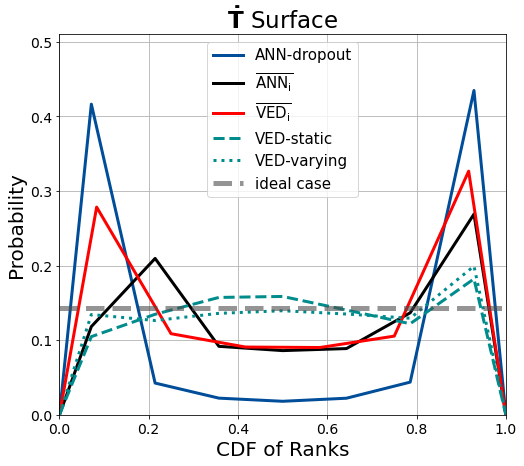

In [14]:
plt.figure(1,(8,7))
plt.title(r'$\mathbf{\dot{T}}$ Surface',fontsize=23)

plt.plot(np.hstack((0,ANN_lin_dr_0_01TBCTEND['pit_centers'],1)),np.hstack((0,ANN_lin_dr_0_01TBCTEND['pit_counts'],0)),
         color=[0,0.3,0.6],linewidth=3,label='ANN-dropout')
plt.plot(np.hstack((0,deter_7_lin_TBCTEND['pit_centers'],1)),np.hstack((0,deter_7_lin_TBCTEND['pit_counts'],0))
         ,color='k',linewidth=3,label=r'$\mathrm{\overline{ANN_i}}$')
plt.plot(np.hstack((0,deter_6_VED_TBCTEND['pit_centers'],1)),np.hstack((0,deter_6_VED_TBCTEND['pit_counts'],0)),
         color='r',linewidth=3,label=r'$\mathrm{\overline{VED_i}}$')
#plt.plot(np.hstack((0,VED_1_7_0_0_TBCTEND['pit_centers'],1)),
#         np.hstack((0,VED_1_7_0_0_TBCTEND['pit_counts'],0)),color=[0,0.55,0.55],linewidth=3,label=r'VED-draws')

plt.plot(np.hstack((0,VED_1_7_0_5_TBCTEND['pit_centers'],1)),
         np.hstack((0,VED_1_7_0_5_TBCTEND['pit_counts'],0)),'--',color=[0,0.55,0.55],linewidth=3,label=r'VED-static')
plt.plot(np.hstack((0,VED_1_7_alpha_TBCTEND['pit_centers'],1)),
         np.hstack((0,VED_1_7_alpha_TBCTEND['pit_counts'],0)),linewidth=3,linestyle=':',color=[0,0.55,0.55],label=r'VED-varying')




plt.hlines(1/7,0,1,linestyle='--',linewidth=5,colors=[[0.3,0.3,0.3,0.6]],label='ideal case')



plt.grid(True)
plt.ylim(0,0.51)
plt.xlim(0,1)
plt.xlabel('CDF of Ranks',fontsize=20)
plt.legend(fontsize=15)
plt.ylabel('Probability',fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

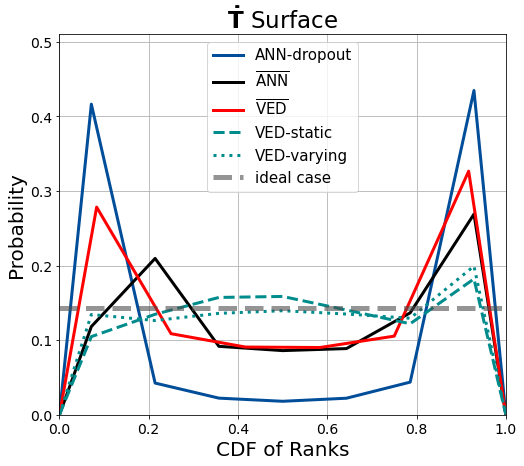

In [9]:
plt.figure(1,(8,7))
plt.title(r'$\mathbf{\dot{T}}$ Surface',fontsize=23)

plt.plot(np.hstack((0,ANN_lin_dr_0_01TBCTEND['pit_centers'],1)),np.hstack((0,ANN_lin_dr_0_01TBCTEND['pit_counts'],0)),
         color=[0,0.3,0.6],linewidth=3,label='ANN-dropout')
plt.plot(np.hstack((0,deter_7_lin_TBCTEND['pit_centers'],1)),np.hstack((0,deter_7_lin_TBCTEND['pit_counts'],0))
         ,color='k',linewidth=3,label=r'$\mathrm{\overline{ANN}}$')
plt.plot(np.hstack((0,deter_6_VED_TBCTEND['pit_centers'],1)),np.hstack((0,deter_6_VED_TBCTEND['pit_counts'],0)),
         color='r',linewidth=3,label=r'$\mathrm{\overline{VED}}$')
#plt.plot(np.hstack((0,VED_1_7_0_0_TBCTEND['pit_centers'],1)),
#         np.hstack((0,VED_1_7_0_0_TBCTEND['pit_counts'],0)),color=[0,0.55,0.55],linewidth=3,label=r'VED-draws')

plt.plot(np.hstack((0,VED_1_7_0_5_TBCTEND['pit_centers'],1)),
         np.hstack((0,VED_1_7_0_5_TBCTEND['pit_counts'],0)),'--',color=[0,0.55,0.55],linewidth=3,label=r'VED-static')
plt.plot(np.hstack((0,VED_1_7_alpha_TBCTEND['pit_centers'],1)),
         np.hstack((0,VED_1_7_alpha_TBCTEND['pit_counts'],0)),linewidth=3,linestyle=':',color=[0,0.55,0.55],label=r'VED-varying')




plt.hlines(1/7,0,1,linestyle='--',linewidth=5,colors=[[0.3,0.3,0.3,0.6]],label='ideal case')



plt.grid(True)
plt.ylim(0,0.51)
plt.xlim(0,1)
plt.xlabel('CDF of Ranks',fontsize=20)
plt.legend(fontsize=15)
plt.ylabel('Probability',fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

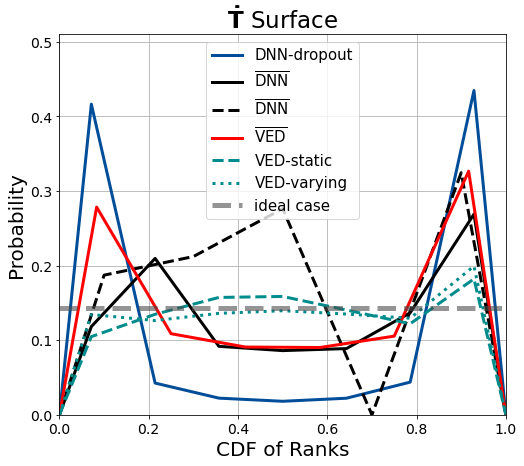

In [127]:
plt.figure(1,(8,7))
plt.title(r'$\mathbf{\dot{T}}$ Surface',fontsize=23)

plt.plot(np.hstack((0,ANN_lin_dr_0_01TBCTEND['pit_centers'],1)),np.hstack((0,ANN_lin_dr_0_01TBCTEND['pit_counts'],0)),
         color=[0,0.3,0.6],linewidth=3,label='DNN-dropout')
plt.plot(np.hstack((0,deter_7_lin_TBCTEND['pit_centers'],1)),np.hstack((0,deter_7_lin_TBCTEND['pit_counts'],0))
         ,color='k',linewidth=3,label=r'$\mathrm{\overline{DNN}}$')

plt.plot(np.hstack((0,stoch_5_lin_TBCTEND['pit_centers'],1)),np.hstack((0,stoch_5_lin_TBCTEND['pit_counts'],0))
         ,'--',color='k',linewidth=3,label=r'$\mathrm{\overline{DNN}}$')


plt.plot(np.hstack((0,deter_6_VED_TBCTEND['pit_centers'],1)),np.hstack((0,deter_6_VED_TBCTEND['pit_counts'],0)),
         color='r',linewidth=3,label=r'$\mathrm{\overline{VED}}$')
#plt.plot(np.hstack((0,VED_1_7_0_0_TBCTEND['pit_centers'],1)),
#         np.hstack((0,VED_1_7_0_0_TBCTEND['pit_counts'],0)),color=[0,0.55,0.55],linewidth=3,label=r'VED-draws')

plt.plot(np.hstack((0,VED_1_7_0_5_TBCTEND['pit_centers'],1)),
         np.hstack((0,VED_1_7_0_5_TBCTEND['pit_counts'],0)),'--',color=[0,0.55,0.55],linewidth=3,label=r'VED-static')
plt.plot(np.hstack((0,VED_1_7_alpha_TBCTEND['pit_centers'],1)),
         np.hstack((0,VED_1_7_alpha_TBCTEND['pit_counts'],0)),linewidth=3,linestyle=':',color=[0,0.55,0.55],label=r'VED-varying')




plt.hlines(1/7,0,1,linestyle='--',linewidth=5,colors=[[0.3,0.3,0.3,0.6]],label='ideal case')



plt.grid(True)
plt.ylim(0,0.51)
plt.xlim(0,1)
plt.xlabel('CDF of Ranks',fontsize=20)
plt.legend(fontsize=15)
plt.ylabel('Probability',fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

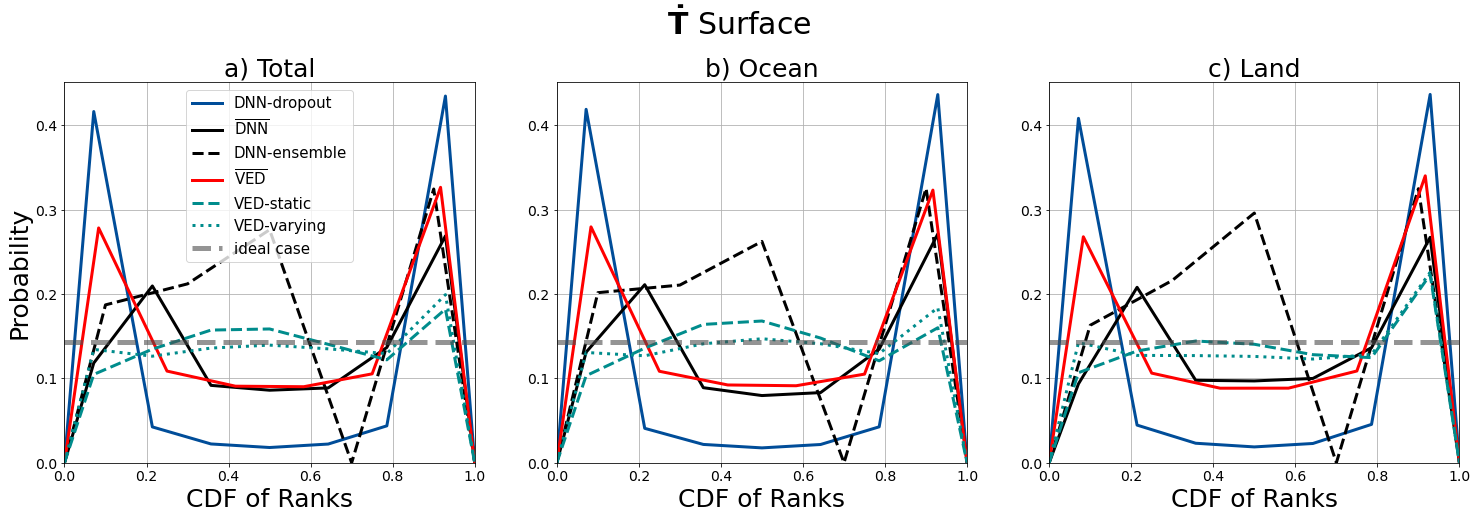

In [48]:
plt.figure(1,(25,7))
plt.suptitle(r'$\mathbf{\dot{T}}$ Surface',fontsize=30,y=1.03)

plt.subplot(1,3,1)
plt.title('a) Total', fontsize=25)

plt.plot(np.hstack((0,ANN_lin_dr_0_01TBCTEND['pit_centers'],1)),np.hstack((0,ANN_lin_dr_0_01TBCTEND['pit_counts'],0)),
         color=[0,0.3,0.6],linewidth=3,label='DNN-dropout')
plt.plot(np.hstack((0,deter_7_lin_TBCTEND['pit_centers'],1)),np.hstack((0,deter_7_lin_TBCTEND['pit_counts'],0))
         ,color='k',linewidth=3,label=r'$\mathrm{\overline{DNN}}$')

plt.plot(np.hstack((0,stoch_5_lin_TBCTEND['pit_centers'],1)),np.hstack((0,stoch_5_lin_TBCTEND['pit_counts'],0))
         ,'--',color='k',linewidth=3,label='DNN-ensemble')

plt.plot(np.hstack((0,deter_6_VED_TBCTEND['pit_centers'],1)),np.hstack((0,deter_6_VED_TBCTEND['pit_counts'],0)),
         color='r',linewidth=3,label=r'$\mathrm{\overline{VED}}$')
#plt.plot(np.hstack((0,VED_1_7_0_0_TBCTEND['pit_centers'],1)),
#         np.hstack((0,VED_1_7_0_0_TBCTEND['pit_counts'],0)),color=[0,0.55,0.55],linewidth=3,label=r'VED-draws')

plt.plot(np.hstack((0,VED_1_7_0_5_TBCTEND['pit_centers'],1)),
         np.hstack((0,VED_1_7_0_5_TBCTEND['pit_counts'],0)),'--',color=[0,0.55,0.55],linewidth=3,label=r'VED-static')
plt.plot(np.hstack((0,VED_1_7_alpha_TBCTEND['pit_centers'],1)),
         np.hstack((0,VED_1_7_alpha_TBCTEND['pit_counts'],0)),linewidth=3,linestyle=':',color=[0,0.55,0.55],label=r'VED-varying')


plt.hlines(1/7,0,1,linestyle='--',linewidth=5,colors=[[0.3,0.3,0.3,0.6]],label='ideal case')



plt.grid(True)
plt.ylim(0,0.451)
plt.xlim(0,1)
plt.xlabel('CDF of Ranks',fontsize=25)
plt.legend(fontsize=15)
plt.ylabel('Probability',fontsize=25)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


plt.subplot(1,3,2)
plt.title('b) Ocean', fontsize=25)
plt.plot(np.hstack((0,ANN_lin_dr_0_01TBCTEND_ocean['pit_centers'],1)),np.hstack((0,ANN_lin_dr_0_01TBCTEND_ocean['pit_counts'],0)),
         color=[0,0.3,0.6],linewidth=3,label='DNN-dropout')
plt.plot(np.hstack((0,deter_7_lin_TBCTEND_ocean['pit_centers'],1)),np.hstack((0,deter_7_lin_TBCTEND_ocean['pit_counts'],0))
         ,color='k',linewidth=3,label=r'$\mathrm{\overline{DNN}}$')
plt.plot(np.hstack((0,stoch_5_lin_TBCTEND_ocean['pit_centers'],1)),np.hstack((0,stoch_5_lin_TBCTEND_ocean['pit_counts'],0))
         ,'--',color='k',linewidth=3,label=r'DNN-ensemble')

plt.plot(np.hstack((0,deter_6_VED_TBCTEND_ocean['pit_centers'],1)),np.hstack((0,deter_6_VED_TBCTEND_ocean['pit_counts'],0)),
         color='r',linewidth=3,label=r'$\mathrm{\overline{VED}}$')
#plt.plot(np.hstack((0,VED_1_7_0_0_CLDLITBCTEND['pit_centers'],1)),
#         np.hstack((0,VED_1_7_0_0_CLDLITBCTEND['pit_counts'],0)),color=[0,0.55,0.55],linewidth=3,label=r'VED-draws')

plt.plot(np.hstack((0,VED_1_7_0_5_TBCTEND_ocean['pit_centers'],1)),
         np.hstack((0,VED_1_7_0_5_TBCTEND_ocean['pit_counts'],0)),'--',color=[0,0.55,0.55],linewidth=3,label=r'VED-static')
plt.plot(np.hstack((0,VED_1_7_alpha_TBCTEND_ocean['pit_centers'],1)),
         np.hstack((0,VED_1_7_alpha_TBCTEND_ocean['pit_counts'],0)),linewidth=3,linestyle=':',color=[0,0.55,0.55],label=r'VED-varying')




plt.hlines(1/7,0,1,linestyle='--',linewidth=5,colors=[[0.3,0.3,0.3,0.6]],label='ideal case')



plt.grid(True)
plt.ylim(0,0.451)
plt.xlim(0,1)
plt.xlabel('CDF of Ranks',fontsize=25)
#plt.legend(fontsize=15)
#plt.ylabel('Probability',fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(1,3,3)
plt.title('c) Land', fontsize=25)
plt.plot(np.hstack((0,ANN_lin_dr_0_01TBCTEND_land['pit_centers'],1)),np.hstack((0,ANN_lin_dr_0_01TBCTEND_land['pit_counts'],0)),
         color=[0,0.3,0.6],linewidth=3,label='DNN-dropout')
plt.plot(np.hstack((0,deter_7_lin_TBCTEND_land['pit_centers'],1)),np.hstack((0,deter_7_lin_TBCTEND_land['pit_counts'],0))
         ,color='k',linewidth=3,label=r'$\mathrm{\overline{DNN}}$')
plt.plot(np.hstack((0,stoch_5_lin_TBCTEND_land['pit_centers'],1)),np.hstack((0,stoch_5_lin_TBCTEND_land['pit_counts'],0))
         ,'--',color='k',linewidth=3,label=r'DNN-ensemble')

plt.plot(np.hstack((0,deter_6_VED_TBCTEND_land['pit_centers'],1)),np.hstack((0,deter_6_VED_TBCTEND_land['pit_counts'],0)),
         color='r',linewidth=3,label=r'$\mathrm{\overline{VED}}$')
#plt.plot(np.hstack((0,VED_1_7_0_0_CLDLITBCTEND['pit_centers'],1)),
#         np.hstack((0,VED_1_7_0_0_CLDLITBCTEND['pit_counts'],0)),color=[0,0.55,0.55],linewidth=3,label=r'VED-draws')

plt.plot(np.hstack((0,VED_1_7_0_5_TBCTEND_land['pit_centers'],1)),
         np.hstack((0,VED_1_7_0_5_TBCTEND_land['pit_counts'],0)),'--',color=[0,0.55,0.55],linewidth=3,label=r'VED-static')
plt.plot(np.hstack((0,VED_1_7_alpha_TBCTEND_land['pit_centers'],1)),
         np.hstack((0,VED_1_7_alpha_TBCTEND_land['pit_counts'],0)),linewidth=3,linestyle=':',color=[0,0.55,0.55],label=r'VED-varying')




plt.hlines(1/7,0,1,linestyle='--',linewidth=5,colors=[[0.3,0.3,0.3,0.6]],label='ideal case')



plt.grid(True)
plt.ylim(0,0.451)
plt.xlim(0,1)
plt.xlabel('CDF of Ranks',fontsize=25)
#plt.legend(fontsize=15)
#plt.ylabel('Probability',fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

